In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
os.chdir("/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer")
import sys
sys.path.append('/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer']

In [5]:
!pip install tf-keras-vis tensorflow
!pip install lime
!pip install shap
!pip install innvestigate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=713a1b8336c97402cbbbdcf01683d4b4a054a3564cdeed1c8398c8d409ab1e1c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.8 MB/s eta 0:00:00
   ━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.vgg16 as vgg16

from skimage.color import gray2rgb, rgb2gray, label2rgb

from Metrics.LSE_Analysis import lse_calculate
from Images.Relevance.explanations_functions.gradcam_explainer import gradcam_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.lrp_explainer import lrp_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.lime_explainer import lime_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.shap_explainer import shap_explanations_and_lse_all_classes
from aux_functions import visualize_explanations_horizontal_with_original, visualize_all_classes, save_explanations_to_pkl, load_explanations_from_pkl, ensure_single_channel, normalize_map, is_valid_map

from Images.Integrations import owa_integrations, union_owa_integrations, intersection_owa_integrations

#Reading Data and Model (MNIST)



In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# For use with Lime and Shap
x_train_rgb = np.stack([gray2rgb(img) for img in x_train], axis=0)
x_test_rgb = np.stack([gray2rgb(img) for img in x_test], axis=0)

# Convert to Keras-compatible format (add channel dimension for RGB images)
x_train_rgb = x_train_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)
x_test_rgb = x_test_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)

# Preprocess the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
# Load model and weights separately
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

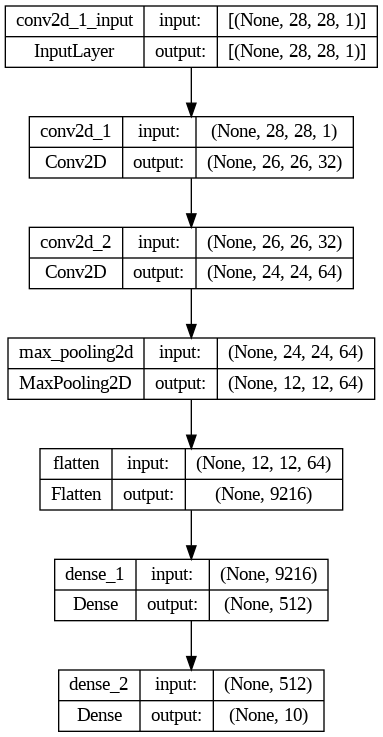

In [5]:
# Visualize the model and save the image
plot_model(loaded_model, to_file="model_topology.png", show_shapes=True, show_layer_names=True)

#Instance Selection (MNIST)

1/1 [==============================] - 0s 76ms/step


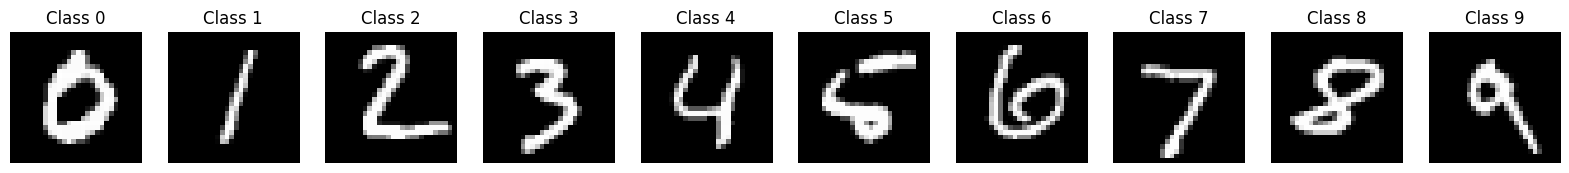

In [6]:
# Function to select a correctly classified image for each class
def select_correctly_classified_images(x_test, y_test, model):
    selected_images = []
    selected_labels = []

    for i in range(10):  # Iterate through all classes (0-9)
        # Get the indices of images belonging to class i
        indices = np.where(y_test == i)[0]

        for idx in indices:
            image = x_test[idx]
            label = y_test[idx]
            # Predict the class using the model
            prediction = np.argmax(model.predict(image[np.newaxis, ...]), axis=1)[0]

            if prediction == label:
                selected_images.append(image)
                selected_labels.append(label)
                break  # Move to the next class once a correctly classified image is selected

    return np.array(selected_images), np.array(selected_labels)

# Select one correctly classified image per class
x_selected, y_selected = select_correctly_classified_images(x_test, y_test, loaded_model)
x_selected_rgb = np.stack([gray2rgb(img) for img in x_selected], axis=0)

# Visualize the selected images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_selected[i].squeeze(), cmap='gray')
    plt.title(f'Class {y_selected[i]}')
    plt.axis('off')
plt.show()

# Individual Explanations


##GRADCAM++

Normalized Maps: [array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.06149733, 0.20588235, 0.34224599, 0.39572193,
        0.29144385, 0.17112299, 0.07219251, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.06149733, 0.20588235, 0.34224599, 0.36363636, 0.26737968,
        0.31550802, 0.24331551, 0.12032086, 0.02406417, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01336898,
        0.20588235, 0.44919786, 0.58823529, 0.35294118, 0.09625668,
        

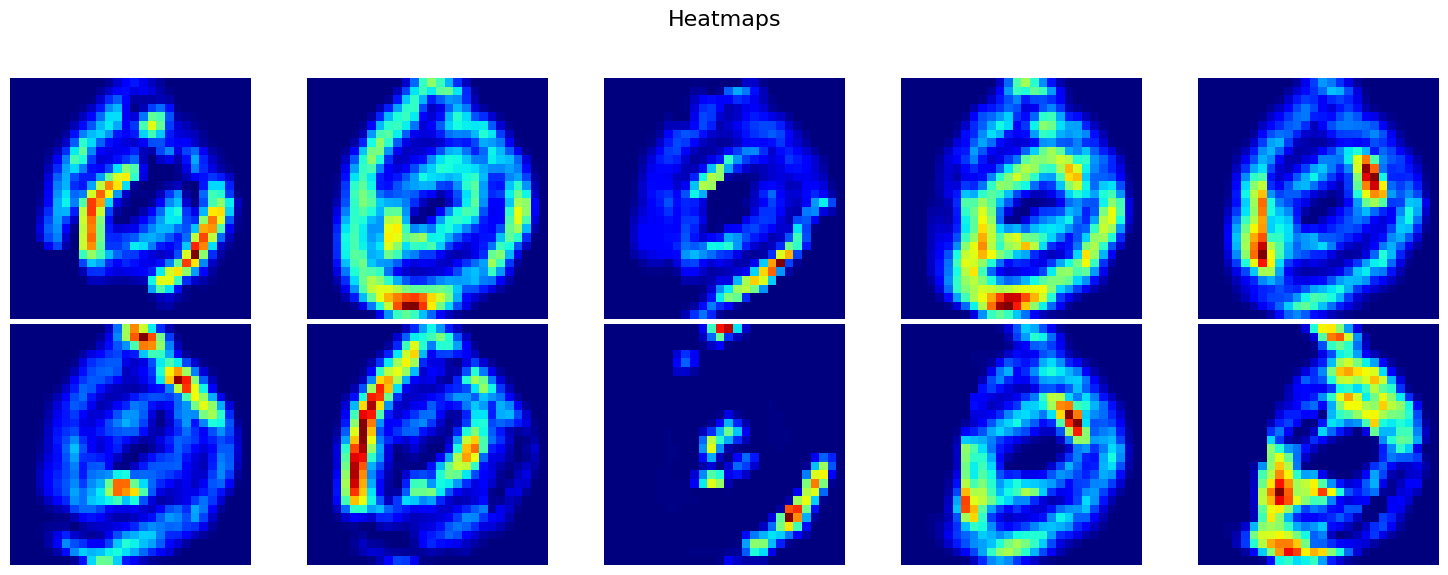

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 88
Indices greater than 0.85: [123 124 128 129 151 155 156 157 178 183 184 185 204 205 231 232 259 260
 287 292 293 294 319 320 321 322 346 348 349 359 360 370 373 375 387 388
 398 400 403 411 415 416 417 428 430 438 439 443 444 445 456 458 466 467
 470 472 484 486 497 500 512 514 525 527 540 542 546 547 552 555 568 569
 570 580 582 597 607 609 633 634 635 636 660 661 662 663 689 690]
Sum of target class: 85.34224598930483
Sum of other classes: 469.86898395721926
Calc

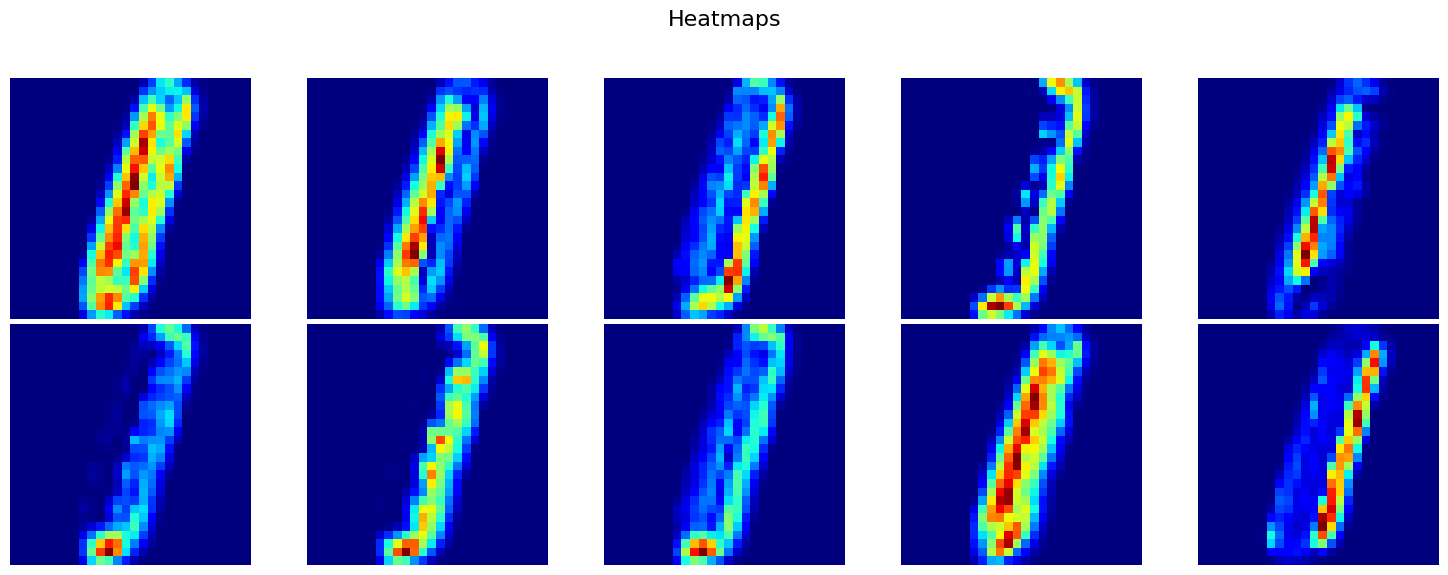

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 73
Indices greater than 0.85: [ 72  99 100 101 127 128 129 130 132 155 156 157 182 183 184 185 210 212
 238 240 265 266 268 293 294 296 321 322 326 348 349 351 376 377 404 406
 431 432 434 459 460 462 487 514 515 542 545 570 573 597 598 603 625 626
 627 628 631 653 654 655 656 658 681 682 683 684 686 710 711 712 738 739
 740]
Sum of target class: 71.05347593582891
Sum of other classes: 351.33689839572196
Calculated IFI: 1.8201369863013708
Normalized Maps: [array([[0. 

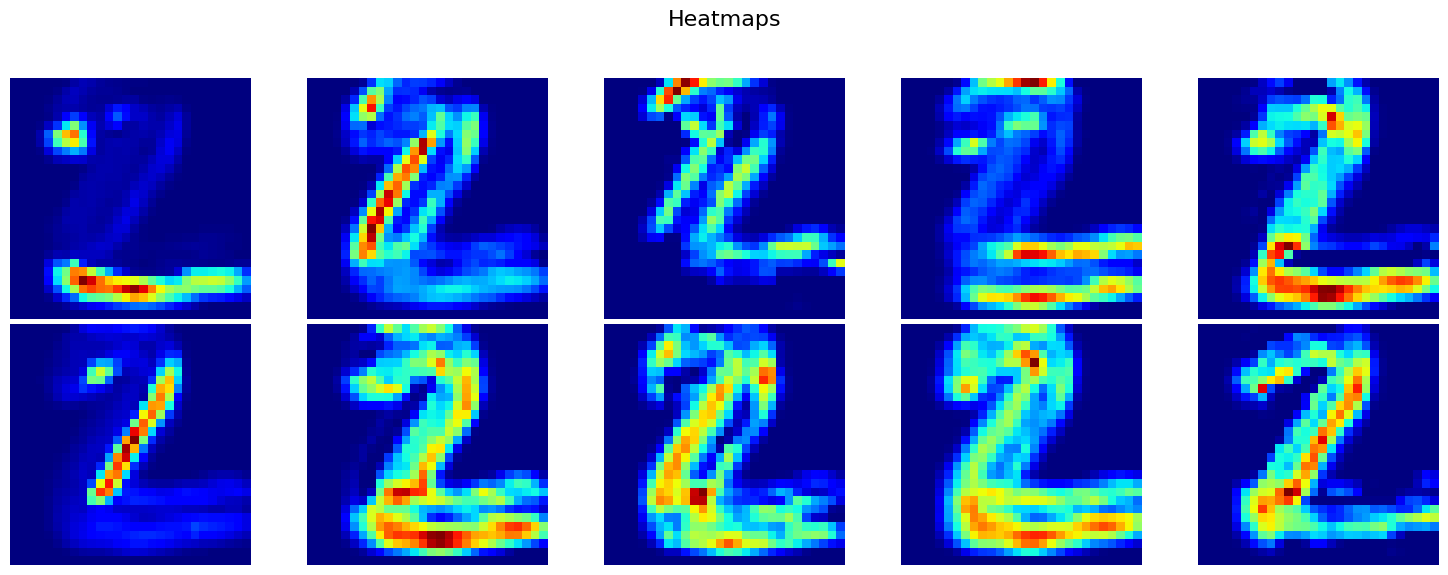

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 102
Indices greater than 0.85: [  7  11  12  13  14  15  34  38  62  64  69  89  90  91  97 121 122 125
 149 150 151 153 154 178 179 180 181 207 208 209 214 234 235 236 241 242
 262 263 267 268 269 270 289 290 291 295 296 297 317 318 323 324 344 345
 350 351 372 373 377 378 379 399 400 405 406 426 427 432 433 454 455 460
 461 482 487 488 489 515 526 527 528 545 546 551 552 553 554 555 556 557
 573 574 575 576 577 578 579 580 581 582 614 615]
Sum of target class: 99.68

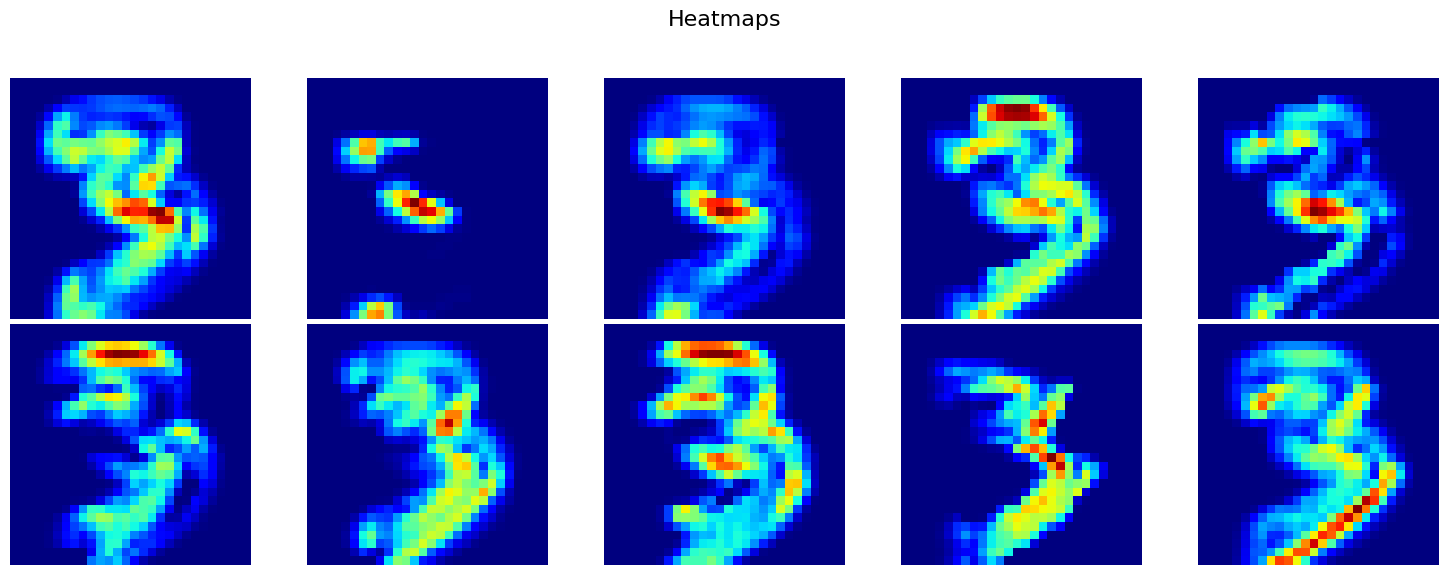

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 186
Indices greater than 0.85: [ 66  67  68  69  70  71  93 100 101 121 129 130 149 150 151 152 153 154
 155 156 157 158 177 178 179 180 181 185 186 187 202 203 204 205 206 207
 208 209 210 214 215 229 230 231 233 234 235 236 237 238 241 242 243 257
 258 259 260 265 269 270 286 287 293 295 296 297 298 322 323 324 325 326
 350 351 352 353 354 355 356 374 375 376 378 379 380 381 382 383 384 385
 402 403 404 405 408 409 411 412 413 430 431 432 433 434 438 439 440 441
 44

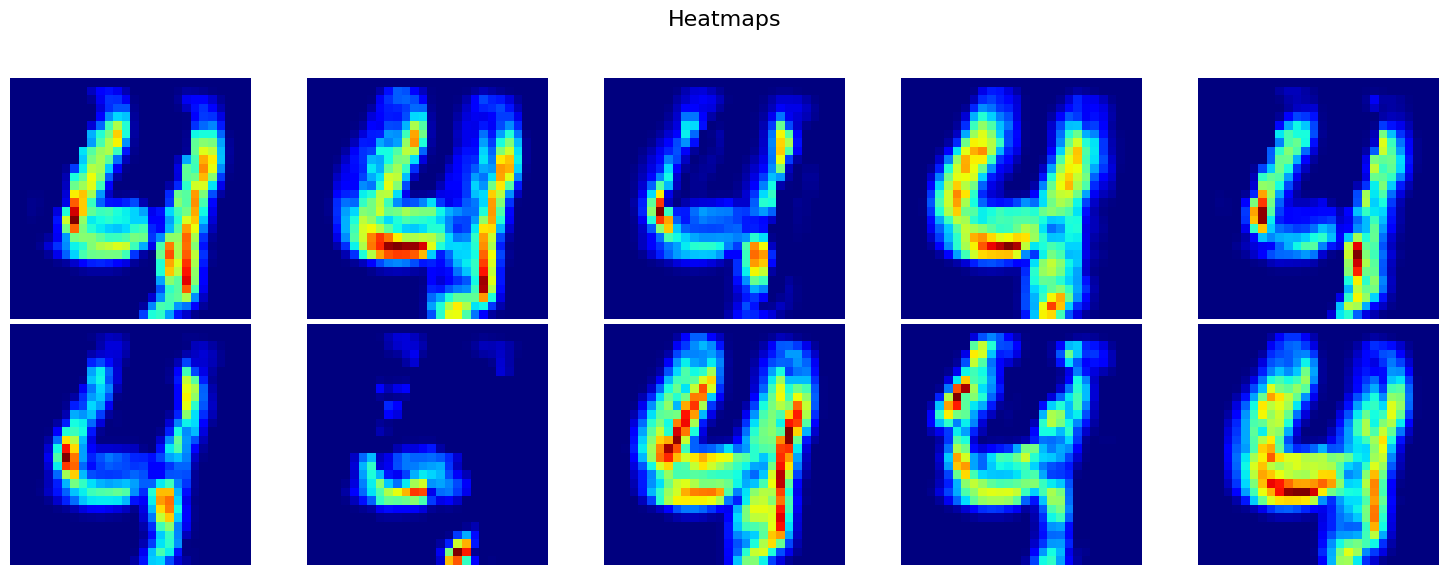

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 104
Indices greater than 0.85: [151 152 177 178 179 180 189 190 206 207 208 217 218 233 234 235 245 246
 261 262 272 273 274 275 288 289 290 300 301 302 303 315 316 317 328 329
 330 343 344 345 356 357 358 372 383 384 385 398 400 411 412 413 428 438
 439 440 441 454 456 468 482 483 484 490 496 511 516 517 518 521 522 523
 524 543 544 545 549 551 552 577 579 580 605 607 608 633 635 636 661 662
 663 664 690 691 692 717 718 719 720 744 745 746 772 773]
Sum of target clas

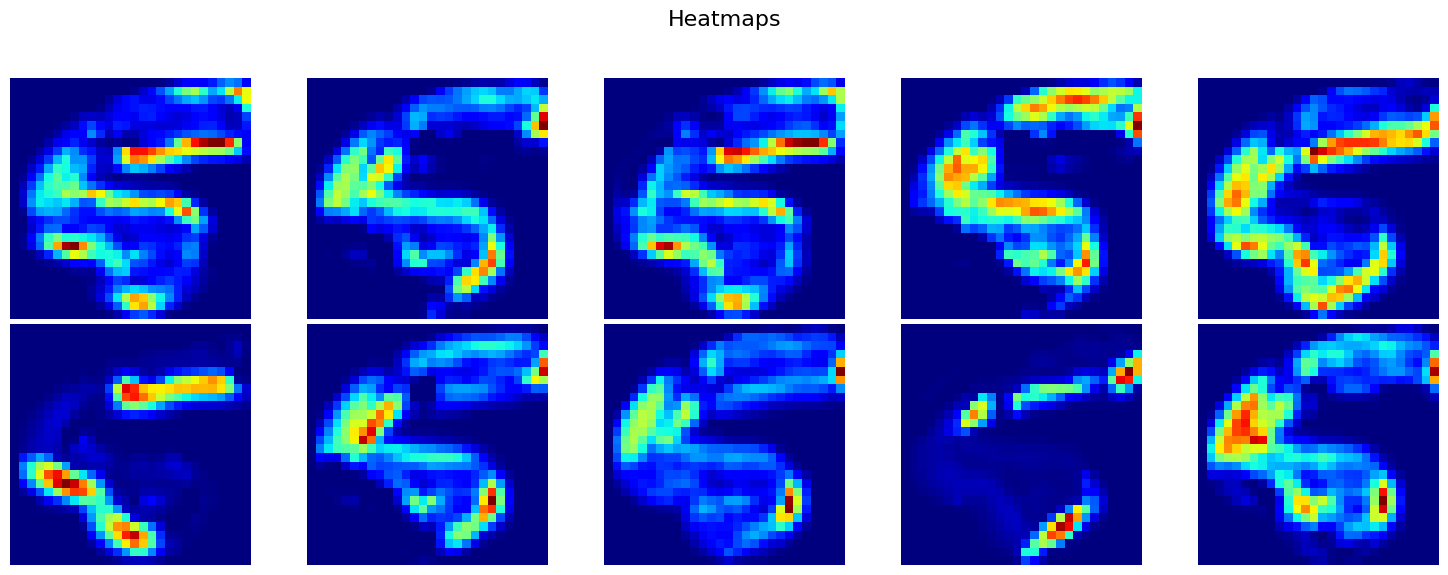

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 69
Indices greater than 0.85: [181 182 186 187 188 189 190 192 193 208 211 212 213 214 215 216 220 221
 236 240 241 242 243 244 245 246 265 266 267 268 450 451 452 453 478 479
 483 484 507 508 513 536 537 541 542 567 568 569 570 597 598 599 626 627
 628 629 654 655 658 659 683 684 688 712 713 715 716 742 743]
Sum of target class: 66.89839572192514
Sum of other classes: 270.4652406417112
Calculated IFI: 2.2261106827213952
Normalized Maps: [array([[0.        , 0.       

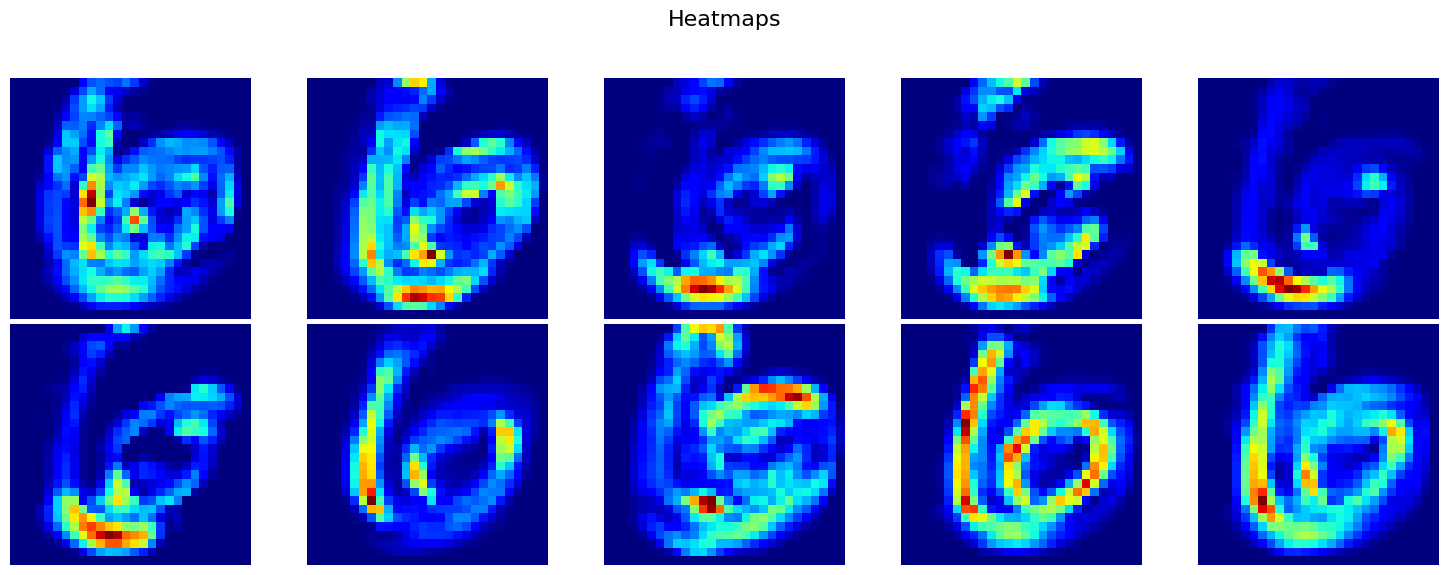

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 61
Indices greater than 0.85: [121 148 149 176 177 204 205 232 259 260 287 288 315 316 330 331 342 343
 358 359 360 370 371 386 387 388 397 398 399 414 415 416 425 426 427 432
 442 443 453 455 460 461 470 471 481 483 487 489 509 516 517 537 540 545
 546 566 568 574 596 624 625]
Sum of target class: 59.12299465240645
Sum of other classes: 290.0641711229947
Calculated IFI: 1.834445632535674
Normalized Maps: [array([[0.        , 0.        , 0.        , 0.        , 0.    

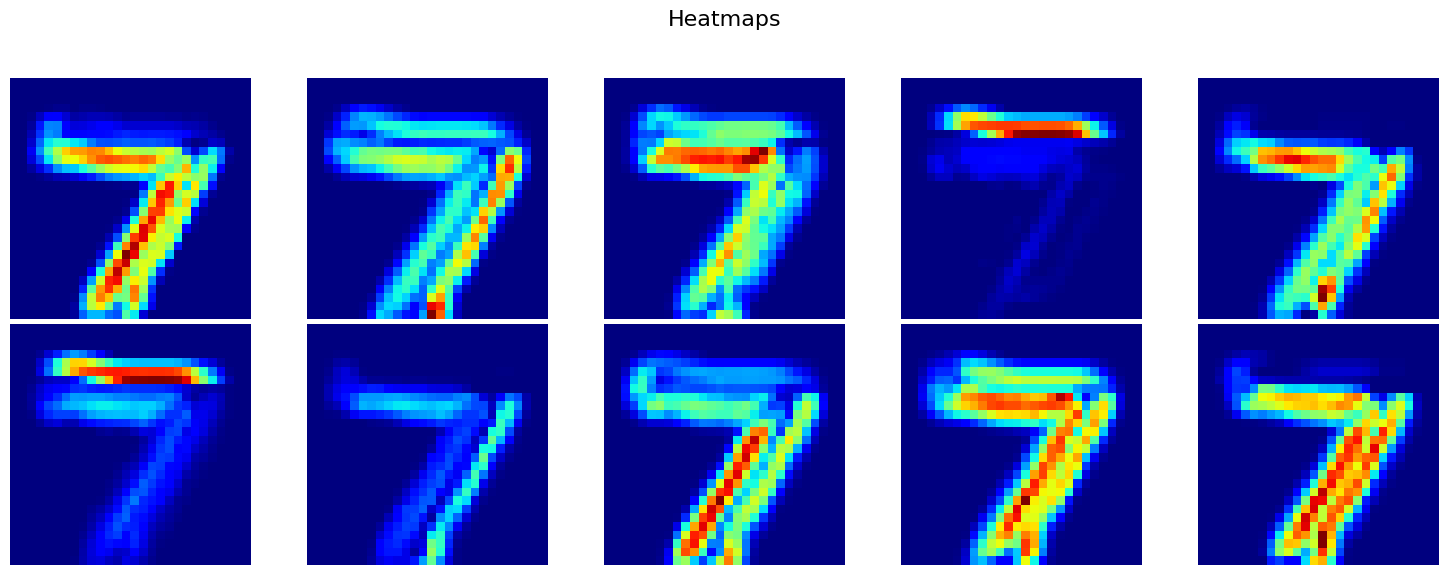

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 133
Indices greater than 0.85: [144 145 171 172 199 200 228 229 230 231 232 233 234 235 236 237 241 242
 247 248 256 257 258 259 260 261 262 263 264 265 266 267 268 269 274 275
 276 285 286 289 290 291 292 293 294 295 296 297 302 303 304 324 325 326
 327 330 331 352 355 357 358 359 379 384 385 386 407 410 412 413 434 437
 438 439 440 441 462 465 467 468 489 492 493 494 495 496 517 520 521 522
 523 544 547 548 549 550 551 571 574 576 577 578 599 603 604 605 606 626
 62

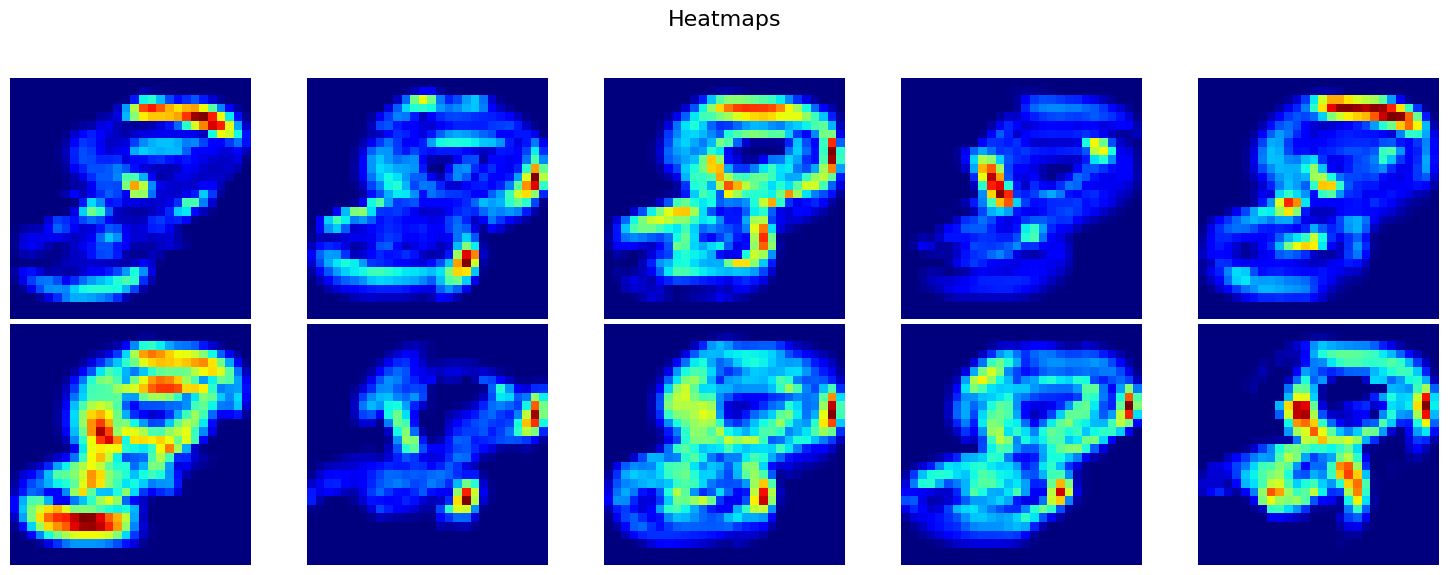

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 164
Indices greater than 0.85: [ 96 122 123 124 149 150 151 176 177 178 179 184 185 186 187 188 189 203
 204 205 206 207 208 209 210 217 218 222 233 234 235 236 245 246 249 251
 262 263 264 272 273 274 277 279 289 290 291 292 298 299 300 301 302 305
 307 317 318 319 320 321 325 326 327 328 329 332 333 334 346 347 348 349
 350 352 353 354 355 356 357 358 359 360 361 374 375 376 378 379 380 381
 382 383 384 385 386 387 402 403 404 409 410 411 412 413 429 430 431 437
 43

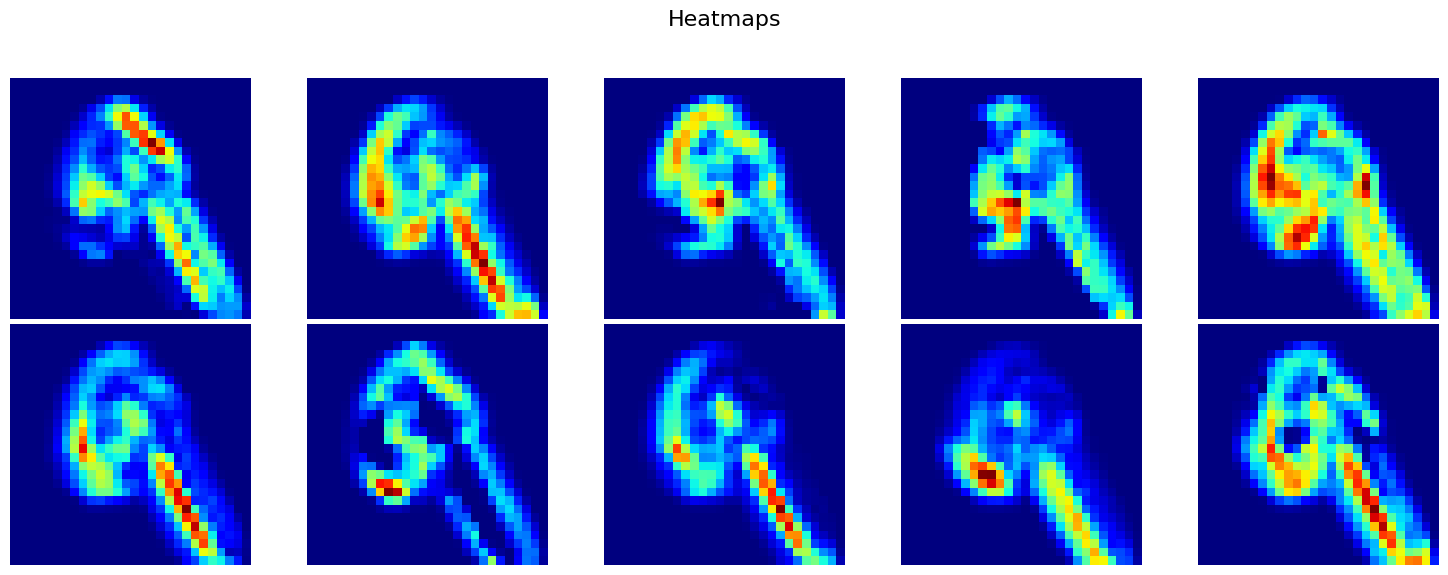

Original shape of relevances: (10, 28, 28, 3)
Valid maps (including zeros for invalid ones): 10
Number of invalid maps: 0
Shape of valid maps: (10, 28, 28)
Shape of flattened relevances: (10, 784)
Shape of class relevance: (784,)
Map 0: Max: 1.0, Min: 0.0
Map 1: Max: 1.0, Min: 0.0
Map 2: Max: 1.0, Min: 0.0
Map 3: Max: 1.0, Min: 0.0
Map 4: Max: 1.0, Min: 0.0
Map 5: Max: 1.0, Min: 0.0
Map 6: Max: 1.0, Min: 0.0
Map 7: Max: 1.0, Min: 0.0
Map 8: Max: 1.0, Min: 0.0
Map 9: Max: 1.0, Min: 0.0
Number of features greater than 0.85: 146
Indices greater than 0.85: [ 95  96  97 121 122 123 124 125 126 149 150 151 154 155 177 178 183 184
 204 205 211 212 213 214 232 233 237 240 241 242 260 261 264 265 266 267
 270 287 288 289 290 291 292 293 294 295 299 300 315 317 321 322 323 327
 328 342 343 344 349 350 351 370 371 377 378 380 398 399 401 404 405 406
 407 408 409 426 427 430 431 432 433 434 435 436 438 454 455 456 459 460
 461 462 464 466 483 484 485 488 489 490 492 495 512 513 516 517 521 541
 54

In [7]:
# Call to generate GradCAM++ for all classes
gradcam_explanations, lse_gradcam = gradcam_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    y_selected,
    threshold=0.85)

In [8]:
lse_gradcam = [item[0] for item in lse_gradcam]

print(lse_gradcam)
sum= np.sum(lse_gradcam)
prom= sum/10
print(f"Promedio: {prom}")

[1.634668897348789, 1.8201369863013708, 1.8783944915610045, 1.469423620967204, 1.418481513499136, 2.2261106827213952, 1.834445632535674, 1.4659227622714155, 1.5193247559187573, 1.357499679774561]
Promedio: 1.6624409022899307


In [13]:
# Verify and adjust lse_value if they are greater than 9.5
gradcam_explanations_data = {
    'explanations': gradcam_explanations,
    'lse_value': [min(value, 9.5) for value in lse_gradcam]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(gradcam_explanations_data, "Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl")

Explanations saved to Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl


##LRP

In [ ]:
tf.compat.v1.disable_eager_execution()  # Disable eager execution for compatibility with certain TensorFlow operations

# Load model and weights
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

# Run LRP for all selected images
lrp_explanations, lse_lrp = lrp_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    y_selected,
    threshold=0.85)

In [ ]:
lse_lrp = [item[0] for item in lse_lrp]

print(lse_lrp)
sum= np.sum(lse_lrp)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
lrp_explanations_data = {
    'explanations': lrp_explanations,
    'lse_value': [min(value, 9.5) for value in lse_lrp]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(lrp_explanations_data, "Images/Relevance/explanations_pkl/lrp_explanation_data.pkl")

##LIME

In [ ]:
# Call to generate LIME explanations for all classes
lime_explanations, lse_lime = lime_explanations_and_lse_all_classes(
    loaded_model,
    x_selected_rgb,
    y_selected,
    threshold=0.85)

In [ ]:
lse_lime = [item[0] for item in lse_lime]

print(lse_lime)
sum= np.sum(lse_lime)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
lime_explanations_data = {
    'explanations': lime_explanations,
    'lse_value': [min(value, 9.5) for value in lse_lime]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(lime_explanations_data, "Images/Relevance/explanations_pkl/lime_explanation_data.pkl")

##SHAP

In [ ]:
# Call to generate SHAP explanations for all classes
shap_explanations, lse_shap = shap_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    x_train,
    y_selected,
    thershold = 0.85)

In [ ]:
lse_shap = [item[0] for item in lse_shap]

print(lse_shap)
sum= np.sum(lse_shap)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
shap_explanations_data = {
    'explanations': shap_explanations,
    'lse_value':  [min(value, 9.5) for value in lse_shap]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(shap_explanations_data, "Images/Relevance/explanations_pkl/shap_explanation_data.pkl")


# Reading Explanations

In [13]:
# List of paths to explanation files
explanation_paths = [
    "Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/lrp_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/lime_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/shap_explanation_data.pkl"
]

# Load the explanations
new_explanations_data = [load_explanations_from_pkl(path) for path in explanation_paths]

Explanations loaded from Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl
Explanations loaded from Images/Relevance/explanations_pkl/lrp_explanation_data.pkl
Explanations loaded from Images/Relevance/explanations_pkl/lime_explanation_data.pkl
Explanations loaded from Images/Relevance/explanations_pkl/shap_explanation_data.pkl


# INTEGRATION

##OWA

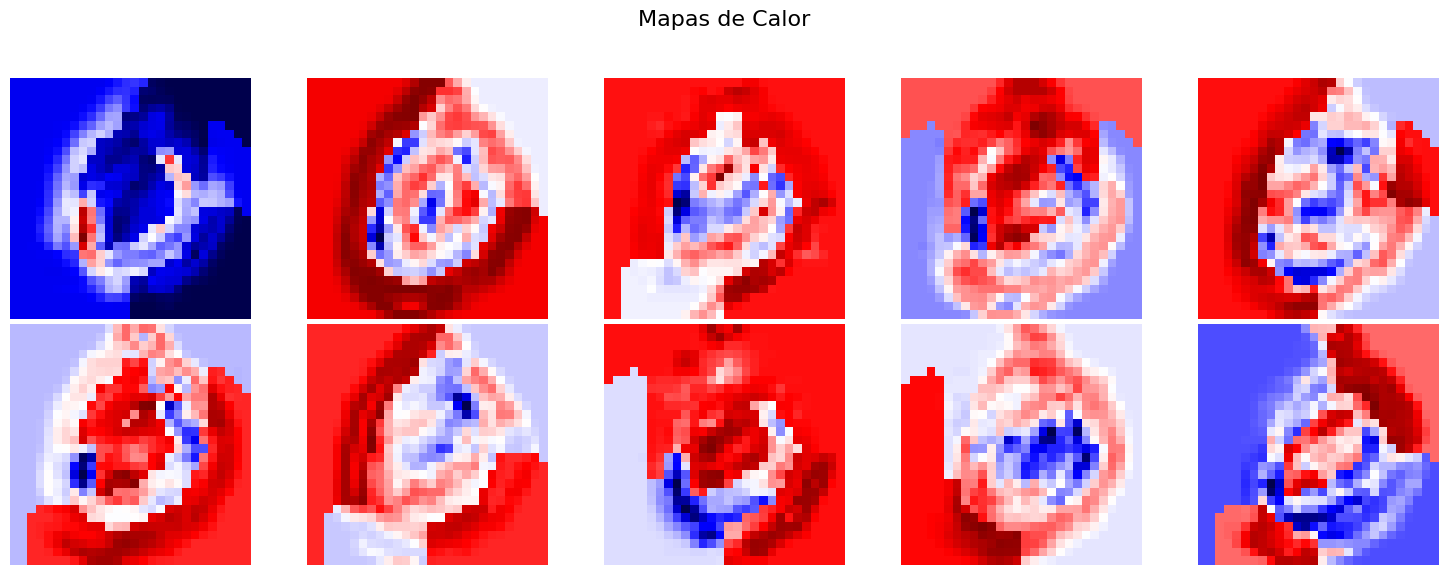

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 4
Indices mayores que 0.85: [428 456 484 512]
Suma clase objetivo: 3.623459232118263
Suma de otras clases: 10.53828797005111
IFI calculado: 3.094538048470714


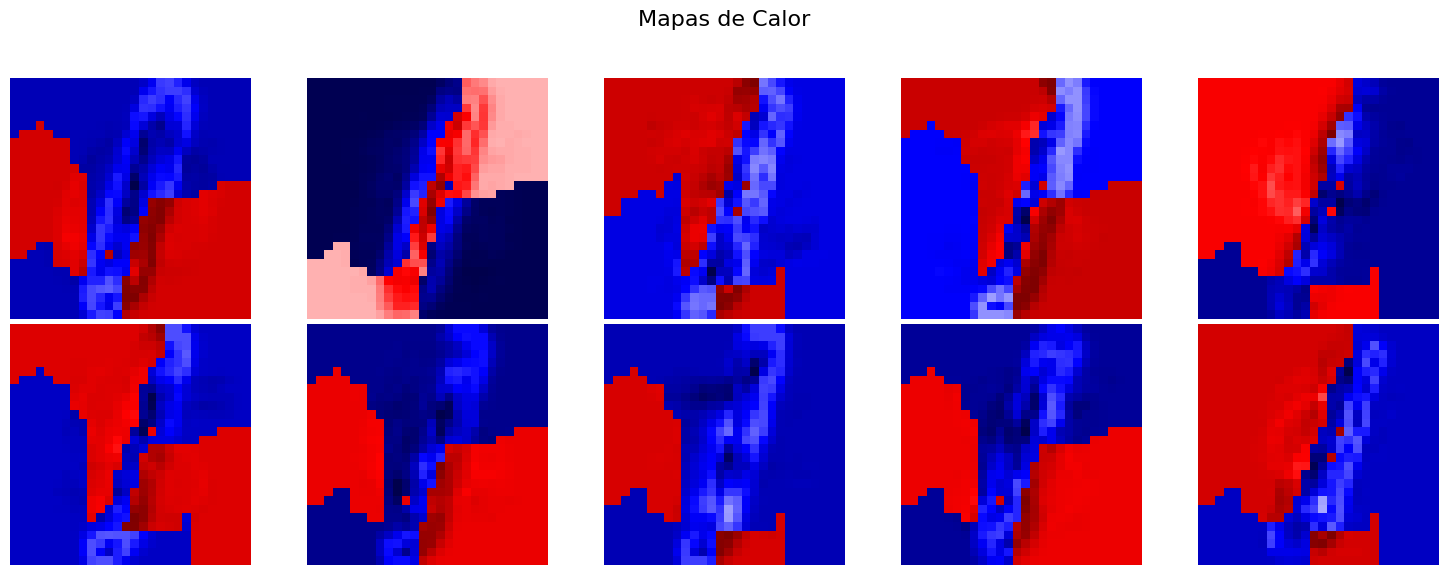

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 9
Indices mayores que 0.85: [323 350 351 378 406 434 461 462 489]
Suma clase objetivo: 8.306572304716656
Suma de otras clases: 12.305444040806174
IFI calculado: 6.075290781424915


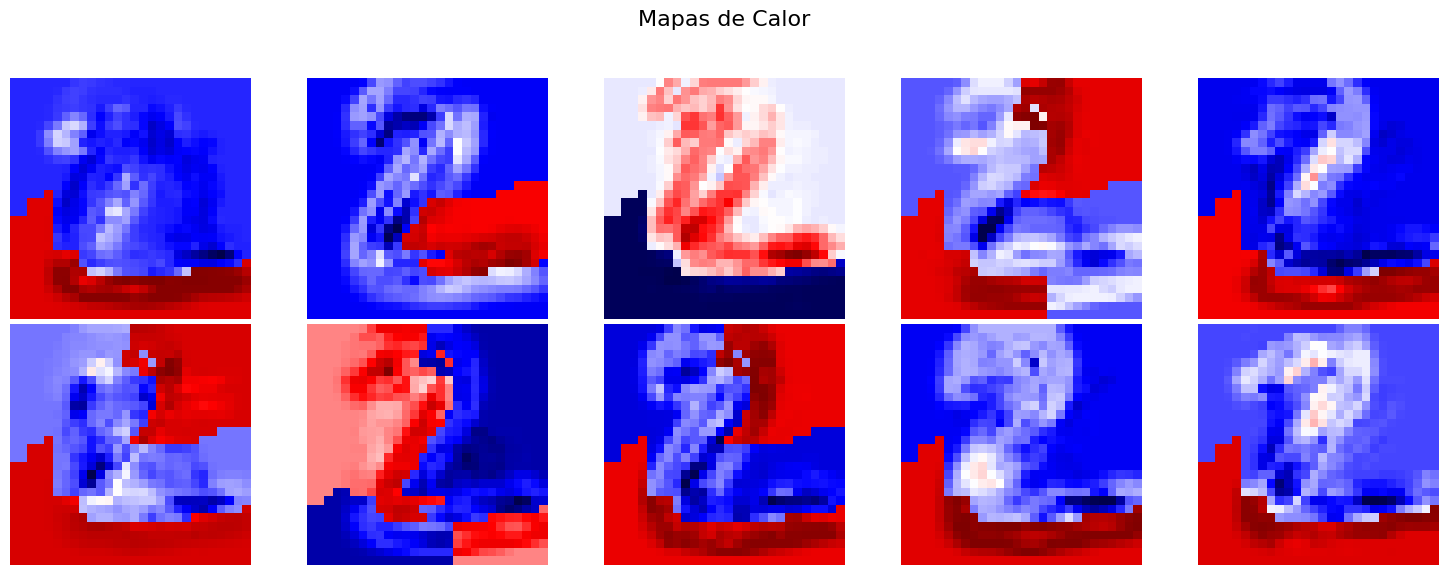

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 9
Indices mayores que 0.85: [485 486 513 579 580 581 582 583 584]
Suma clase objetivo: 8.263493921710124
Suma de otras clases: 16.87370341555858
IFI calculado: 4.407535409613525


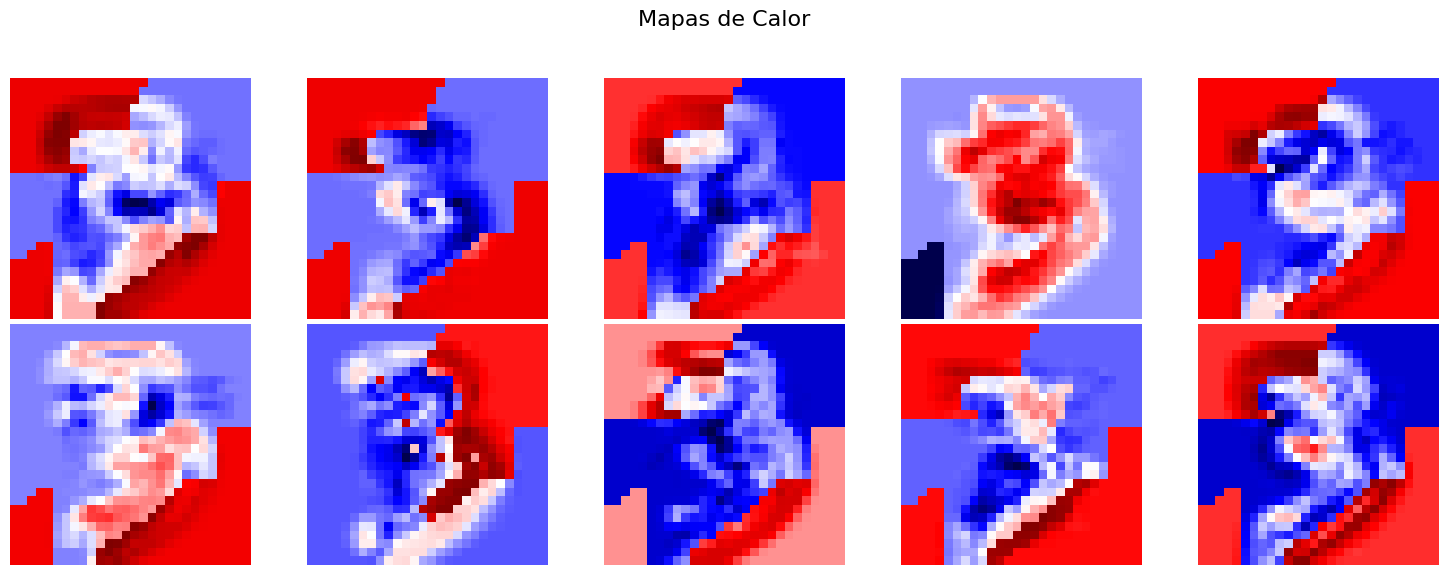

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 17
Indices mayores que 0.85: [232 376 404 405 406 407 408 409 431 432 433 434 460 461 462 463 628]
Suma clase objetivo: 15.545558921303424
Suma de otras clases: 52.84901407925081
IFI calculado: 2.6473536494347067


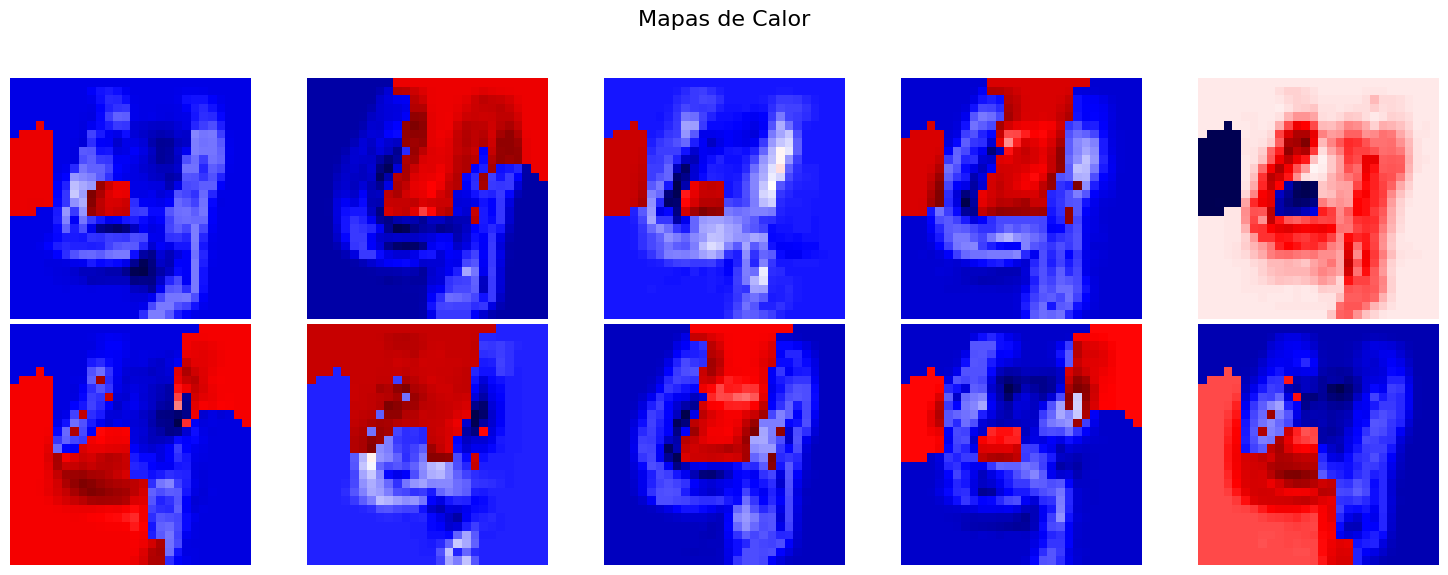

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 15
Indices mayores que 0.85: [179 180 206 207 208 234 235 236 262 289 316 344 428 456 605]
Suma clase objetivo: 13.509772982135644
Suma de otras clases: 48.82315889226424
IFI calculado: 2.490374641827728


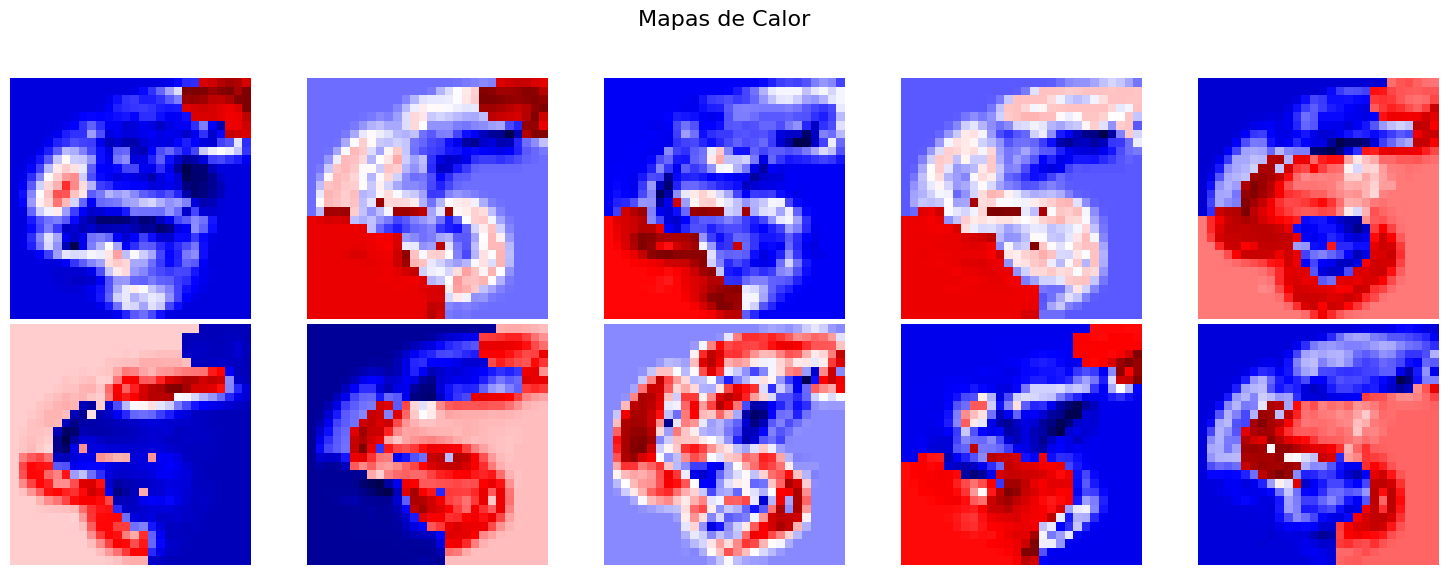

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [187 188 189 191 212 213 214 215 216 240 241 242]
Suma clase objetivo: 10.89835954997635
Suma de otras clases: 29.895316335441056
IFI calculado: 3.280956617057321


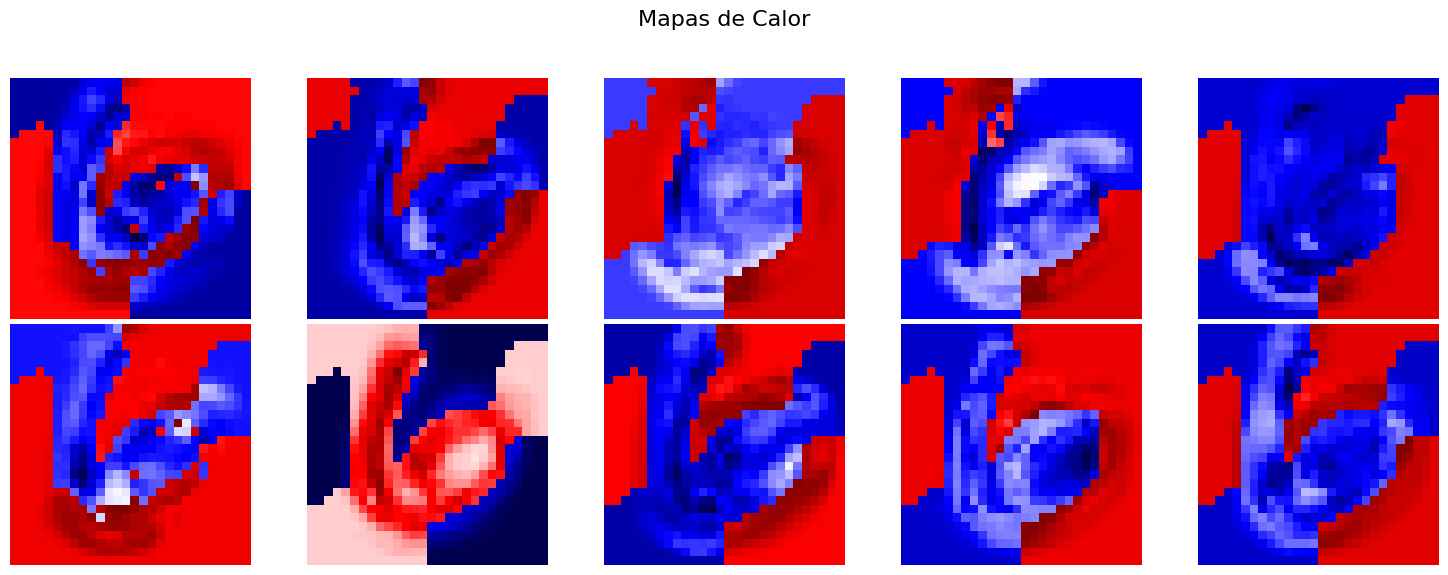

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 30
Indices mayores que 0.85: [ 95 123 150 177 178 205 206 233 260 261 288 316 344 371 372 399 400 427
 428 432 455 456 460 461 483 484 511 512 540 568]
Suma clase objetivo: 27.11156579111296
Suma de otras clases: 58.095211009136776
IFI calculado: 4.200072396357102


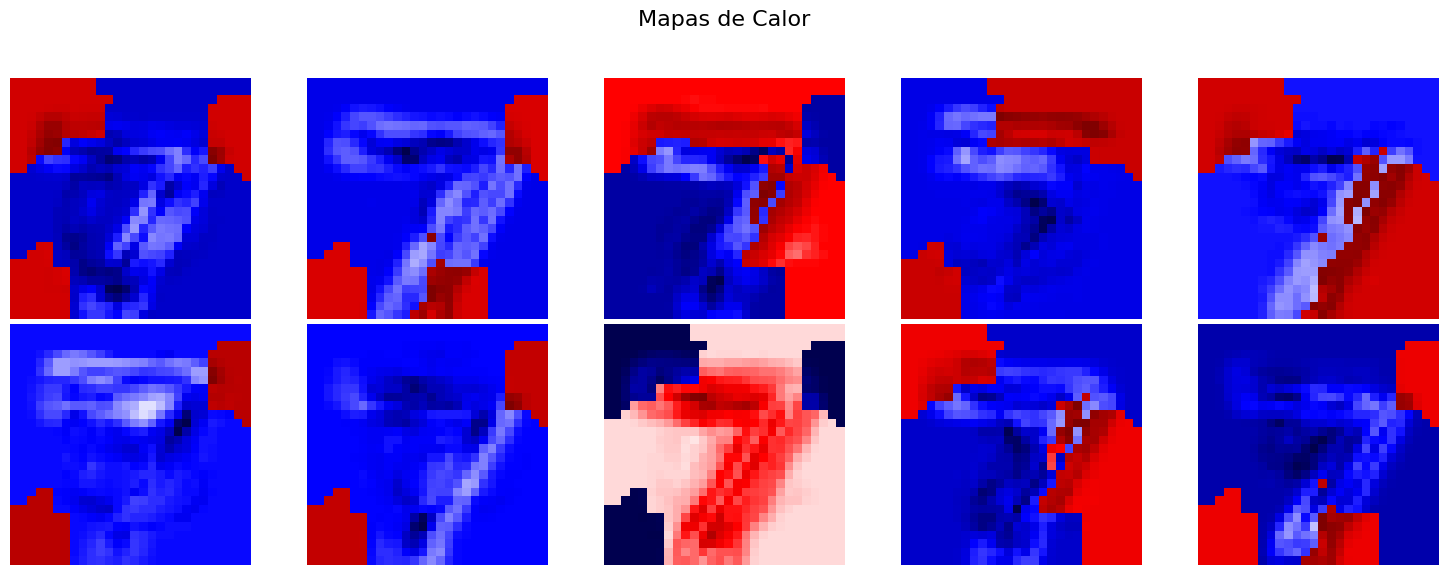

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [233 234 235 236 263 264 265 266 267 268 269 684]
Suma clase objetivo: 11.01062592774449
Suma de otras clases: 20.716472359118445
IFI calculado: 4.783422178828773


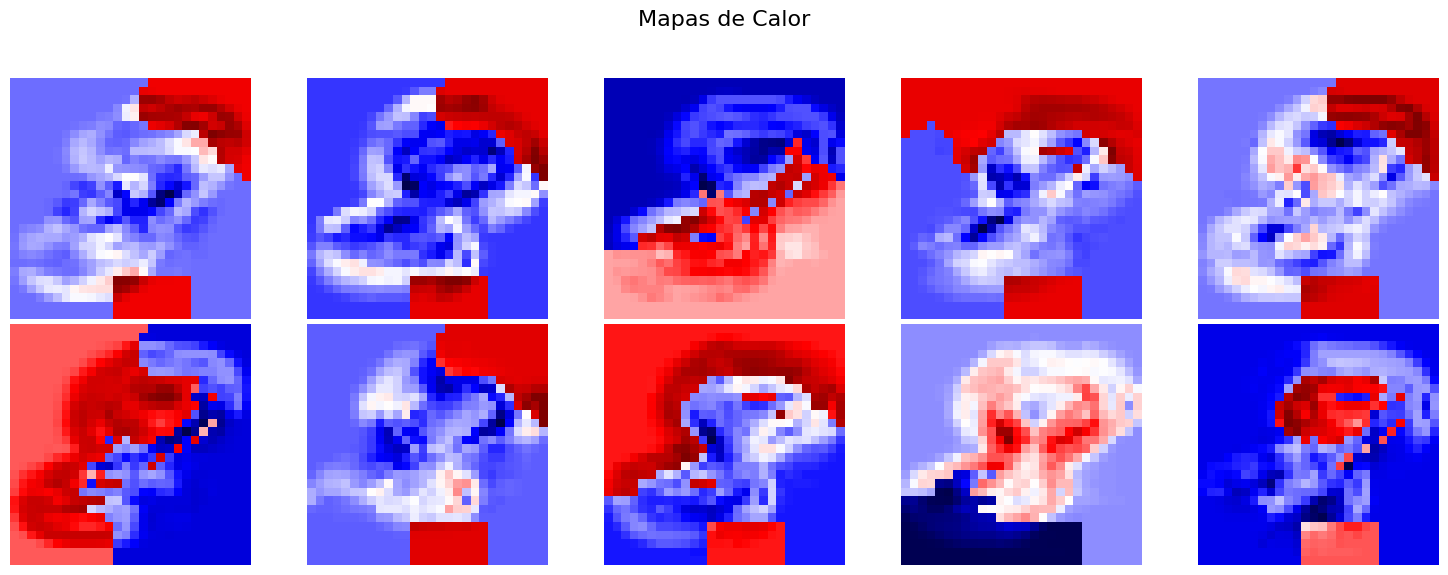

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 3
Indices mayores que 0.85: [347 348 376]
Suma clase objetivo: 2.8756059663209905
Suma de otras clases: 8.75500481437171
IFI calculado: 2.9560753244138778


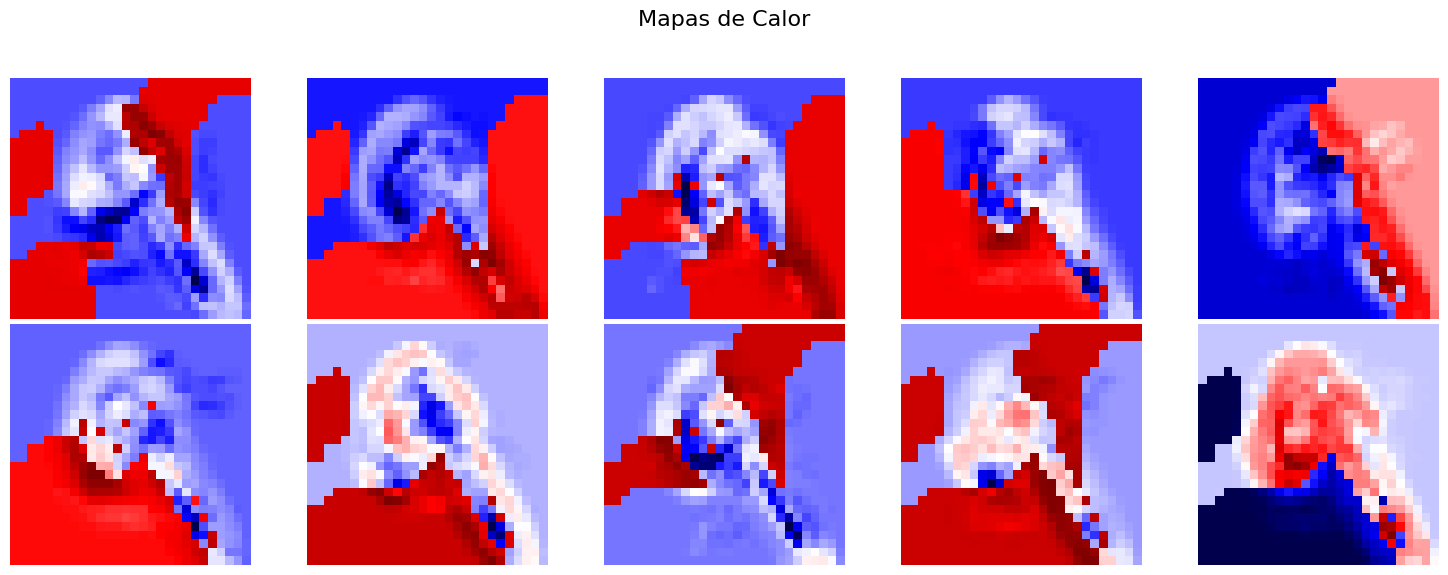

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [430 431 432 433 458 459 460 514 637 665 666 694]
Suma clase objetivo: 10.942821677245982
Suma de otras clases: 37.694099659522195
IFI calculado: 2.6127536135575187


In [14]:
# Use weighted sum
integrated_explanations_sum, lse_integrated_sum = owa_integrations.calculate_lse_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold_lse=0.85,
    method="weighted_sum"
)

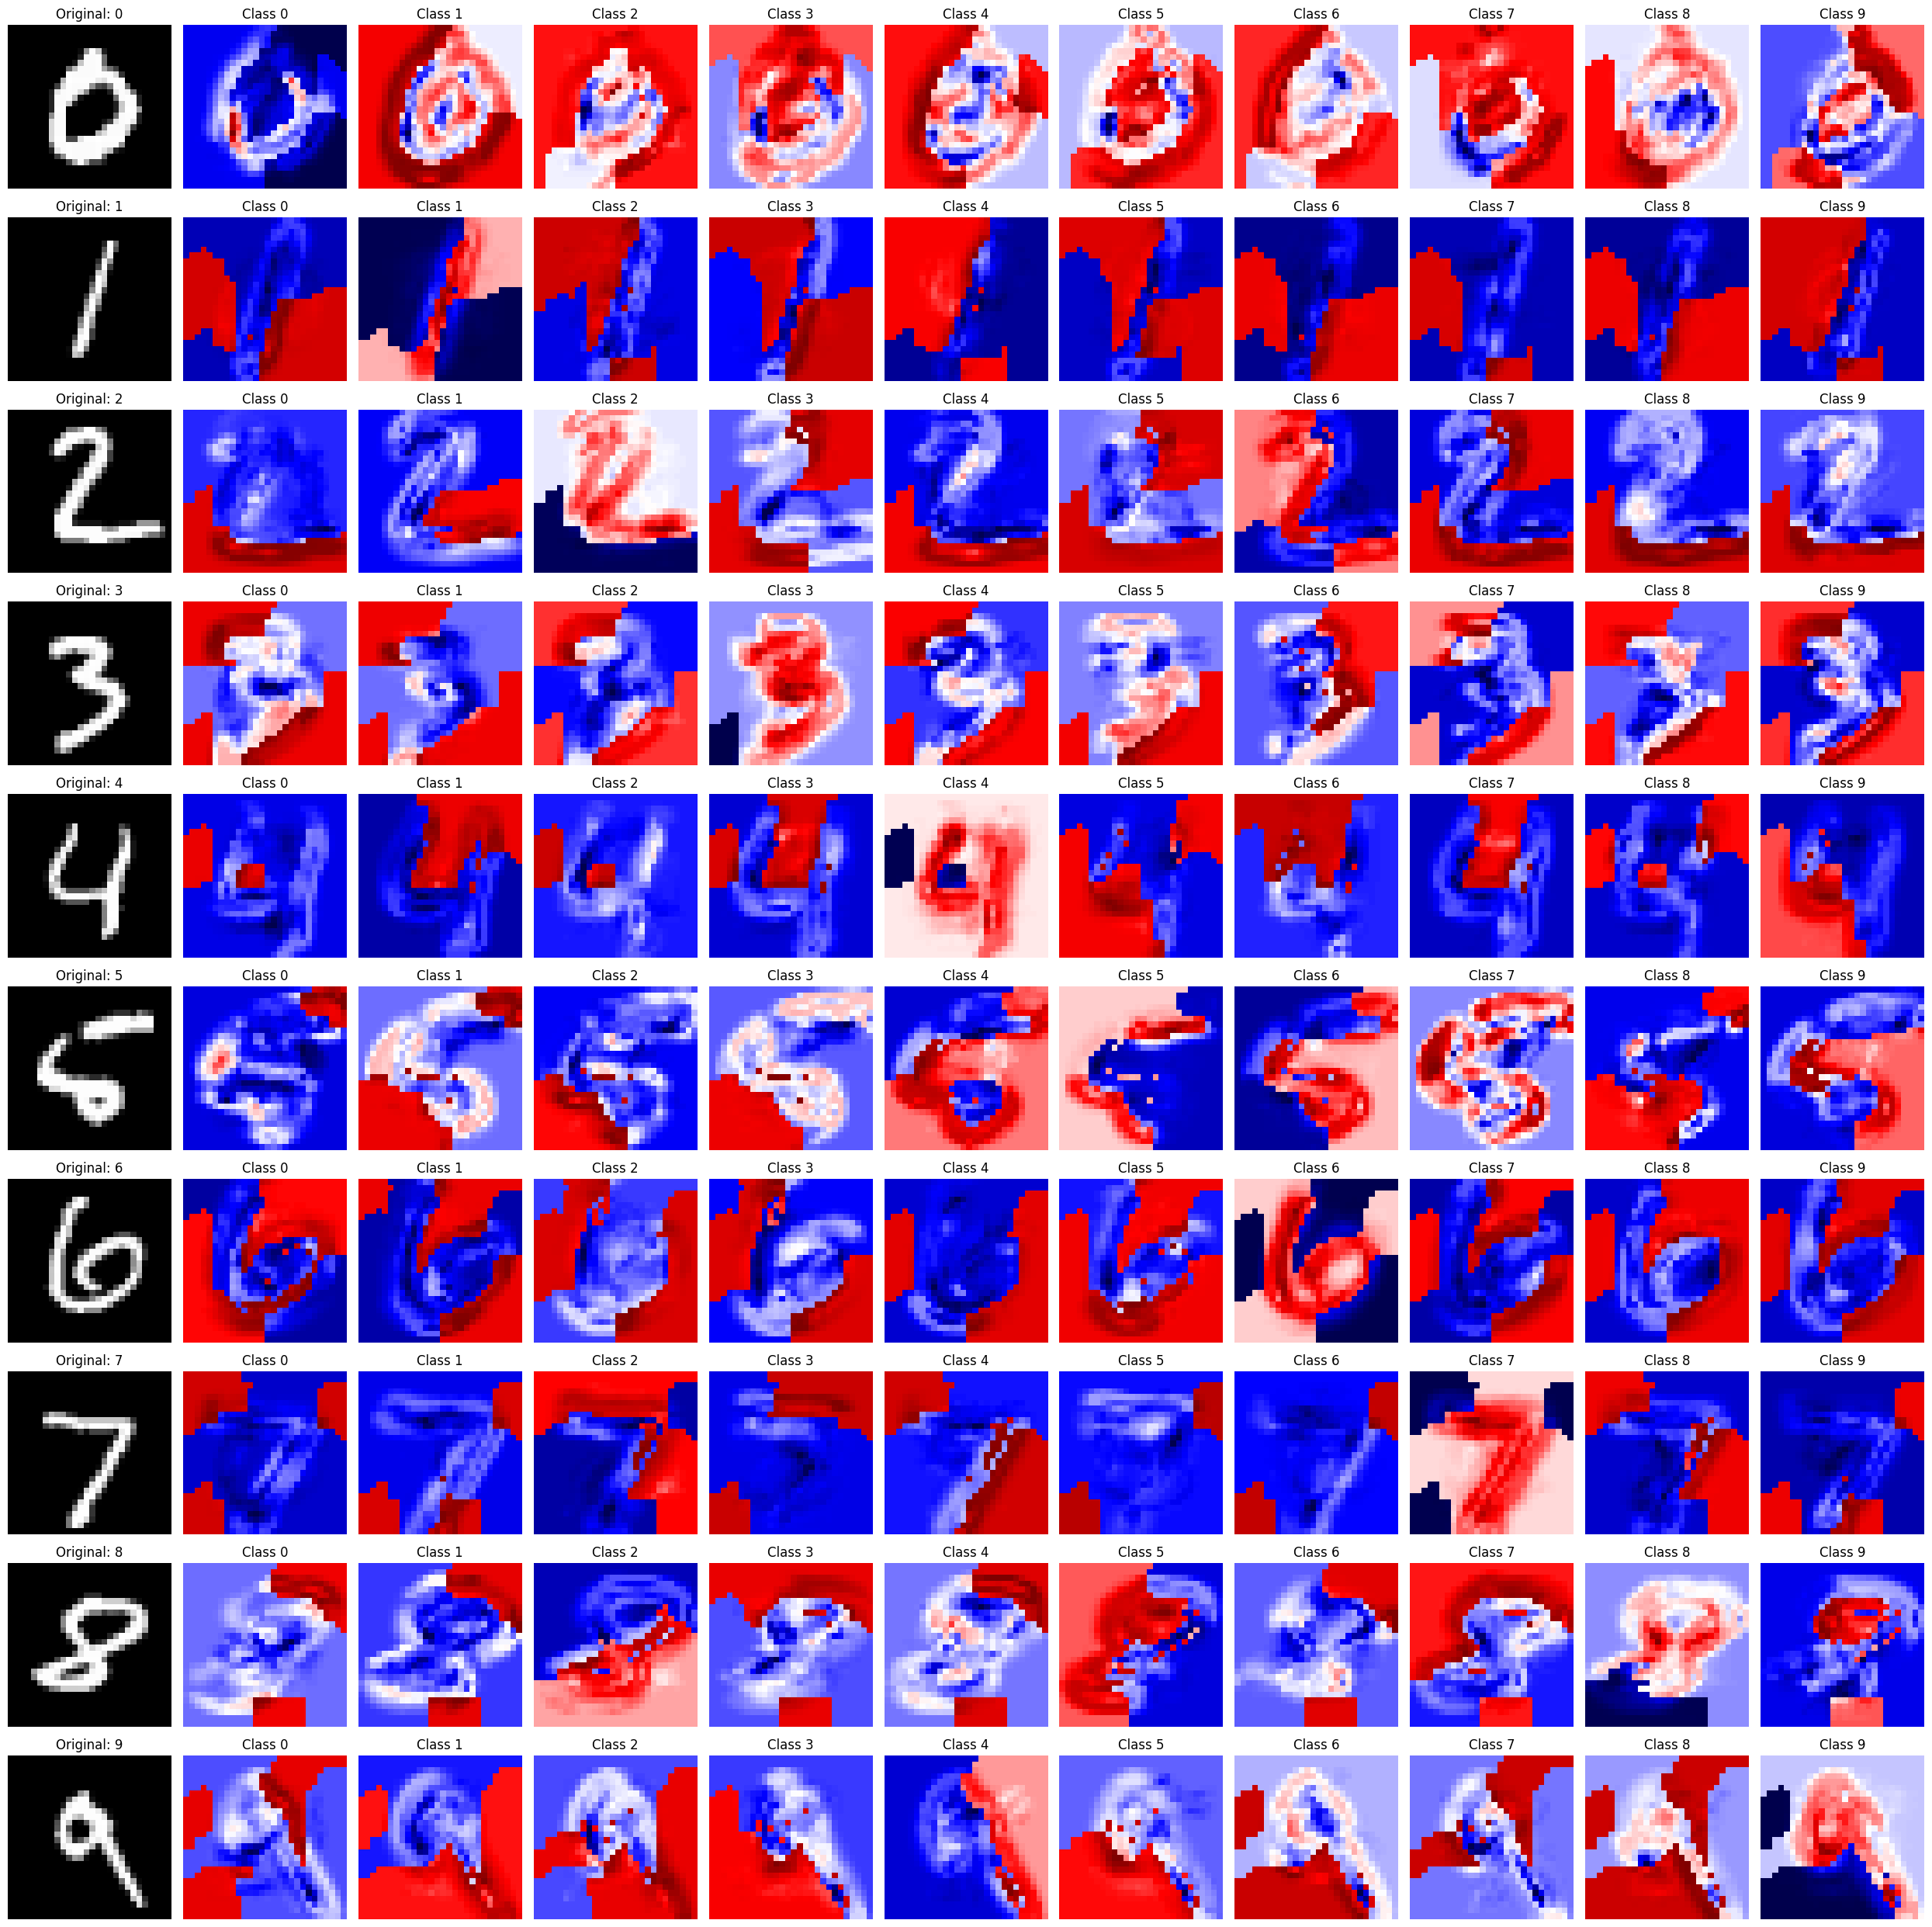

In [15]:
visualize_all_classes(integrated_explanations_sum, x_selected, y_selected)

In [16]:
# Use weighted average
# integrated_explanations_average, lse_integrated_average = owa_integrations.calculate_lse_integrated_explanations(
#     explanations_data=explanations_data,
#     y_selected=y_selected,
#     threshold_lse= 0.85,
#     method="weighted_average"
# )


In [17]:
# use simple average
# integrated_explanations_simple, lse_integrated_simple = owa_integrations.calculate_lse_integrated_explanations(
#     explanations_data=explanations_data,
#     y_selected=y_selected,
#     threshold_lse= 0.85,
#     method="simple_average"
# )

##UNION

In [18]:
# Execute the calculation to obtain the integrated explanations and integrated LSE
# Use weighted sum
integrated_explanations_union, lse_integrated_union = union_owa_integrations.calculate_lse_union_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold=0.85,
    operator="sum"
)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Use Max
# union_max_exp, union_max_lse = union_owa_integrations.calculate_lse_union_integrated_explanations(
#     new_explanations_data,
#     y_selected,
#     threshold=0.75,
#     operator="max"
#     )

##Intersección

In [20]:
#Use weighted sum
integrated_explanations_intersection, lse_integrated_intersection = intersection_owa_integrations.calculate_lse_intersection_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold = 0.85,
    operator = 'sum'
)

Output hidden; open in https://colab.research.google.com to view.

##Max


In [21]:
def calculate_max_per_pixel(explanations_data):
    """
    Calculates the pixel-wise maximum across all explanations for each image and class.
    Includes prints of dimensions and max/min values at each step.

    Args:
        explanations_data (list of dict): Contains explanations from the 4 methods.
                                          Each dict element contains 'explanations' and 'lse_value'.
                                          'explanations' has dimensions (10, 10, 28, 28).

    Returns:
        integrated_explanations (list of numpy.ndarray): List of integrated heatmaps using the maximum.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                # Add to the list of maps
                class_maps.append(normalized_map)

                # Print details of the processed map
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")#, "
                #       f"Min: {np.min(normalized_map):.4f}, Max: {np.max(normalized_map):.4f}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise maximum along axis 0 (across the 4 methods)
            max_map = np.max(stacked_maps, axis=0)  # Dimensions: (28, 28)

            # Print details of the integrated map
            print(f"    Integrated map: Shape: {max_map.shape}, "
                  f"Min: {np.min(max_map):.4f}, Max: {np.max(max_map):.4f}")

            # Save the integrated map per class
            image_maps.append(max_map)

        # Save the integrated maps for all classes of this image
        integrated_explanations.append(image_maps)

    return integrated_explanations

In [22]:
max_explanations = calculate_max_per_pixel(new_explanations_data)


Processing image 1/10...
  Class 1/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0893, Max: 1.0000
  Class 2/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.5635, Max: 1.0000
  Class 3/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.3422, Max: 1.0000
  Class 4/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.6069, Max: 1.0000
  Class 5/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.4813, Max: 1

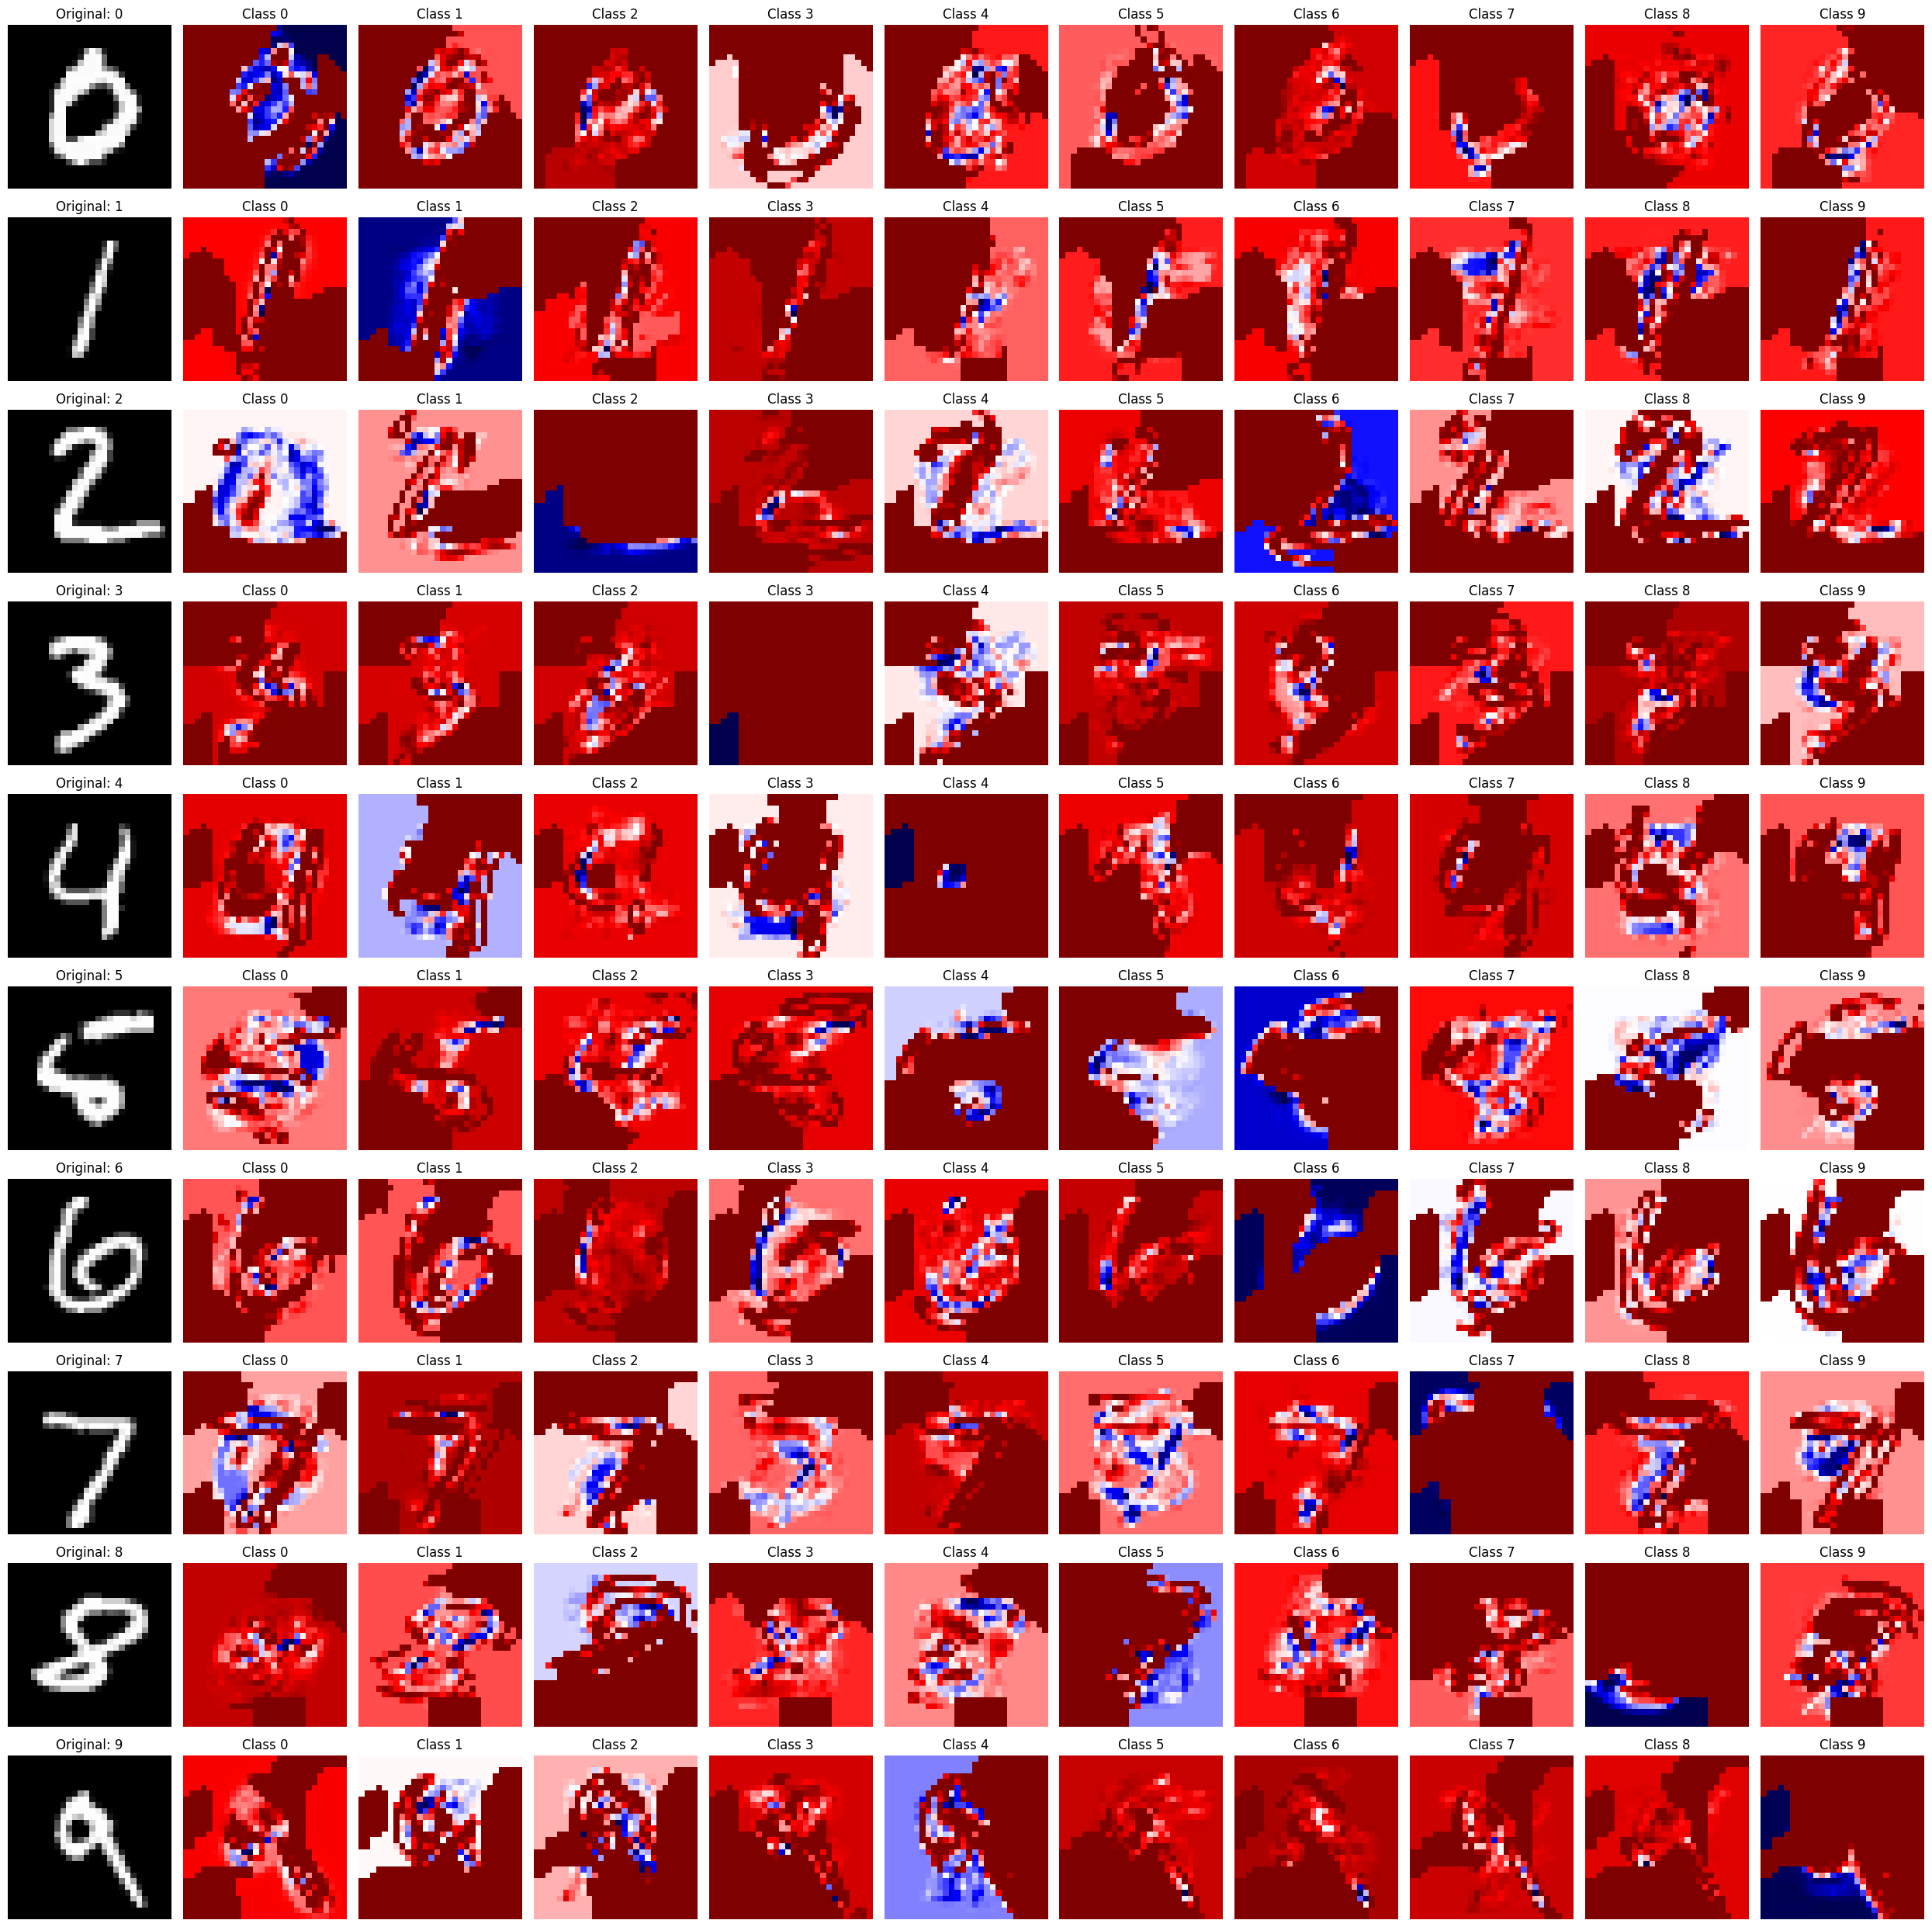

In [23]:
visualize_all_classes(max_explanations,x_selected, y_selected)

In [24]:
def calculate_lse_per_image(integrated_explanations, y_selected):
    """
    Calculates the LSE value for each image based on the integrated heatmaps and the selected class.

    Args:
        integrated_explanations (list of list): List of integrated heatmaps (10 images, 10 classes, 28, 28).
        y_selected (list of int): List of selected classes for each image (10 values, one per image).

    Returns:
        lse_values (list of float): List of calculated LSE values for the 10 images.
    """
    lse_values = []

    for image_idx, class_idx in enumerate(y_selected):
        # Get the integrated map for the selected class of this image
        image_map = integrated_explanations[image_idx]  # Dimensions: (10, 28, 28)

        # Calculate the LSE value for this image and class
        lse_value = lse_calculate(image_map, class_idx, 0.85)

        # Store the LSE value
        lse_values.append(lse_value)

        # Print calculation details
        print(f"Image {image_idx + 1}, Class {class_idx}: LSE Value: {lse_value:.4f}")

    return lse_values

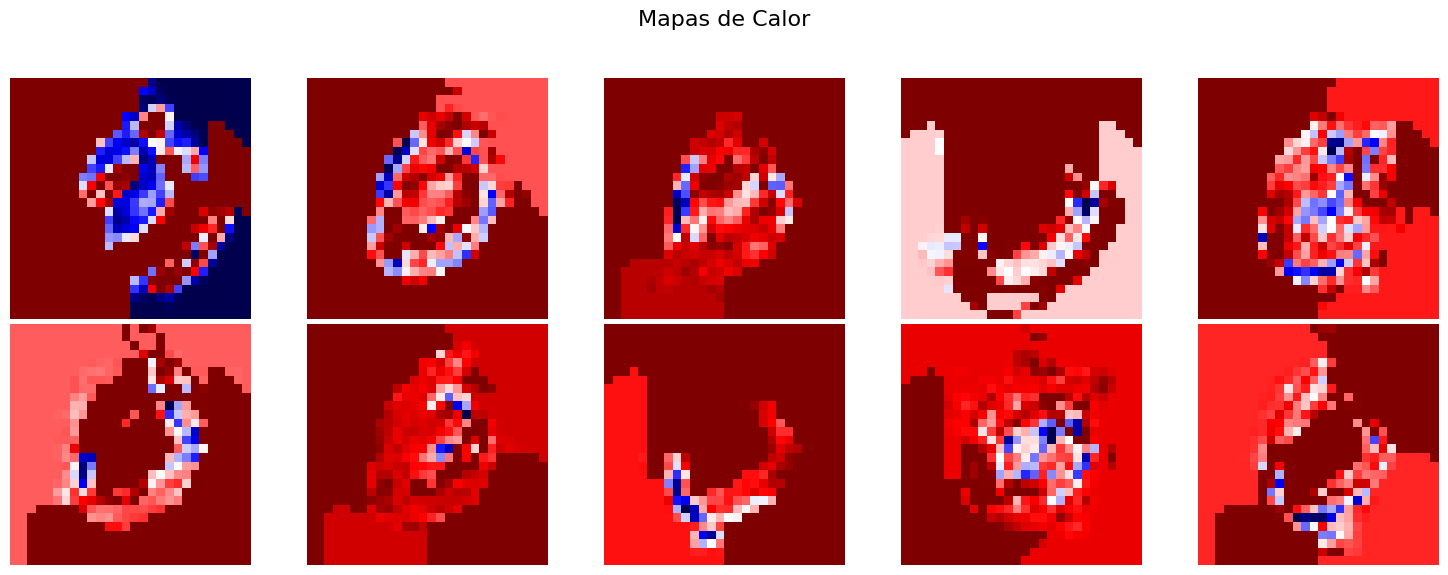

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.08934108167886734
Mapa 1: Max: 1.0, Min: 0.563485561443267
Mapa 2: Max: 1.0, Min: 0.3422459893048128
Mapa 3: Max: 1.0, Min: 0.6069167406938949
Mapa 4: Max: 1.0, Min: 0.48128342245989303
Mapa 5: Max: 1.0, Min: 0.3529411764705882
Mapa 6: Max: 1.0, Min: 0.4278074866310161
Mapa 7: Max: 1.0, Min: 0.08421915024518967
Mapa 8: Max: 1.0, Min: 0.330051451921463
Mapa 9: Max: 1.0, Min: 0.4955403618587871
Cantidad de rasgos mayores que 0.85: 487
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98 112 113 114 115 116 117 118 

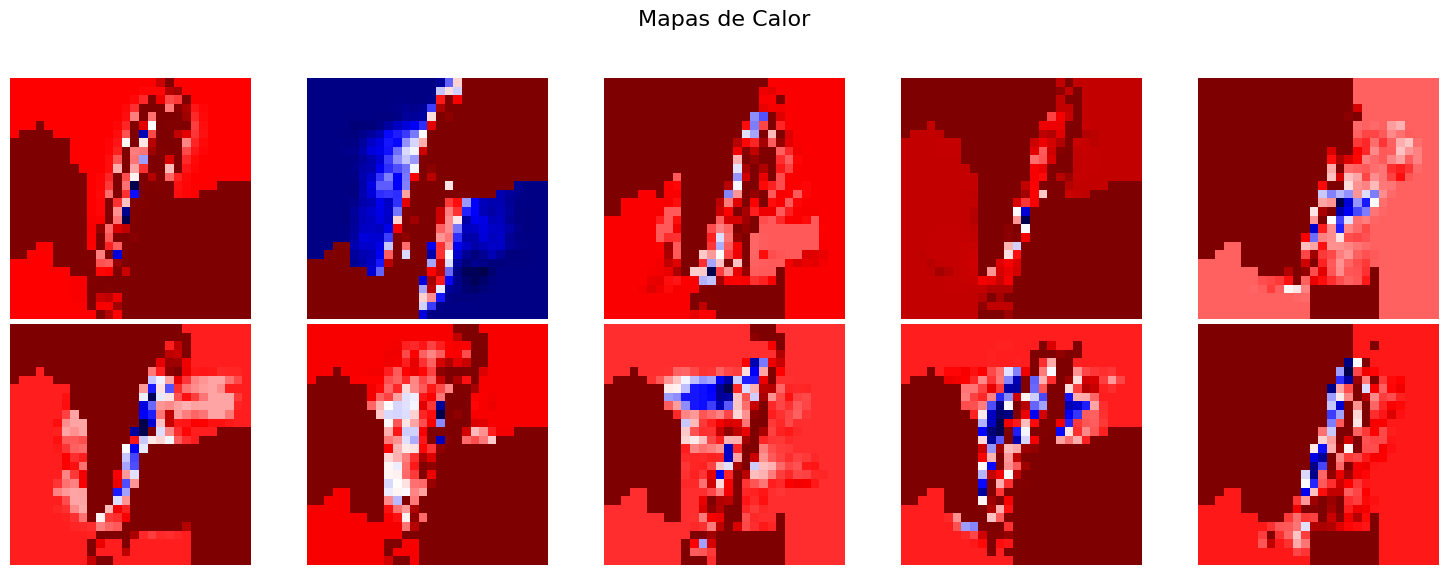

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.5900506377220154
Mapa 1: Max: 1.0, Min: 0.04600983566202688
Mapa 2: Max: 1.0, Min: 0.3422459893048128
Mapa 3: Max: 1.0, Min: 0.1750255525112152
Mapa 4: Max: 1.0, Min: 0.21925133689839577
Mapa 5: Max: 1.0, Min: 0.4278074866310161
Mapa 6: Max: 1.0, Min: 0.4539467919894535
Mapa 7: Max: 1.0, Min: 0.3850267379679144
Mapa 8: Max: 1.0, Min: 0.5544986128807068
Mapa 9: Max: 1.0, Min: 0.28074866310160423
Cantidad de rasgos mayores que 0.85: 302
Indices mayores que 0.85: [ 18  19  20  21  22  23  24  25  26  27  46  47  48  49  50  51  52  53
  54  55  72  74  75  76  77  78  79  80  81  82  83  99 100 101 102 103
 104 105 106 107 108 109 110 111 127 128 129 130 131 132 133 134 135 136
 137 138 139 155 156 157 158 159 160 161 162 163 164 16

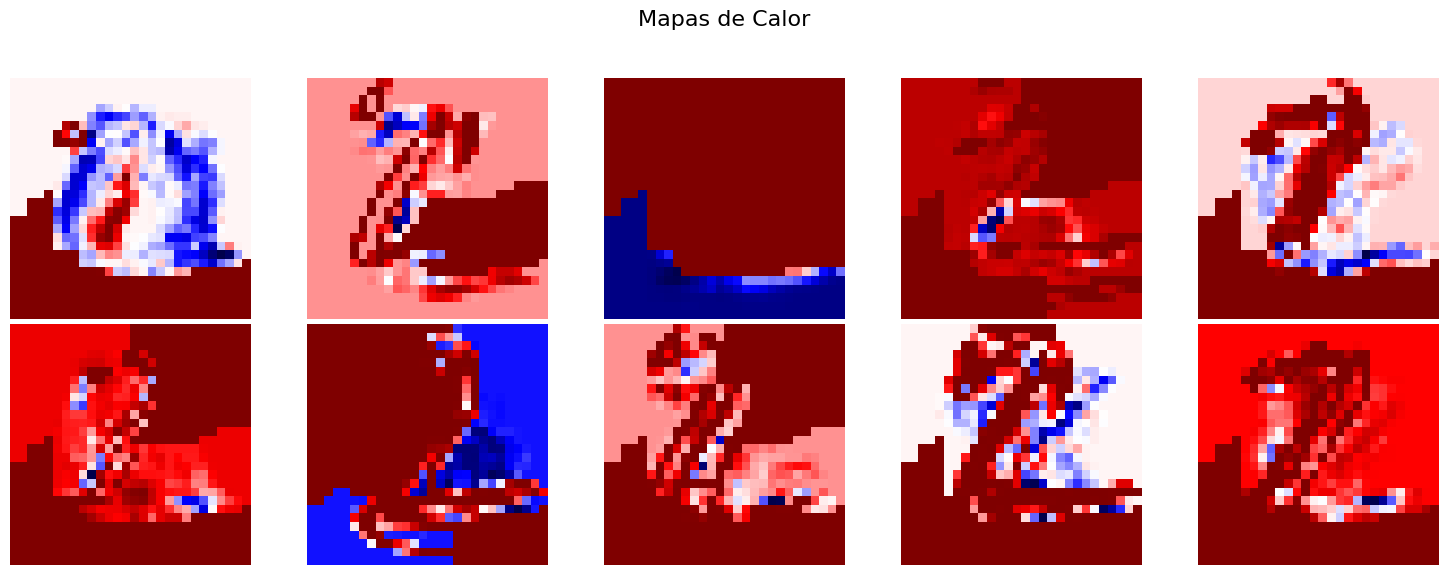

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.4050983786582947
Mapa 1: Max: 1.0, Min: 0.3422459893048128
Mapa 2: Max: 1.0, Min: 0.2055209000928633
Mapa 3: Max: 1.0, Min: 0.20588235294117646
Mapa 4: Max: 1.0, Min: 0.2503109574317932
Mapa 5: Max: 1.0, Min: 0.15775401069518716
Mapa 6: Max: 1.0, Min: 0.42778392123656633
Mapa 7: Max: 1.0, Min: 0.3480455279350281
Mapa 8: Max: 1.0, Min: 0.6310160427807486
Mapa 9: Max: 1.0, Min: 0.23799185454845428
Cantidad de rasgos mayores que 0.85: 585
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  

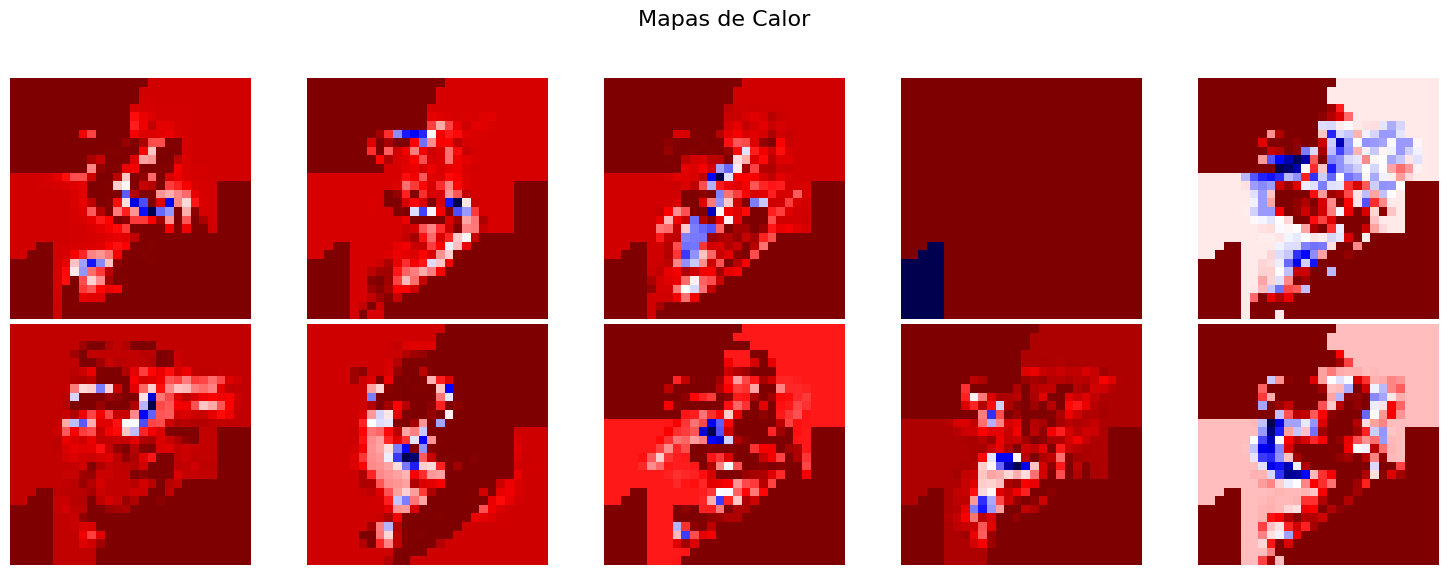

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.4216799736022949
Mapa 1: Max: 1.0, Min: 0.24720434844493866
Mapa 2: Max: 1.0, Min: 0.39572192513368987
Mapa 3: Max: 1.0, Min: 0.1626066012094775
Mapa 4: Max: 1.0, Min: 0.2895505428314209
Mapa 5: Max: 1.0, Min: 0.20588235294117646
Mapa 6: Max: 1.0, Min: 0.3378123342990875
Mapa 7: Max: 1.0, Min: 0.22670528292655945
Mapa 8: Max: 1.0, Min: 0.2310096248280736
Mapa 9: Max: 1.0, Min: 0.30481283422459887
Cantidad de rasgos mayores que 0.85: 744
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66 

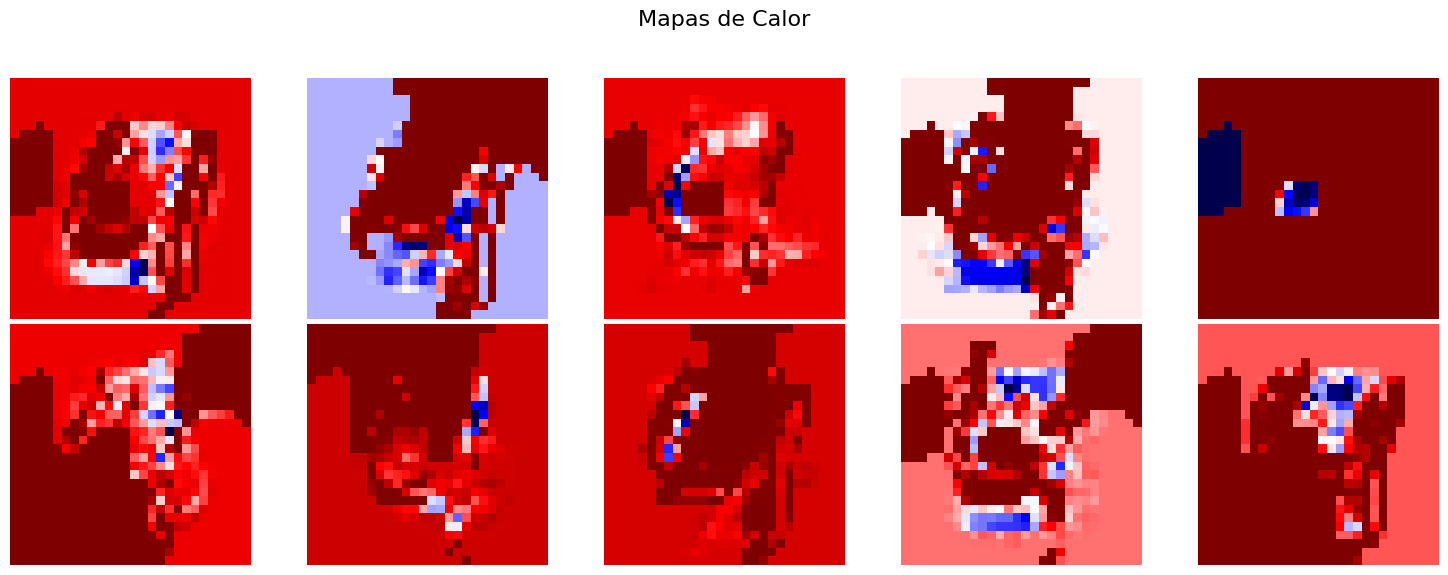

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.31196403164846087
Mapa 1: Max: 1.0, Min: 0.6147213558105079
Mapa 2: Max: 1.0, Min: 0.17112299465240638
Mapa 3: Max: 1.0, Min: 0.625179648399353
Mapa 4: Max: 1.0, Min: 0.12161425697514587
Mapa 5: Max: 1.0, Min: 0.4591744196726303
Mapa 6: Max: 1.0, Min: 0.049788378179073334
Mapa 7: Max: 1.0, Min: 0.38770053475935834
Mapa 8: Max: 1.0, Min: 0.30317538975102126
Mapa 9: Max: 1.0, Min: 0.2940611955541374
Cantidad de rasgos mayores que 0.85: 717
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66

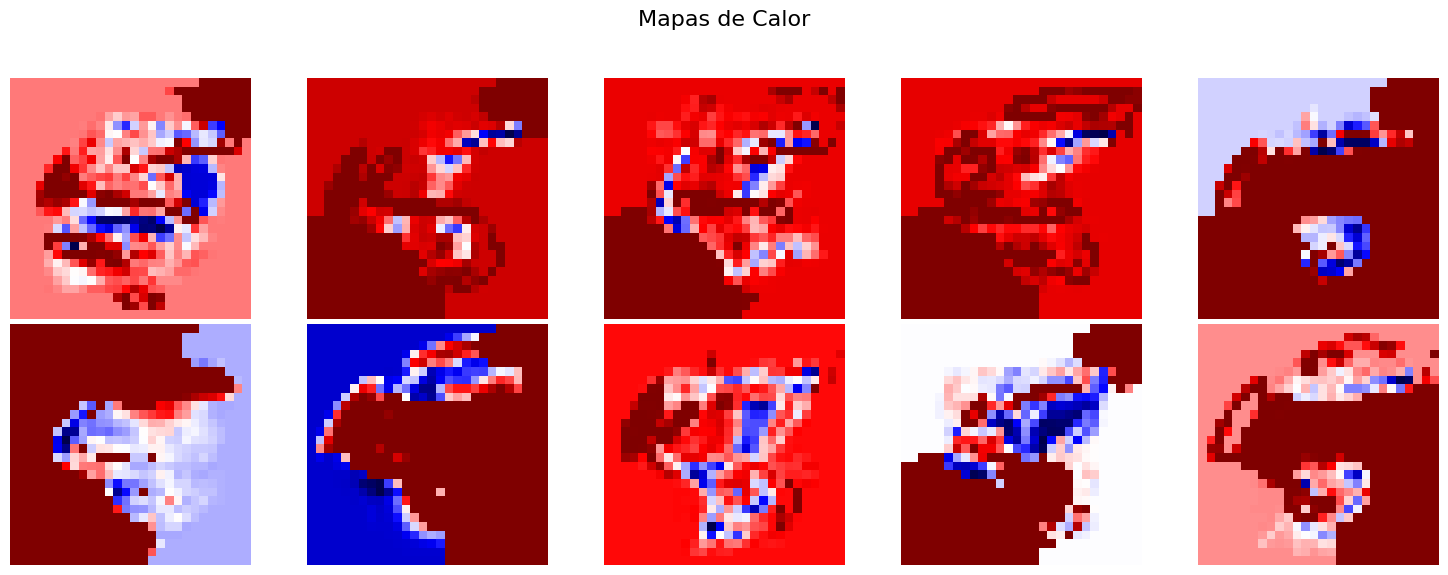

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.3117990701535203
Mapa 1: Max: 1.0, Min: 0.24139760434627533
Mapa 2: Max: 1.0, Min: 0.4992504119873047
Mapa 3: Max: 1.0, Min: 0.2804975211620331
Mapa 4: Max: 1.0, Min: 0.44115804784809826
Mapa 5: Max: 1.0, Min: 0.09037181735038757
Mapa 6: Max: 1.0, Min: 0.15243948996067047
Mapa 7: Max: 1.0, Min: 0.474678635597229
Mapa 8: Max: 1.0, Min: 0.35904788970947266
Mapa 9: Max: 1.0, Min: 0.37433155080213903
Cantidad de rasgos mayores que 0.85: 414
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  84  85  86  87  88 

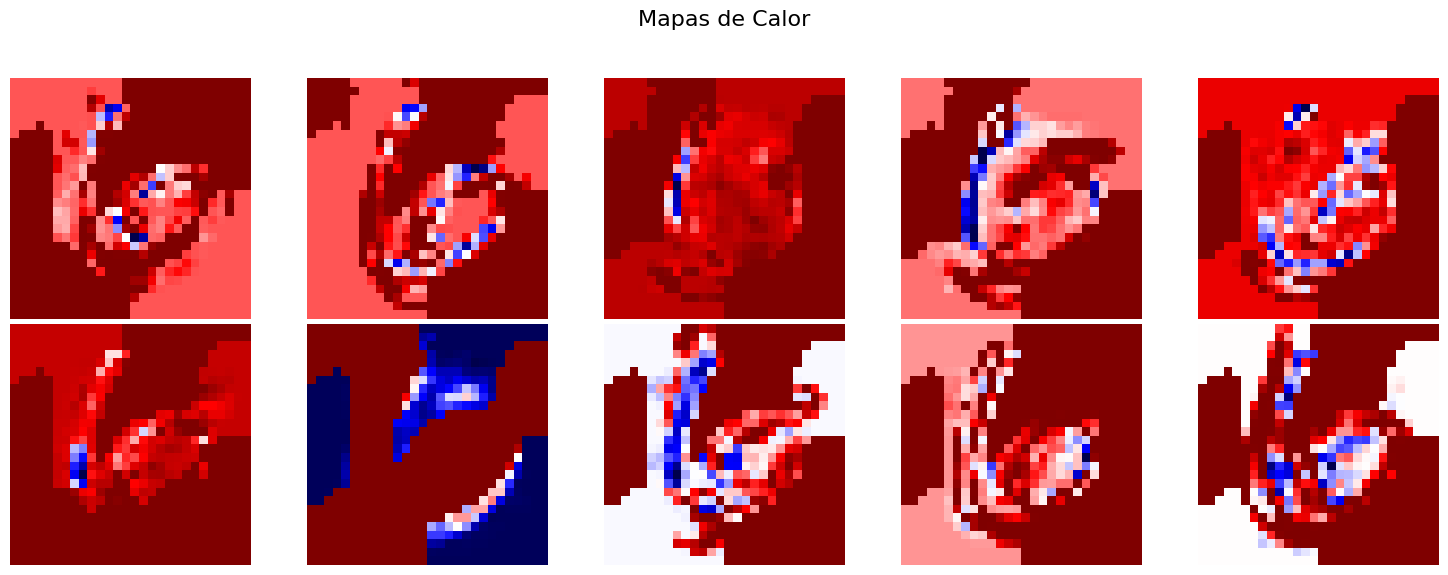

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.3243415057659149
Mapa 1: Max: 1.0, Min: 0.47058823529411764
Mapa 2: Max: 1.0, Min: 0.12032085561497327
Mapa 3: Max: 1.0, Min: 0.14705882352941174
Mapa 4: Max: 1.0, Min: 0.2547744810581207
Mapa 5: Max: 1.0, Min: 0.07332507520914078
Mapa 6: Max: 1.0, Min: 0.2370515730914387
Mapa 7: Max: 1.0, Min: 0.3409349152558864
Mapa 8: Max: 1.0, Min: 0.44519322831390307
Mapa 9: Max: 1.0, Min: 0.4227039748583526
Cantidad de rasgos mayores que 0.85: 456
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  28  29  30  31  32
  33  34  35  36  37  38  39  40  56  57  58  59  60  61  62  63  64  65
  66  67  68  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97 107 108 109 110 111 112 113 114 115 116 

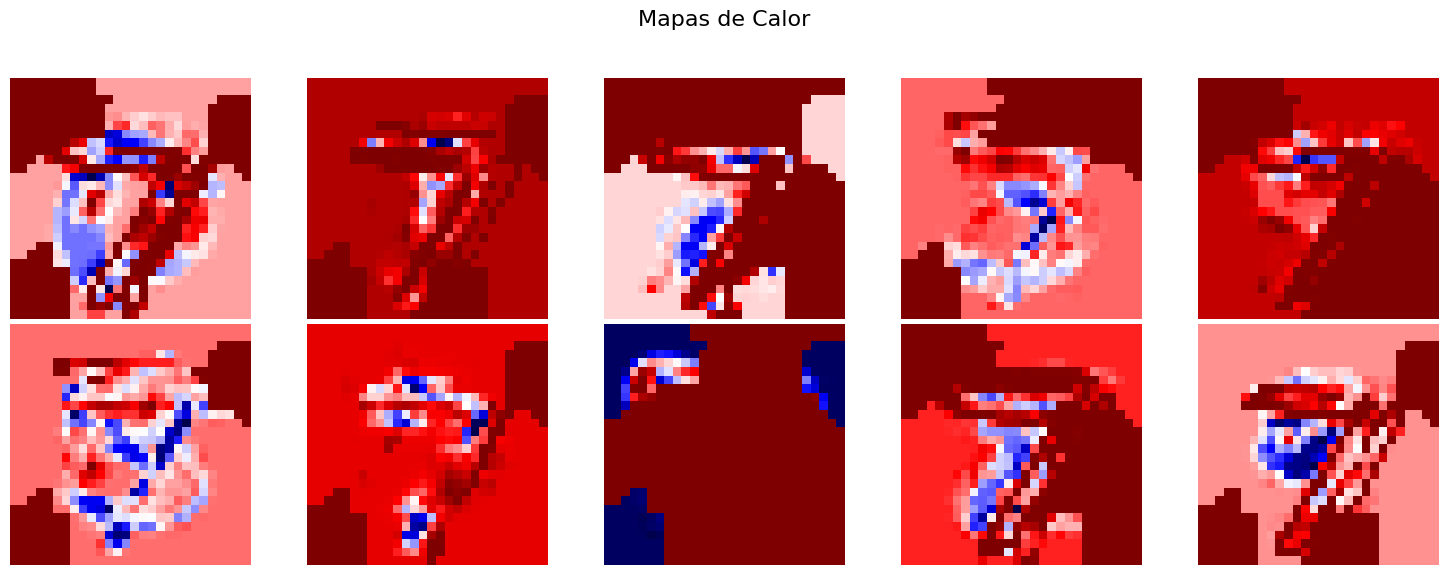

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.47058823529411764
Mapa 1: Max: 1.0, Min: 0.5219683299277105
Mapa 2: Max: 1.0, Min: 0.2871755361557007
Mapa 3: Max: 1.0, Min: 0.15775401069518716
Mapa 4: Max: 1.0, Min: 0.4411764705882353
Mapa 5: Max: 1.0, Min: 0.48128342245989303
Mapa 6: Max: 1.0, Min: 0.44703102111816406
Mapa 7: Max: 1.0, Min: 0.10239596629614768
Mapa 8: Max: 1.0, Min: 0.3204831355214227
Mapa 9: Max: 1.0, Min: 0.4134270548285937
Cantidad de rasgos mayores que 0.85: 609
Indices mayores que 0.85: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  68  69  70  71  72  73  74  75  76  77  78  79  95  96  97  98  99 100
 101 102 103 104 105 106 123 124 125 126 127 128 129 

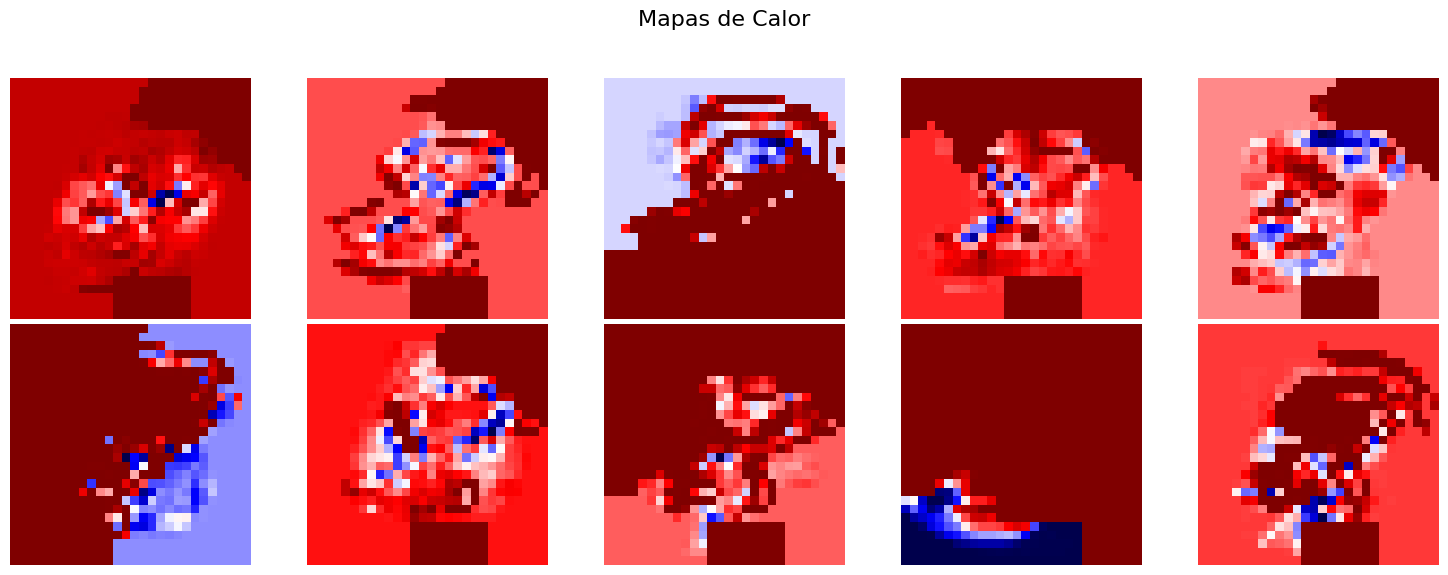

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.21925133689839577
Mapa 1: Max: 1.0, Min: 0.4491978609625668
Mapa 2: Max: 1.0, Min: 0.49562686370630554
Mapa 3: Max: 1.0, Min: 0.3422459893048128
Mapa 4: Max: 1.0, Min: 0.31550802139037437
Mapa 5: Max: 1.0, Min: 0.6521515504878231
Mapa 6: Max: 1.0, Min: 0.40641711229946526
Mapa 7: Max: 1.0, Min: 0.5026737967914439
Mapa 8: Max: 1.0, Min: 0.14365984743291862
Mapa 9: Max: 1.0, Min: 0.497008478506179
Cantidad de rasgos mayores que 0.85: 644
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  

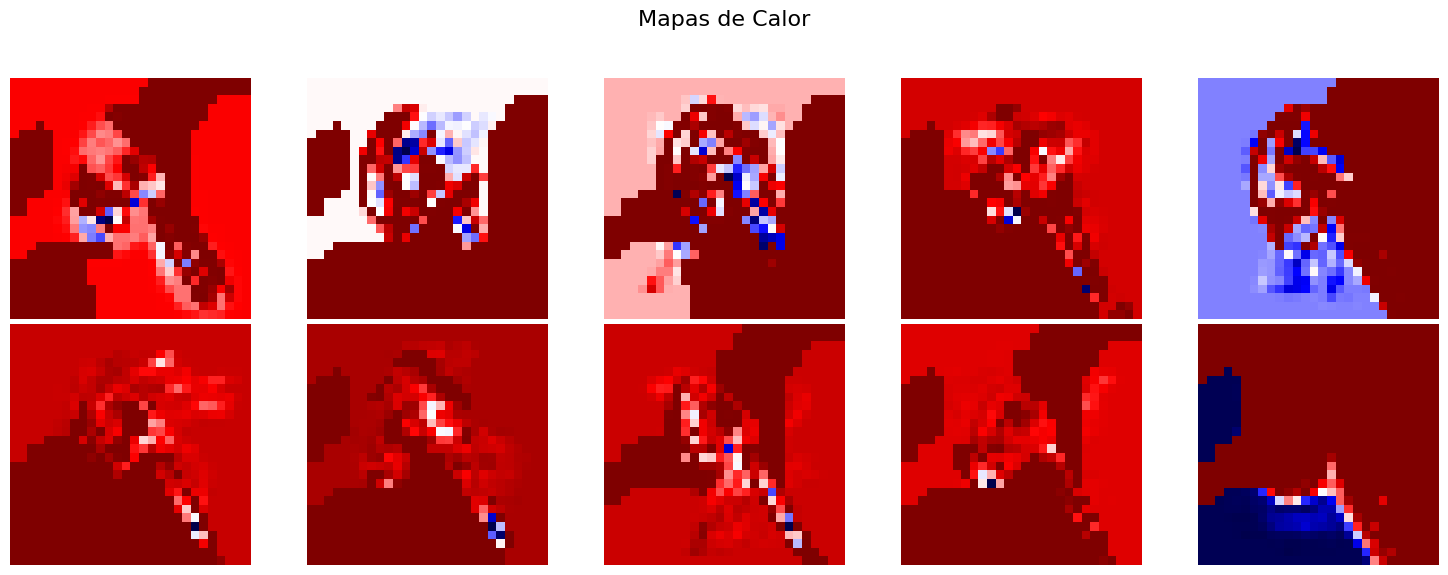

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.40641711229946526
Mapa 1: Max: 1.0, Min: 0.5013570785522461
Mapa 2: Max: 1.0, Min: 0.7023894190788269
Mapa 3: Max: 1.0, Min: 0.5401069518716579
Mapa 4: Max: 1.0, Min: 0.4900180899415605
Mapa 5: Max: 1.0, Min: 0.17112299465240638
Mapa 6: Max: 1.0, Min: 0.18951109051704407
Mapa 7: Max: 1.0, Min: 0.3663792014122009
Mapa 8: Max: 1.0, Min: 0.2433155080213904
Mapa 9: Max: 1.0, Min: 0.07513196679240791
Cantidad de rasgos mayores que 0.85: 574
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  

In [25]:
# Calculate LSE values using the integrated maps
lse_values_max = calculate_lse_per_image(integrated_explanations=max_explanations, y_selected=y_selected)

##MIN

In [26]:
def calculate_min_per_pixel(explanations_data):
    """
    Calculates the pixel-wise minimum across all explanations for each image and class.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                class_maps.append(normalized_map)
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise minimum along axis 0 (across the 4 methods)
            min_map = np.min(stacked_maps, axis=0)  # Dimensions: (28, 28)

            print(f"    Integrated map: Shape: {min_map.shape}, "
                  f"Min: {np.min(min_map):.4f}, Max: {np.max(min_map):.4f}")

            # Save the integrated map per class
            image_maps.append(min_map)

        integrated_explanations.append(image_maps)

    return integrated_explanations


Processing image 1/10...
  Class 1/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8885
  Class 2/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8584
  Class 3/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8974
  Class 4/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8889
  Class 5/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0

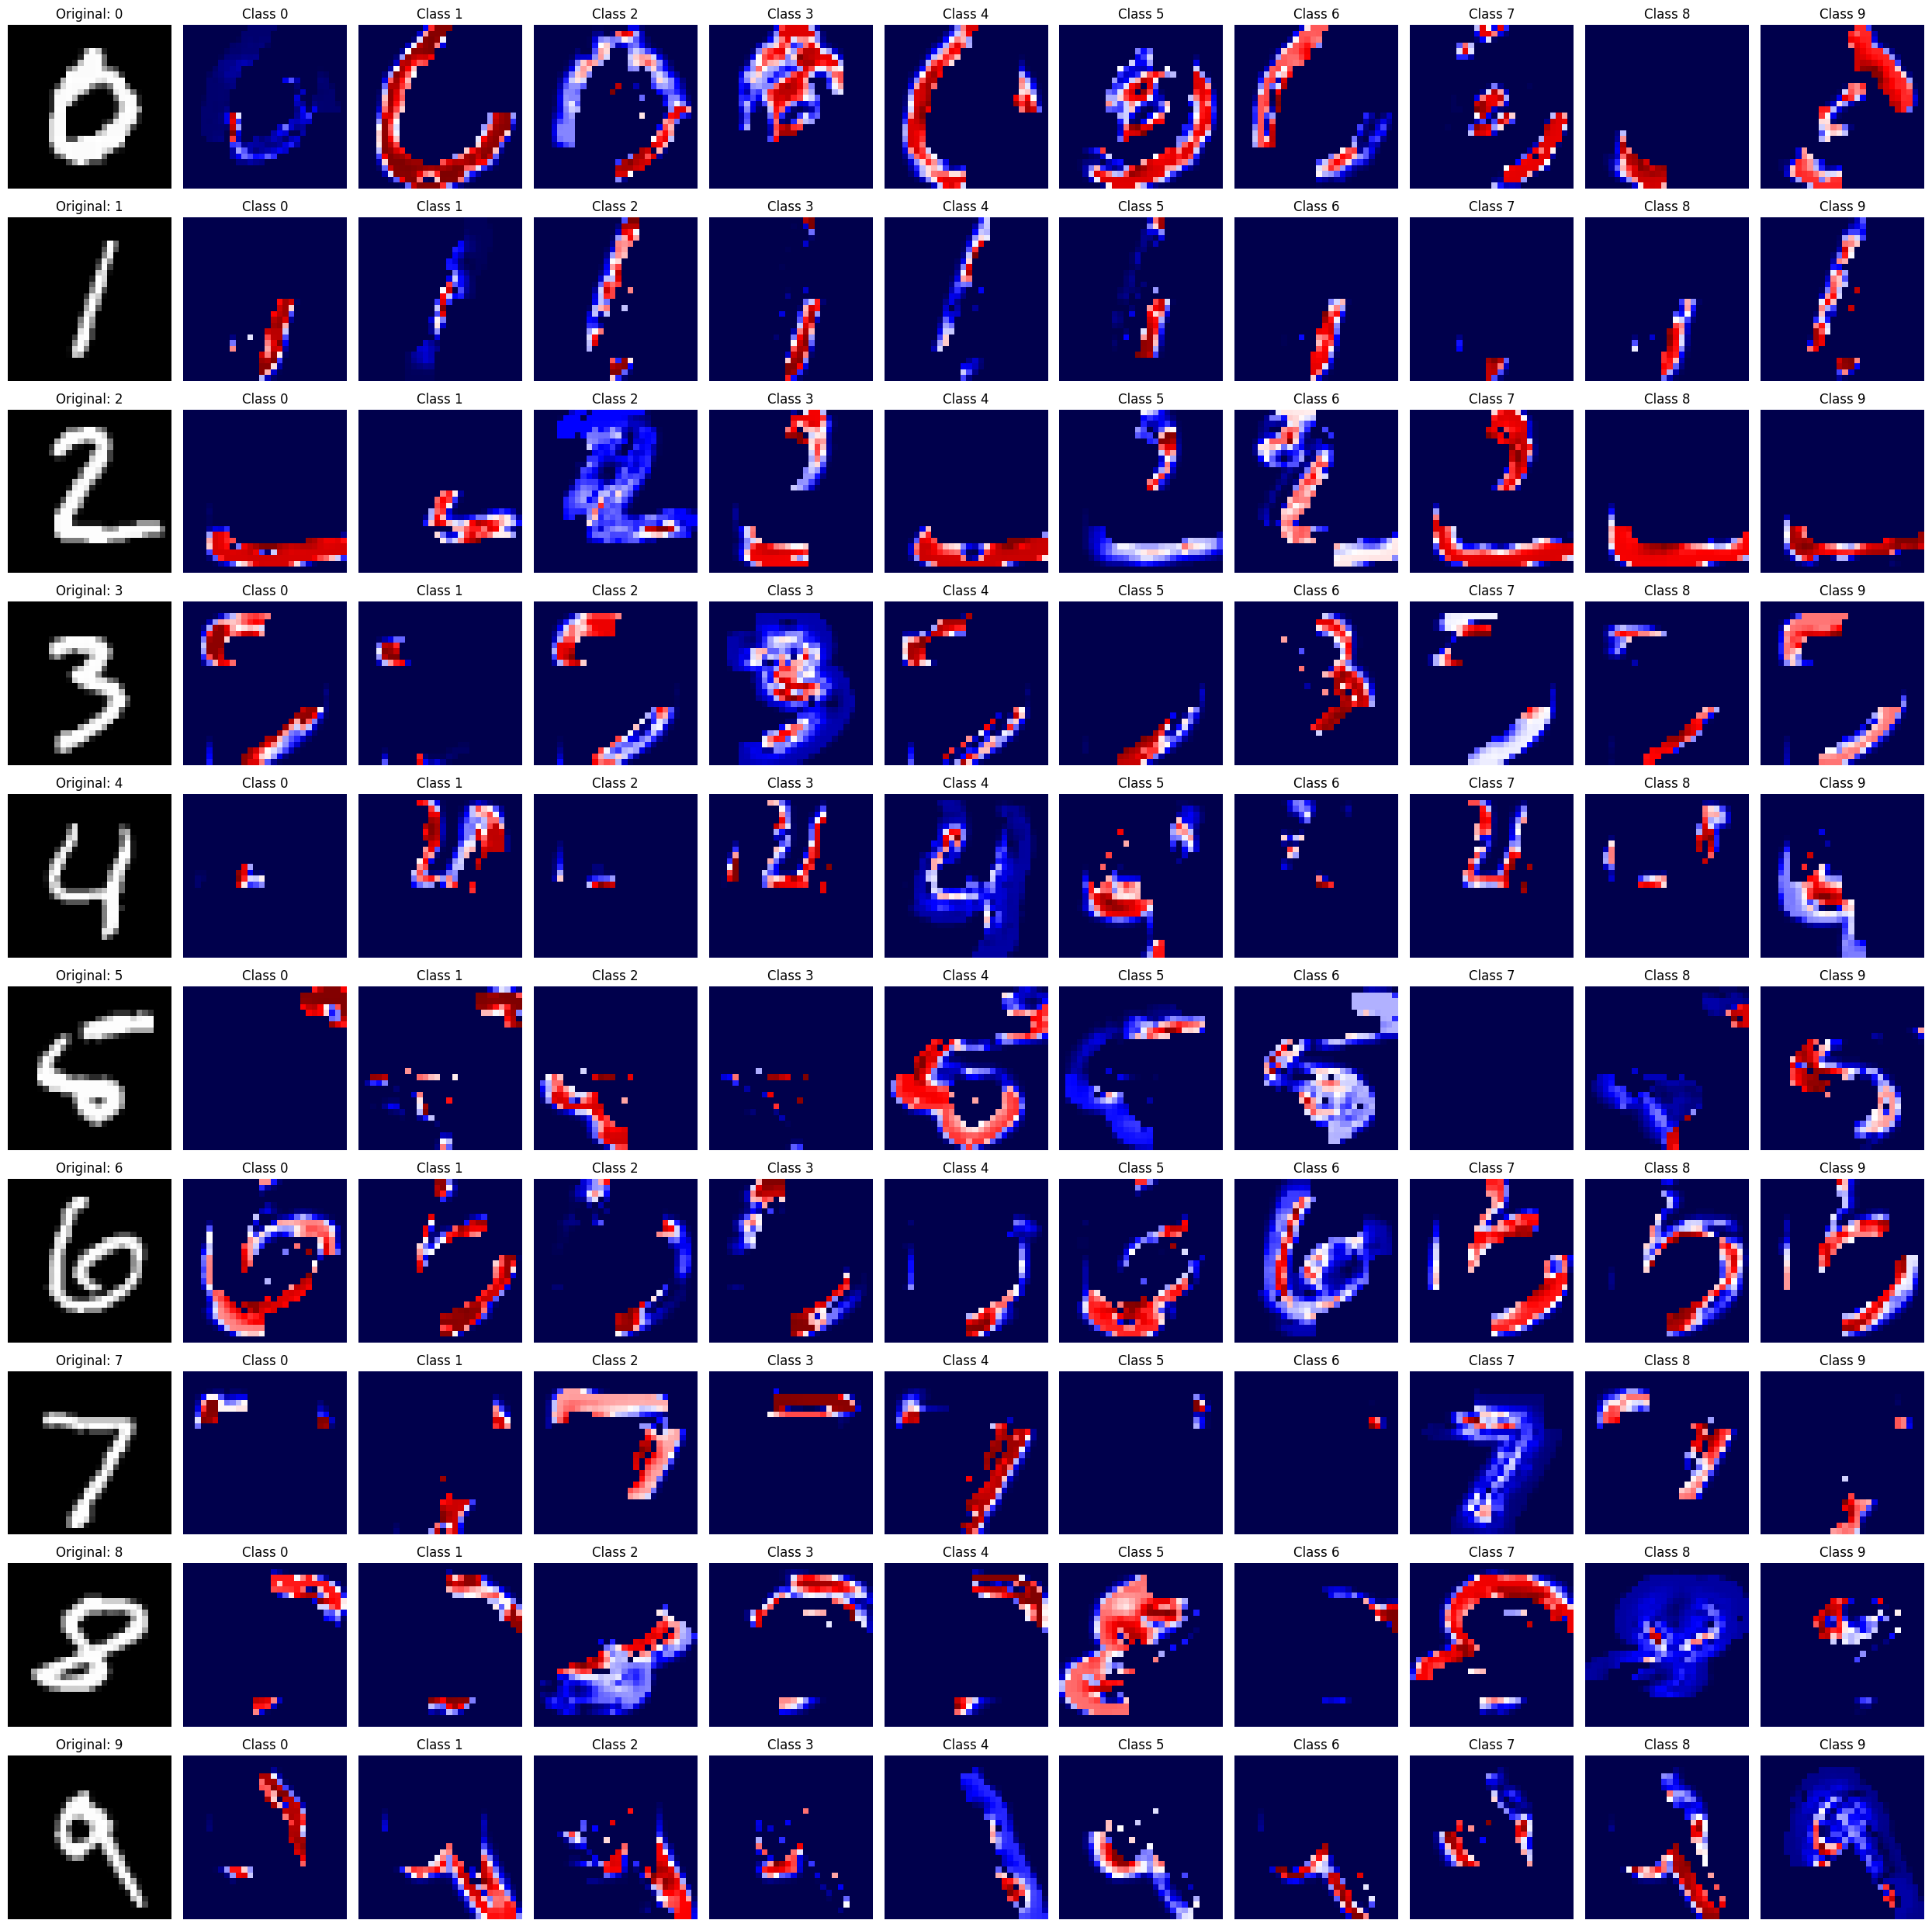

In [27]:
# Calculate integrated maps using min
min_explanations = calculate_min_per_pixel(new_explanations_data)
visualize_all_classes(min_explanations, x_selected, y_selected)

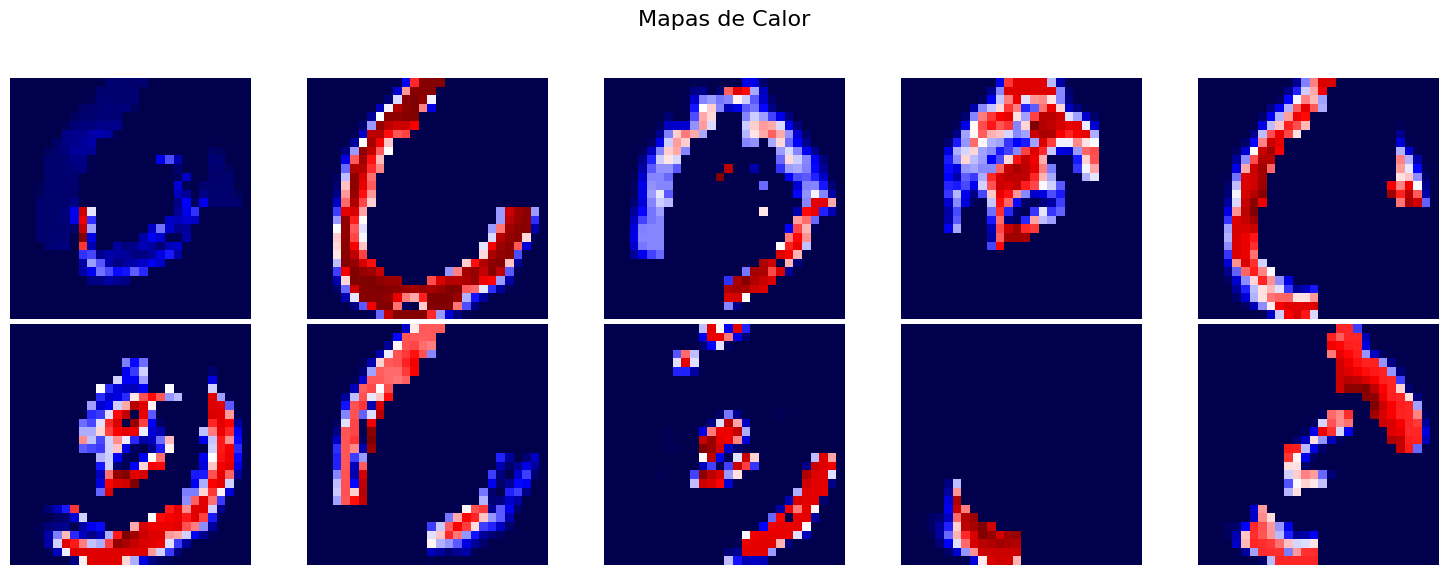

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8884629011154175, Min: 0.0
Mapa 1: Max: 0.8583616018295288, Min: 0.0
Mapa 2: Max: 0.8974012136459351, Min: 0.0
Mapa 3: Max: 0.8889239670180293, Min: 0.0
Mapa 4: Max: 0.8079016804695129, Min: 0.0
Mapa 5: Max: 0.7507686018943787, Min: 0.0
Mapa 6: Max: 0.861624538898468, Min: 0.0
Mapa 7: Max: 0.7272727272727273, Min: 0.0
Mapa 8: Max: 0.8612141799114224, Min: 0.0
Mapa 9: Max: 0.8644222254043437, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [512]
Suma clase objetivo: 0.8884629011154175
Suma de otras clases: 0.0
IFI calculado: 7.996166110038757
Image 1, Class 0: LSE Value: 7.9962


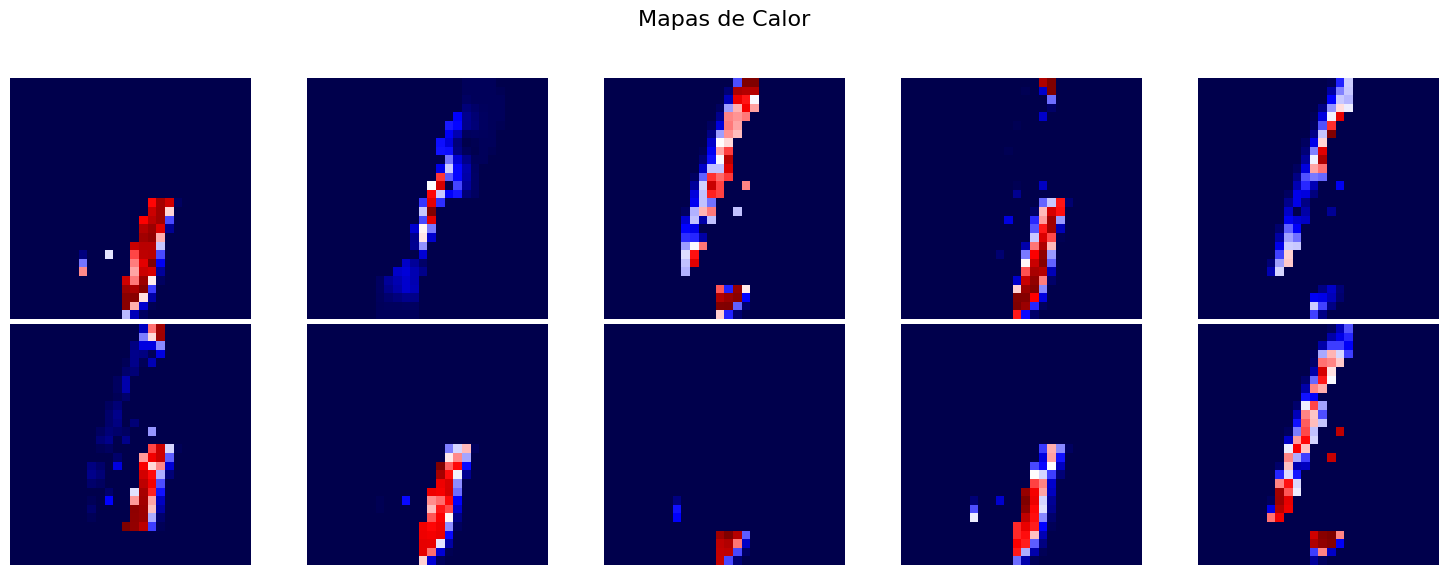

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8678492367485099, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 0.7772602438926697, Min: 0.0
Mapa 3: Max: 0.8856745362281799, Min: 0.0
Mapa 4: Max: 0.772513446707053, Min: 0.0
Mapa 5: Max: 0.8187082409858704, Min: 0.0
Mapa 6: Max: 0.8824830651283264, Min: 0.0
Mapa 7: Max: 0.638821005821228, Min: 0.0
Mapa 8: Max: 0.818111777305603, Min: 0.0
Mapa 9: Max: 0.5521610975265503, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [434]
Suma clase objetivo: 1.0
Suma de otras clases: 0.0
IFI calculado: 9.0
Image 2, Class 1: LSE Value: 9.0000


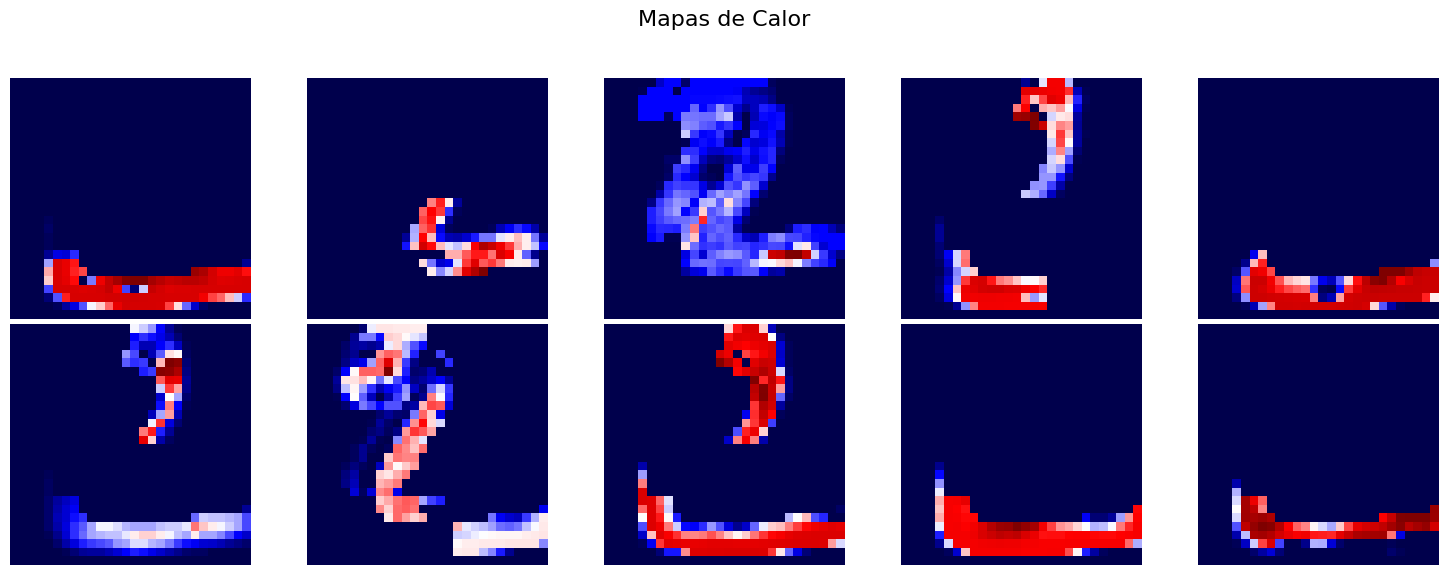

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.623376190662384, Min: 0.0
Mapa 1: Max: 0.6631016042780749, Min: 0.0
Mapa 2: Max: 0.9152897596359253, Min: 0.0
Mapa 3: Max: 0.8640584349632263, Min: 0.0
Mapa 4: Max: 0.6567058461524377, Min: 0.0
Mapa 5: Max: 0.826985246852343, Min: 0.0
Mapa 6: Max: 0.8872061967849731, Min: 0.0
Mapa 7: Max: 0.6302537322044373, Min: 0.0
Mapa 8: Max: 0.524533748626709, Min: 0.0
Mapa 9: Max: 0.8094431757926941, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [581 582]
Suma clase objetivo: 1.8249588012695312
Suma de otras clases: 0.9654715041842035
IFI calculado: 17.012028982982915
Image 3, Class 2: LSE Value: 17.0120


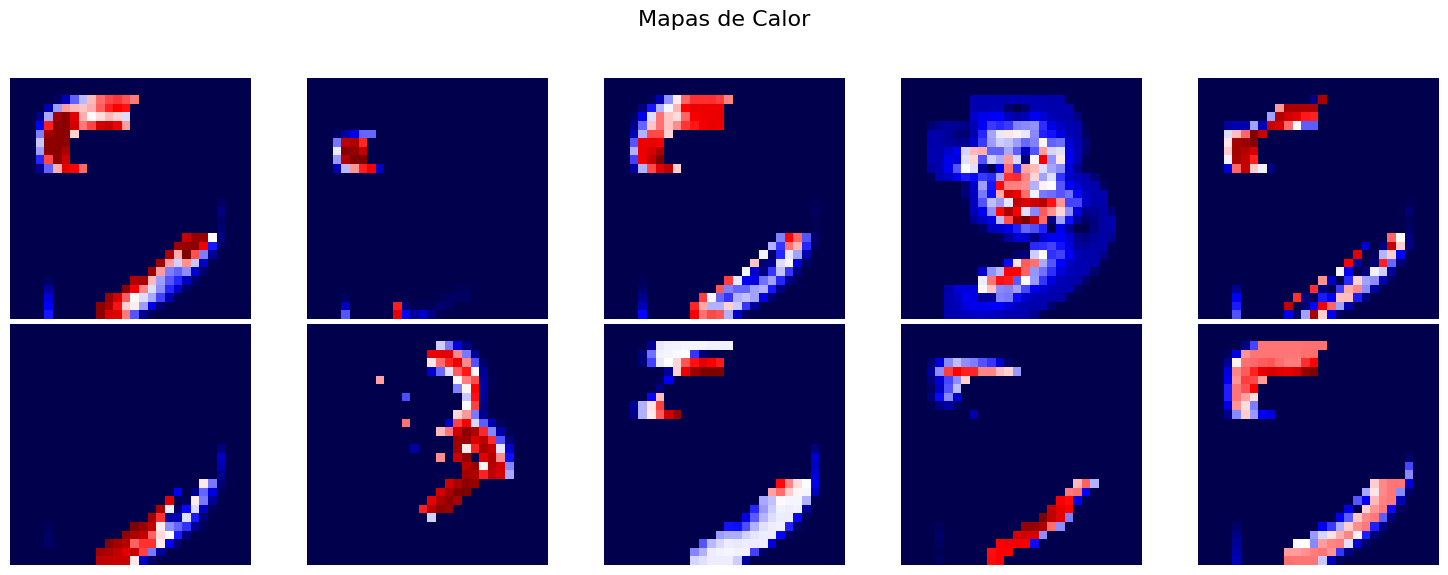

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8454239663088493, Min: 0.0
Mapa 1: Max: 0.7287992238998413, Min: 0.0
Mapa 2: Max: 0.804469645023346, Min: 0.0
Mapa 3: Max: 0.7517625093460083, Min: 0.0
Mapa 4: Max: 0.624752938747406, Min: 0.0
Mapa 5: Max: 0.6557024717330933, Min: 0.0
Mapa 6: Max: 0.9226914740351374, Min: 0.0
Mapa 7: Max: 0.8070434733570975, Min: 0.0
Mapa 8: Max: 0.8840252083292729, Min: 0.0
Mapa 9: Max: 0.5684897303581238, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Image 4, Class 3: LSE Value: 0.0000


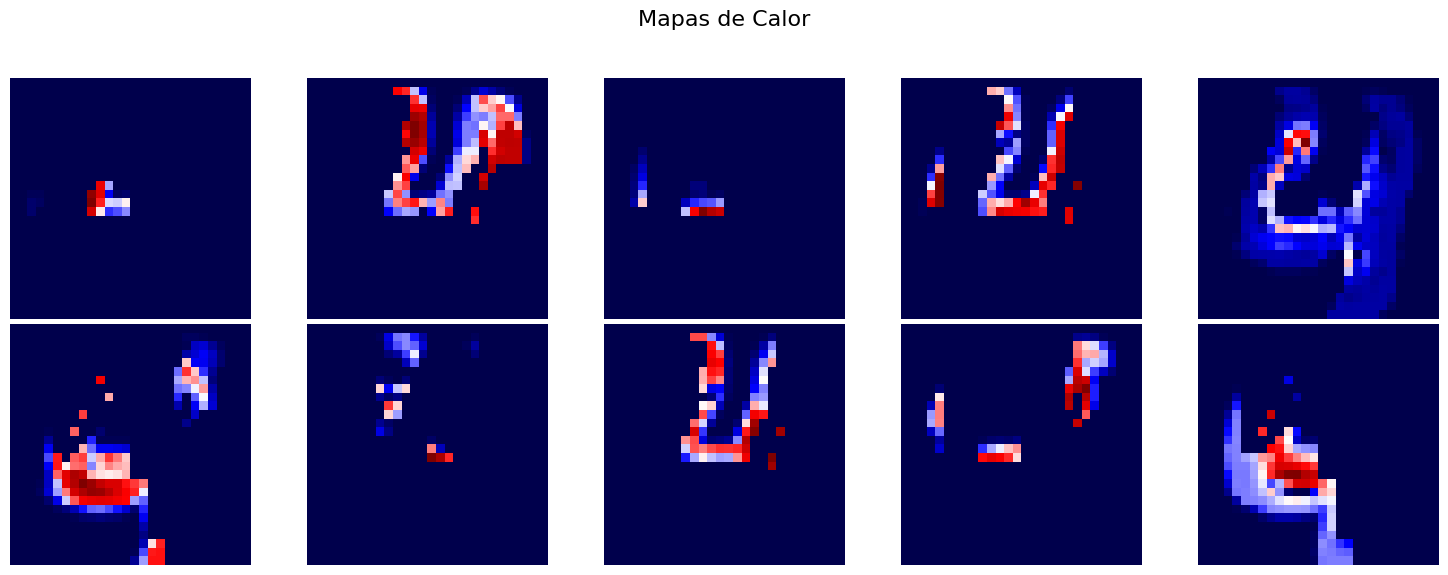

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8315400005269051, Min: 0.0
Mapa 1: Max: 0.7786784325044797, Min: 0.0
Mapa 2: Max: 0.7593582887700534, Min: 0.0
Mapa 3: Max: 0.7001010179519653, Min: 0.0
Mapa 4: Max: 0.9842685461044312, Min: 0.0
Mapa 5: Max: 0.9500365853309631, Min: 0.0
Mapa 6: Max: 0.6310160427807486, Min: 0.0
Mapa 7: Max: 0.8856163620948792, Min: 0.0
Mapa 8: Max: 0.822944164276123, Min: 0.0
Mapa 9: Max: 0.9363747497301288, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [208]
Suma clase objetivo: 0.9842685461044312
Suma de otras clases: 1.0037935322935767
IFI calculado: 8.824939223008545
Image 5, Class 4: LSE Value: 8.8249


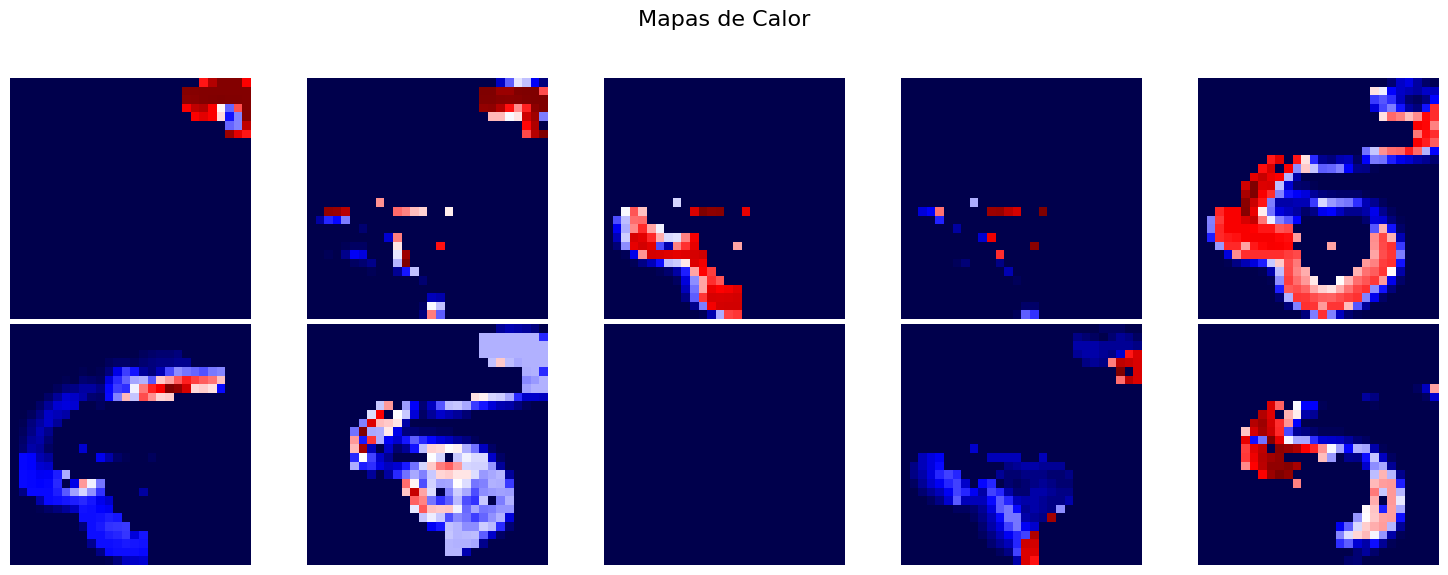

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 1
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.4526189863681793, Min: 0.0
Mapa 1: Max: 0.715043306350708, Min: 0.0
Mapa 2: Max: 0.7807486631016042, Min: 0.0
Mapa 3: Max: 0.605237603187561, Min: 0.0
Mapa 4: Max: 0.9122881272095961, Min: 0.0
Mapa 5: Max: 0.9073525667190552, Min: 0.0
Mapa 6: Max: 0.6717720031738281, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.4662019908428192, Min: 0.0
Mapa 9: Max: 0.8259264060603755, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [214 215]
Suma clase objetivo: 1.7736627271468626
Suma de otras clases: 0.0
IFI calculado: 15.962964544321764
Image 6, Class 5: LSE Value: 15.9630


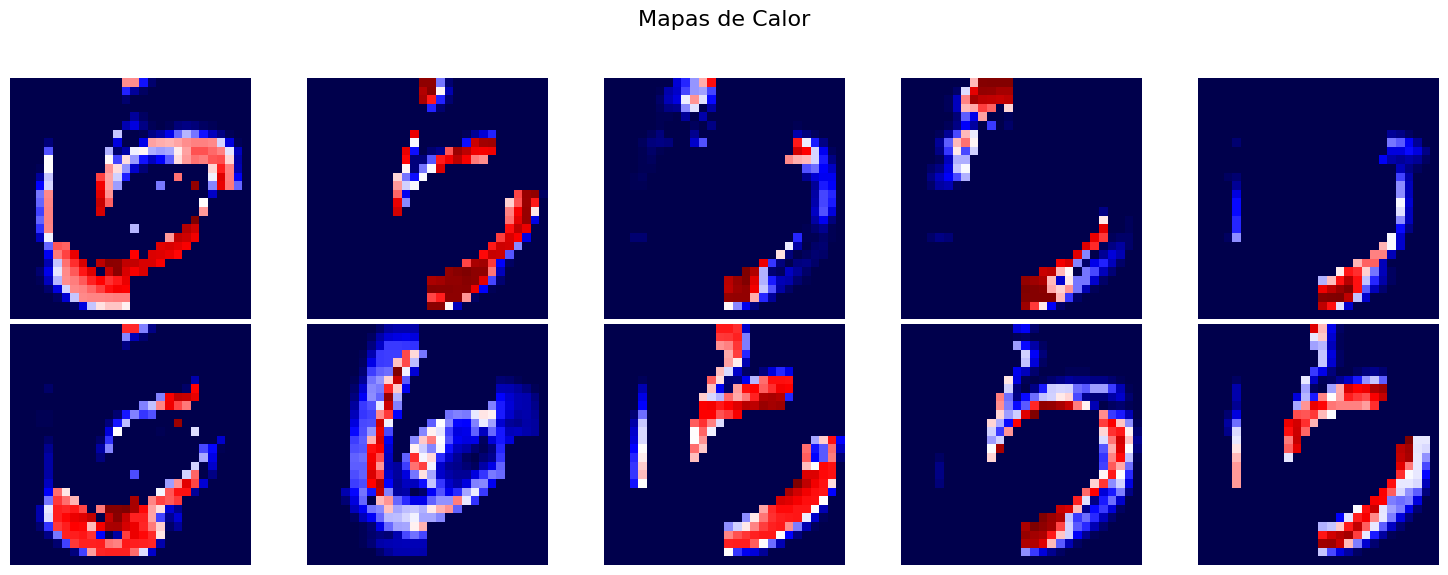

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.7690787315368652, Min: 0.0
Mapa 1: Max: 0.6923021078109741, Min: 0.0
Mapa 2: Max: 0.8871703718789277, Min: 0.0
Mapa 3: Max: 0.6028111577033997, Min: 0.0
Mapa 4: Max: 0.4664352238178253, Min: 0.0
Mapa 5: Max: 0.8968360031596047, Min: 0.0
Mapa 6: Max: 0.8342245989304814, Min: 0.0
Mapa 7: Max: 0.6822127103805542, Min: 0.0
Mapa 8: Max: 0.7516564130783081, Min: 0.0
Mapa 9: Max: 0.7134794494394647, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Image 7, Class 6: LSE Value: 0.0000


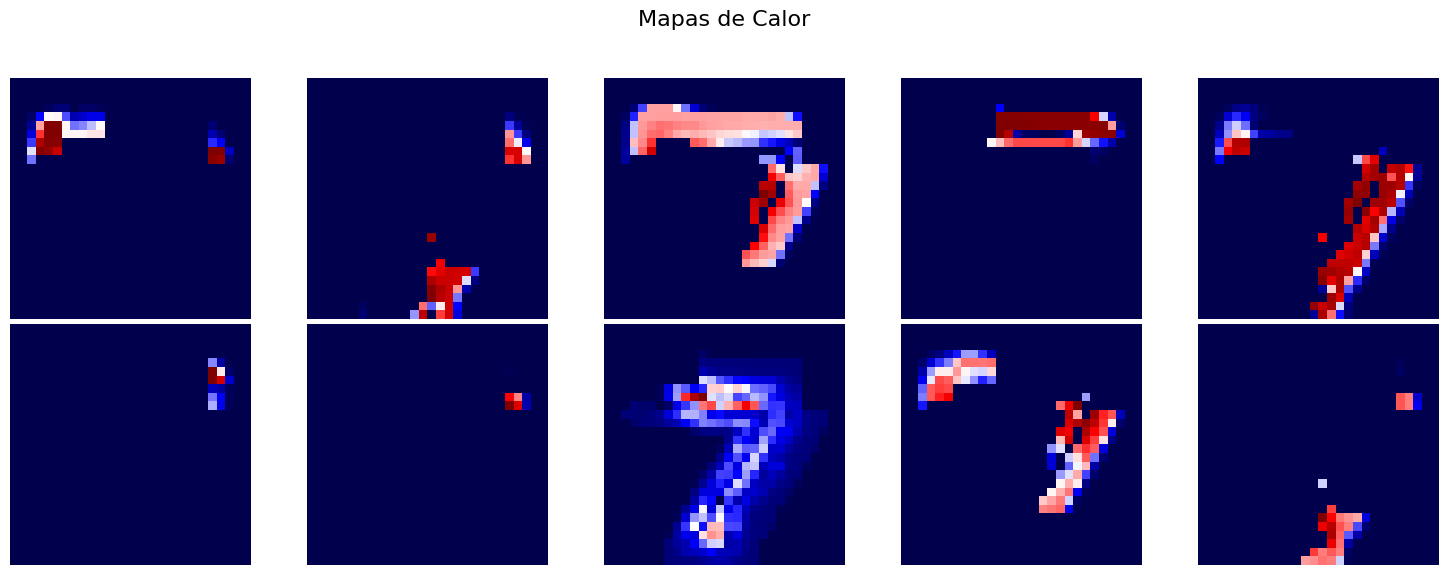

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.6700180172920227, Min: 0.0
Mapa 1: Max: 0.867294430732727, Min: 0.0
Mapa 2: Max: 0.775672252072756, Min: 0.0
Mapa 3: Max: 0.4500162899494171, Min: 0.0
Mapa 4: Max: 0.922303669007262, Min: 0.0
Mapa 5: Max: 0.6034784913063049, Min: 0.0
Mapa 6: Max: 0.8615548610687256, Min: 0.0
Mapa 7: Max: 0.9204754616167957, Min: 0.0
Mapa 8: Max: 0.8469547033309937, Min: 0.0
Mapa 9: Max: 0.7522972532158853, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [235]
Suma clase objetivo: 0.9204754616167957
Suma de otras clases: 0.0
IFI calculado: 8.284279154551161
Image 8, Class 7: LSE Value: 8.2843


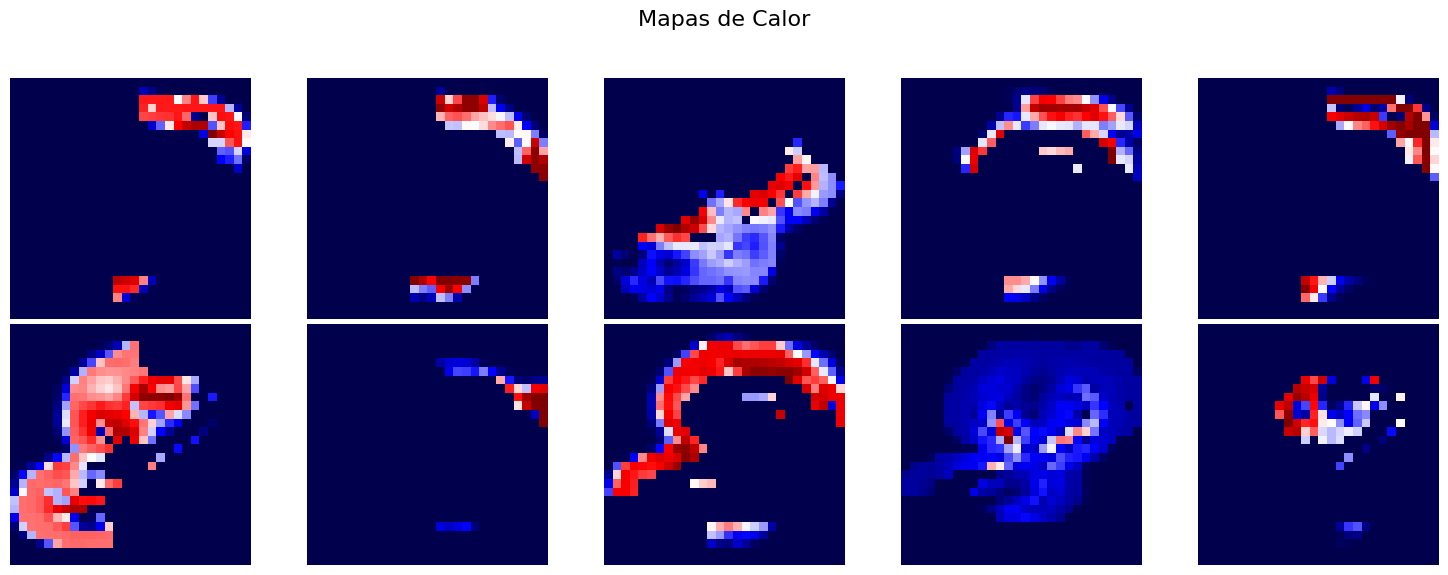

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.7378571033477783, Min: 0.0
Mapa 1: Max: 0.7840914726257324, Min: 0.0
Mapa 2: Max: 0.9215300679206848, Min: 0.0
Mapa 3: Max: 0.7165775401069517, Min: 0.0
Mapa 4: Max: 0.6743745803833008, Min: 0.0
Mapa 5: Max: 0.8022817585609997, Min: 0.0
Mapa 6: Max: 0.5849614143371582, Min: 0.0
Mapa 7: Max: 0.8511322140693665, Min: 0.0
Mapa 8: Max: 0.9891571998596191, Min: 0.0
Mapa 9: Max: 0.8824558039456851, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [347 376]
Suma clase objetivo: 1.843237042427063
Suma de otras clases: 2.348877689267605
IFI calculado: 7.0625786338905385
Image 9, Class 8: LSE Value: 7.0626


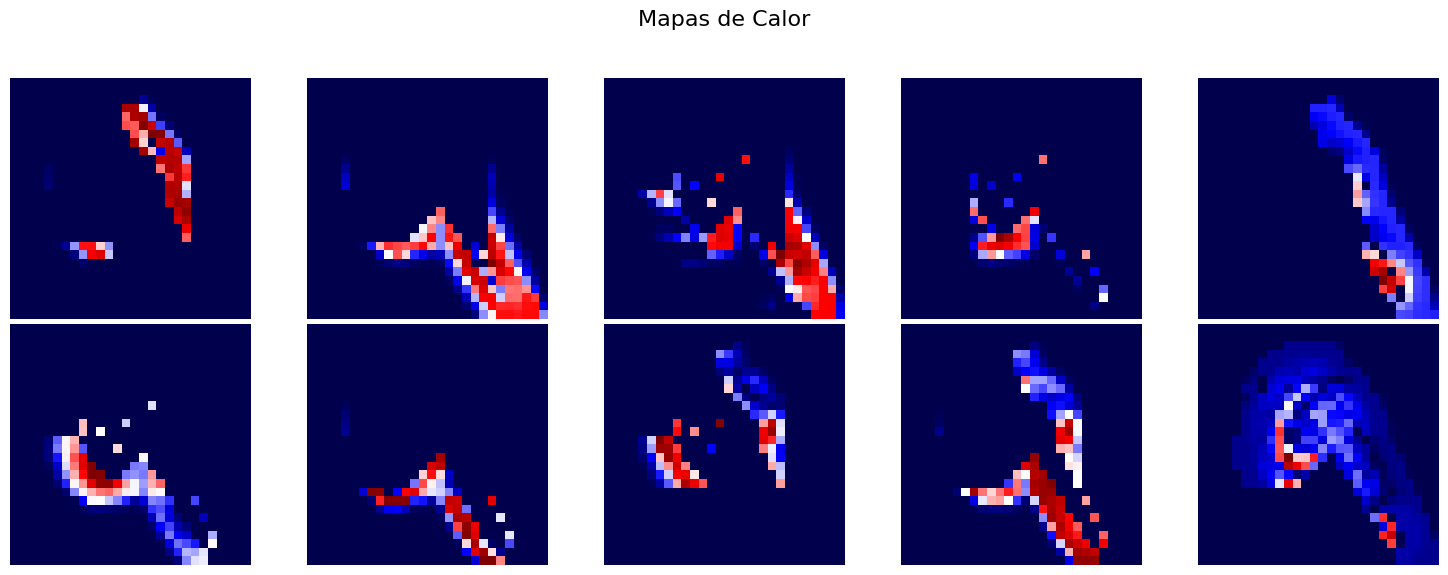

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8606838583946228, Min: 0.0
Mapa 1: Max: 0.878917947415678, Min: 0.0
Mapa 2: Max: 0.8770053475935828, Min: 0.0
Mapa 3: Max: 0.9247437994209675, Min: 0.0
Mapa 4: Max: 0.99680048761196, Min: 0.0
Mapa 5: Max: 0.8955139517784119, Min: 0.0
Mapa 6: Max: 0.6403927206993103, Min: 0.0
Mapa 7: Max: 0.7519214153289795, Min: 0.0
Mapa 8: Max: 0.6878623366355896, Min: 0.0
Mapa 9: Max: 0.6825727637261658, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Image 10, Class 9: LSE Value: 0.0000


In [28]:
# Calculate LSE values using the integrated maps
lse_values_min = calculate_lse_per_image(integrated_explanations=min_explanations, y_selected=y_selected)

##AVG

In [29]:
def calculate_avg_per_pixel(explanations_data):
    """
    Calculates the pixel-wise average across all explanations for each image and class.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                class_maps.append(normalized_map)
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise average along axis 0 (across the 4 methods)
            avg_map = np.mean(stacked_maps, axis=0)  # Dimensions: (28, 28)

            print(f"    Integrated map: Shape: {avg_map.shape}, "
                  f"Min: {np.min(avg_map):.4f}, Max: {np.max(avg_map):.4f}")

            # Save the integrated map per class
            image_maps.append(avg_map)

        integrated_explanations.append(image_maps)

    return integrated_explanations


Processing image 1/10...
  Class 1/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0331, Max: 0.9714
  Class 2/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.2242, Max: 0.9440
  Class 3/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.1219, Max: 0.9735
  Class 4/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.2645, Max: 0.9610
  Class 5/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.2208, Max: 0

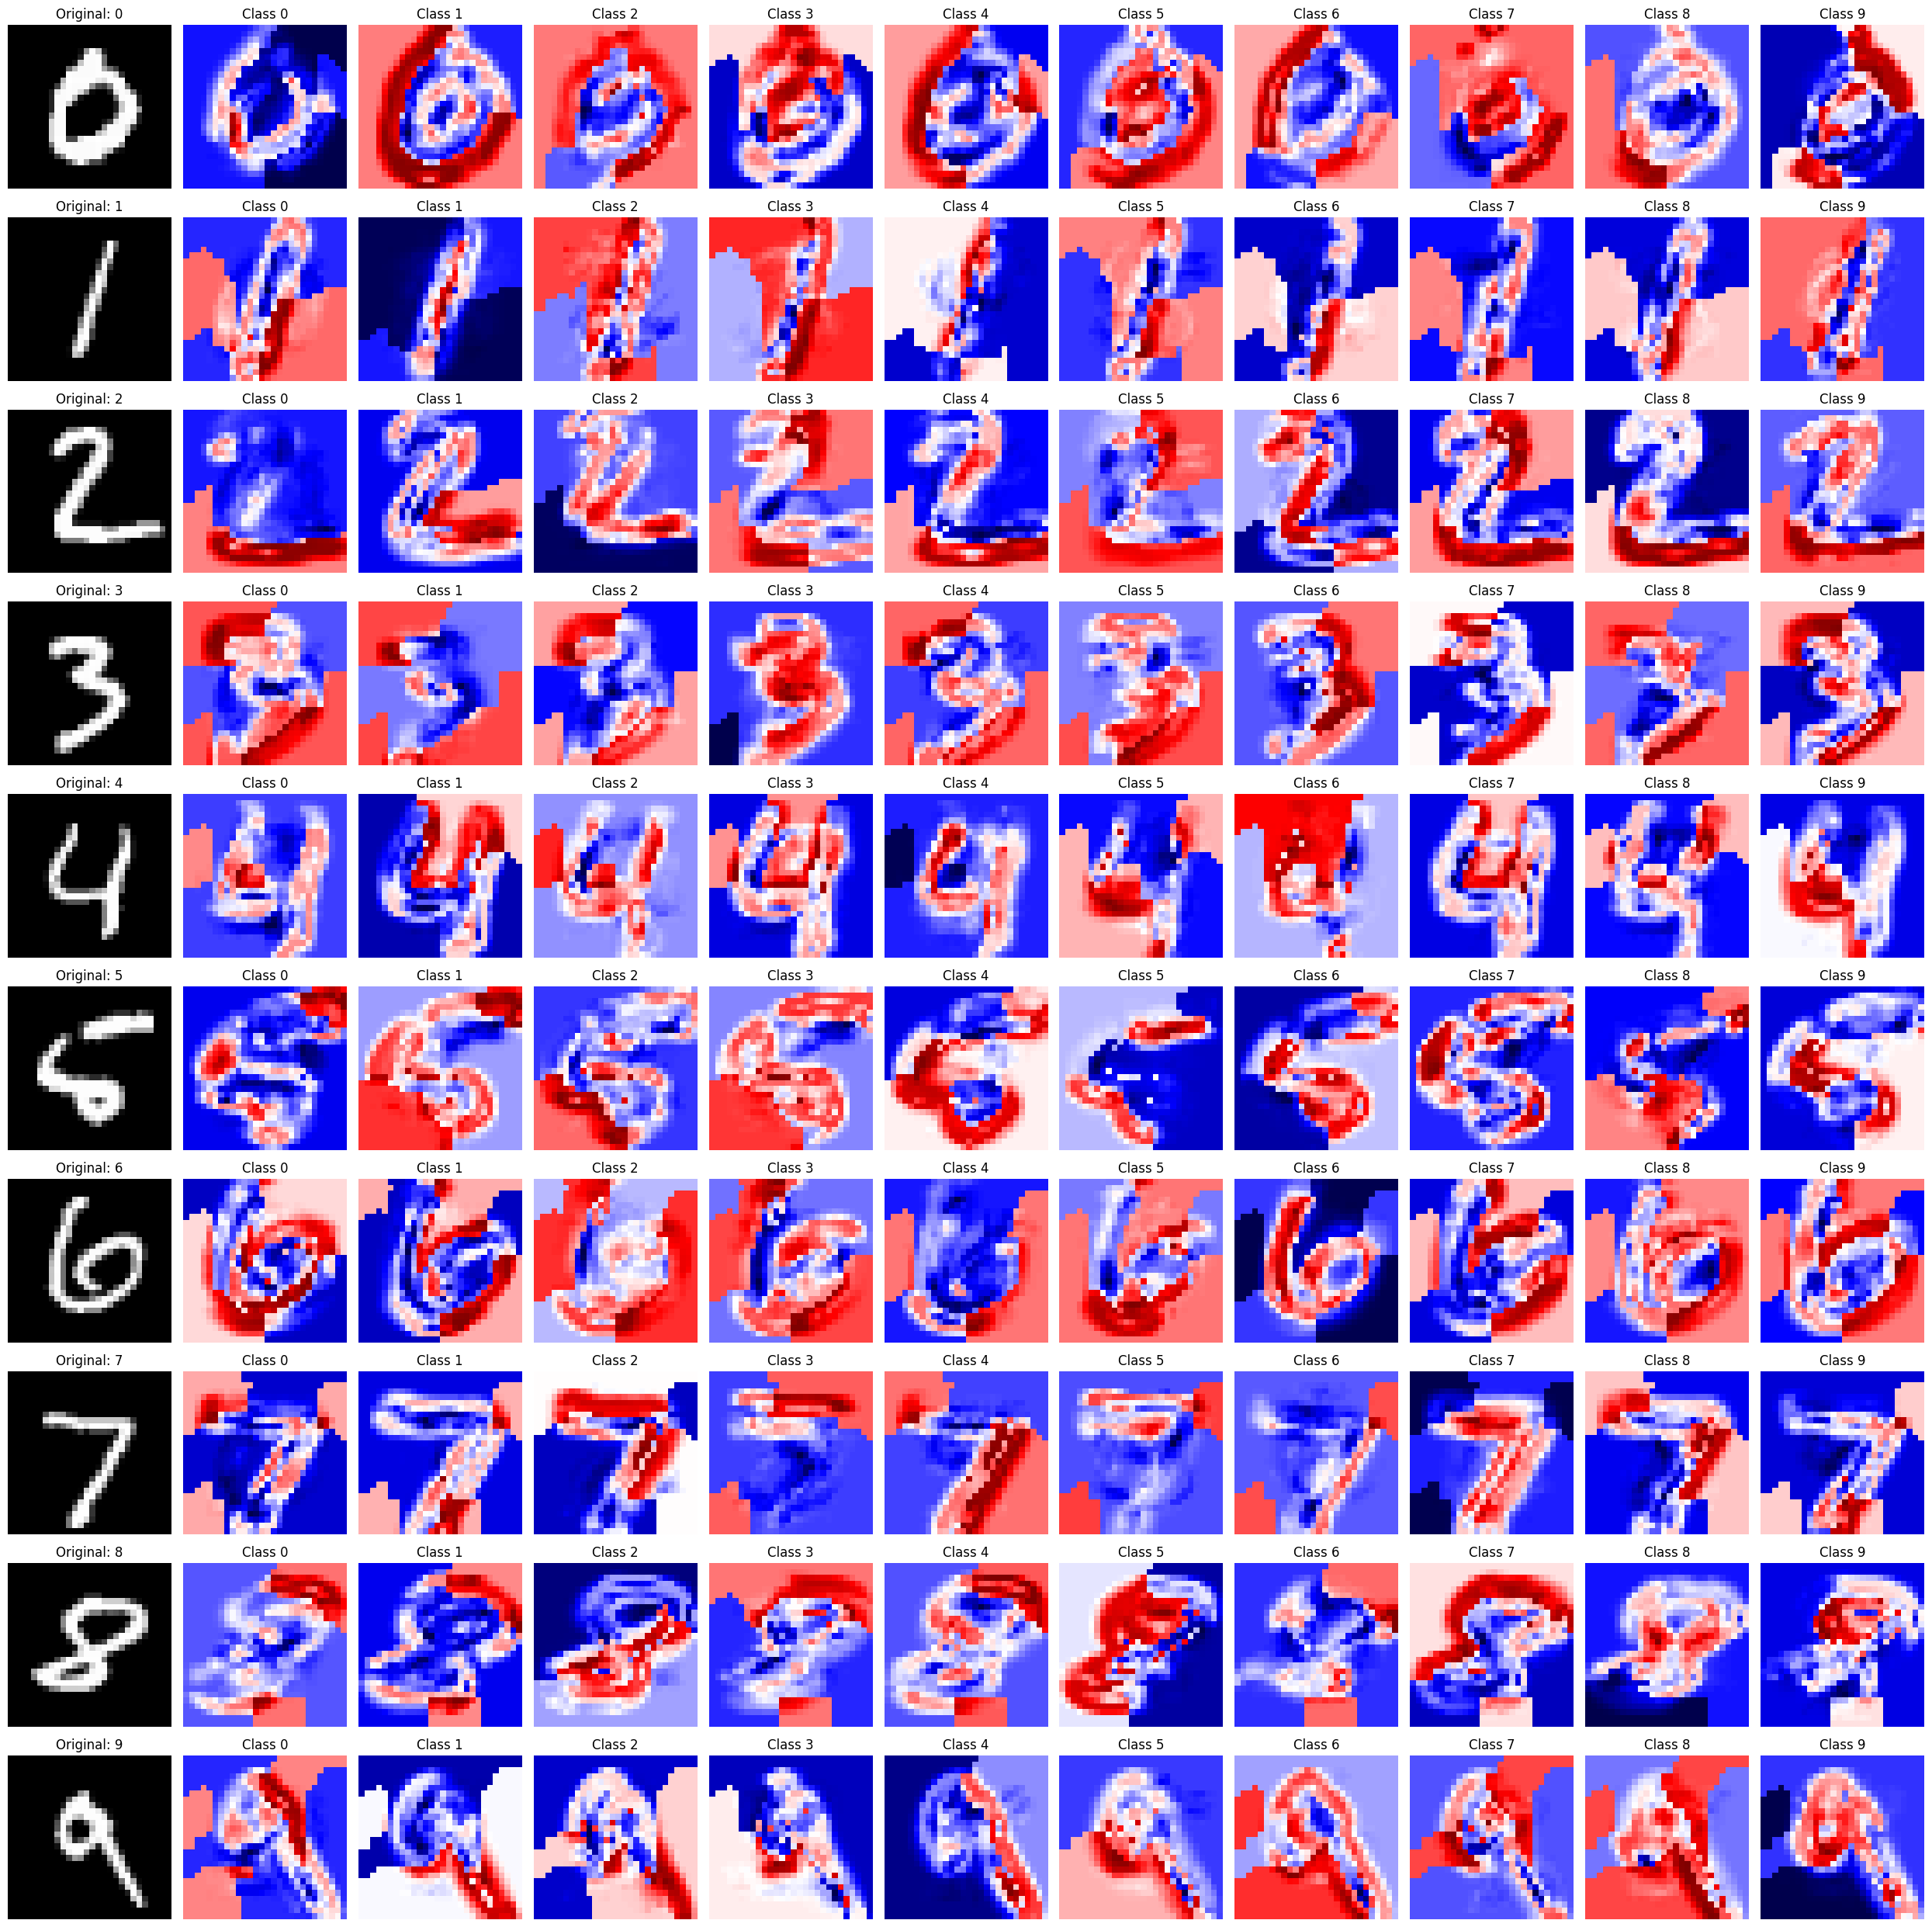

In [30]:
# Calculate integrated maps using avg
avg_explanations = calculate_avg_per_pixel(new_explanations_data)
visualize_all_classes(avg_explanations, x_selected, y_selected)

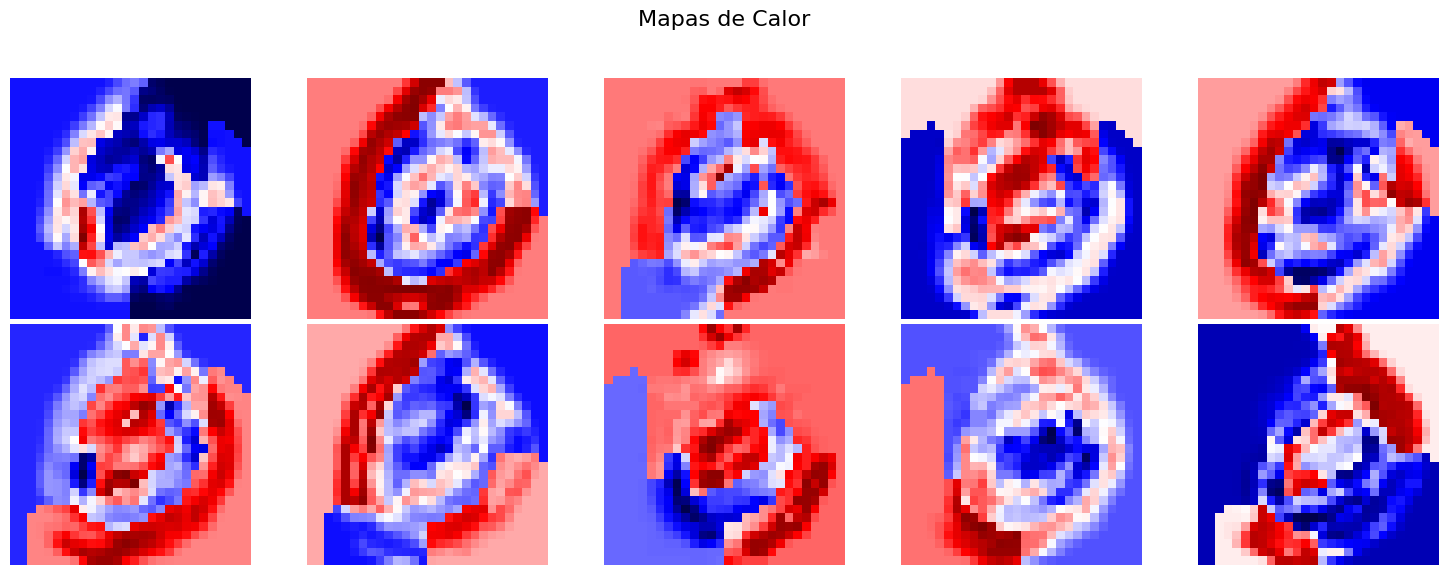

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.9714472760809933, Min: 0.03309259117100644
Mapa 1: Max: 0.9439576972571961, Min: 0.22415527562426532
Mapa 2: Max: 0.973502646236313, Min: 0.12187432785603135
Mapa 3: Max: 0.9610305111531405, Min: 0.2644971149768169
Mapa 4: Max: 0.9064512043531874, Min: 0.22076434898359915
Mapa 5: Max: 0.8848968319910607, Min: 0.1278451848262071
Mapa 6: Max: 0.9422675648756491, Min: 0.16592723343925697
Mapa 7: Max: 0.8753279881856724, Min: 0.0399210315318327
Mapa 8: Max: 0.9362509467054401, Min: 0.1282096938653426
Mapa 9: Max: 0.9452137558282816, Min: 0.2685879488819497
Cantidad de rasgos mayores que 0.85: 5
Indices mayores que 0.85: [428 456 484 512 540]
Suma clase objetivo: 4.4787207917607414
Suma de otras clases: 17.229386704549896
IFI calculado: 2.33951

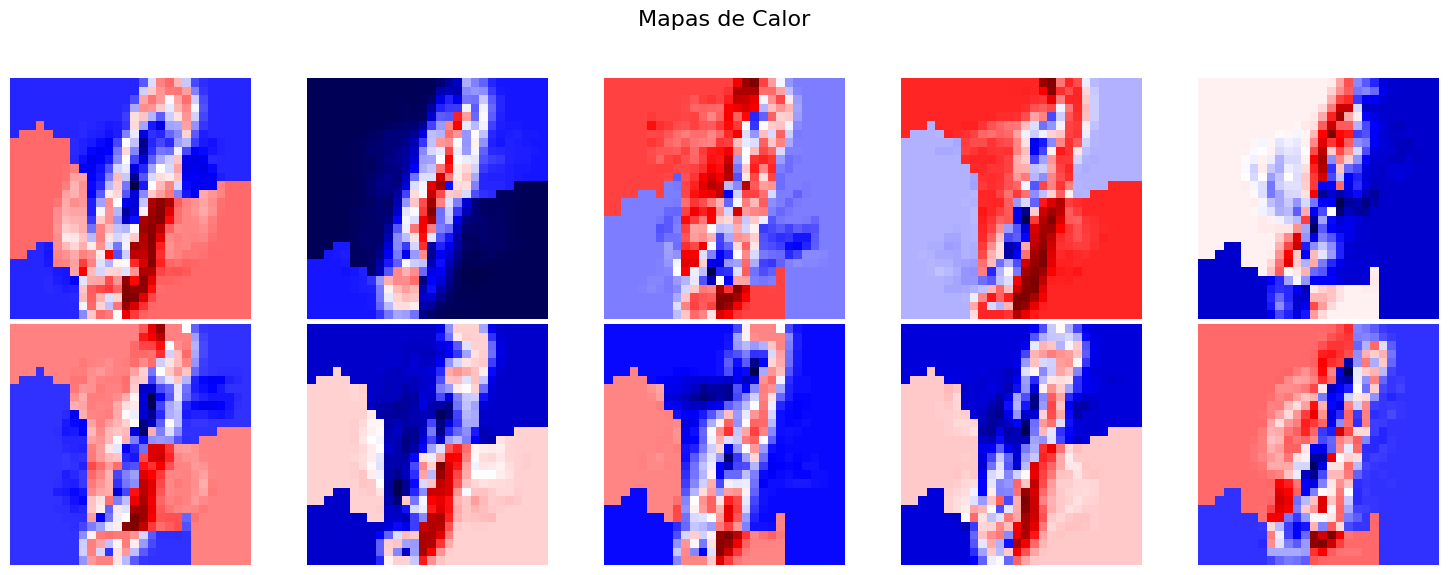

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.9351478512788232, Min: 0.2342469977580492
Mapa 1: Max: 1.0, Min: 0.01656001034790766
Mapa 2: Max: 0.9043365620318663, Min: 0.10662573036105237
Mapa 3: Max: 0.9428057449070953, Min: 0.07383660203154713
Mapa 4: Max: 0.8851015355181989, Min: 0.13197796001540701
Mapa 5: Max: 0.9384913845290732, Min: 0.173792039025813
Mapa 6: Max: 0.9518556443232906, Min: 0.27227676853880156
Mapa 7: Max: 0.8571141198343757, Min: 0.16019053775119907
Mapa 8: Max: 0.9367695174412883, Min: 0.2241027684292397
Mapa 9: Max: 0.8444563777105001, Min: 0.11843045745144552
Cantidad de rasgos mayores que 0.85: 5
Indices mayores que 0.85: [351 378 406 434 462]
Suma clase objetivo: 4.645832710982423
Suma de otras clases: 17.408442174233087
IFI calculado: 2.4018515832927374
Im

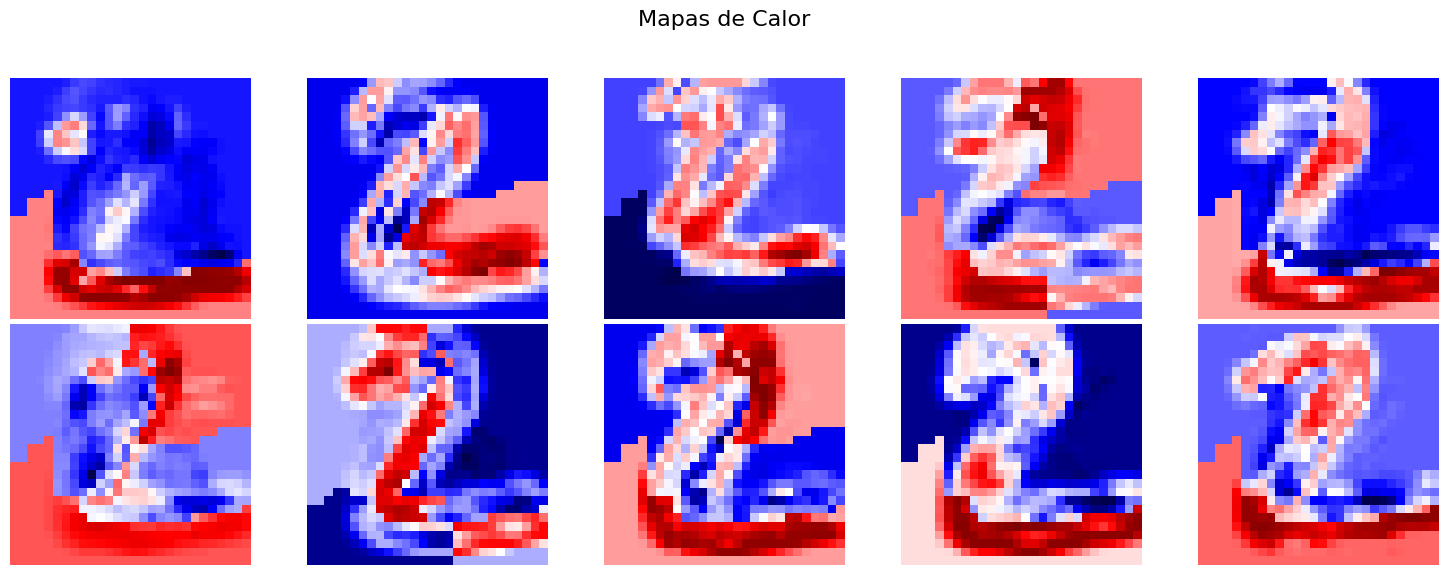

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8276616593210865, Min: 0.11063288343462714
Mapa 1: Max: 0.82043287247655, Min: 0.13601755134164709
Mapa 2: Max: 0.9788224399089813, Min: 0.09748016253812092
Mapa 3: Max: 0.950542995952839, Min: 0.10482758014718356
Mapa 4: Max: 0.8635582935294663, Min: 0.1142690062251924
Mapa 5: Max: 0.9339762598582493, Min: 0.07039433656534172
Mapa 6: Max: 0.959101014436885, Min: 0.1890566817380695
Mapa 7: Max: 0.8410096358520711, Min: 0.1601818314560058
Mapa 8: Max: 0.8191433279323076, Min: 0.25396117893978953
Mapa 9: Max: 0.9237066555113741, Min: 0.11282064919740592
Cantidad de rasgos mayores que 0.85: 5
Indices mayores que 0.85: [579 580 581 582 583]
Suma clase objetivo: 4.658528237643772
Suma de otras clases: 14.562238032320993
IFI calculado: 2.8791422

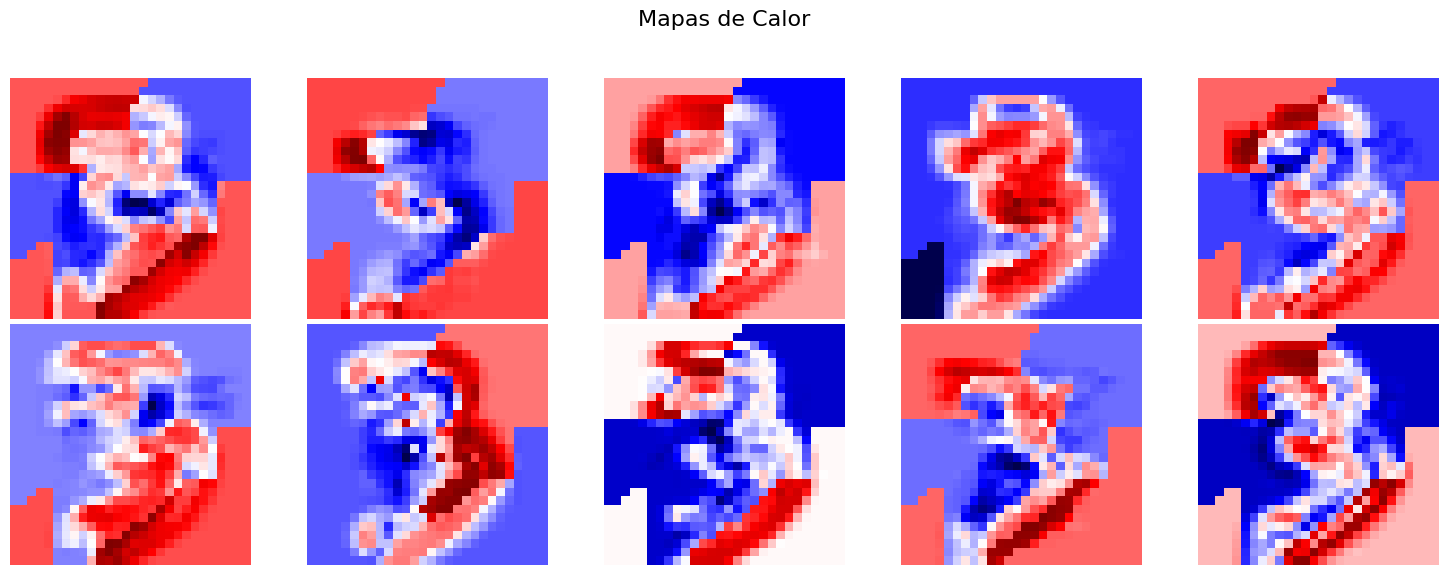

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.9317791242978478, Min: 0.1875634891875594
Mapa 1: Max: 0.8994431833053905, Min: 0.1027949951678679
Mapa 2: Max: 0.9358706602407285, Min: 0.1916249257133366
Mapa 3: Max: 0.9129610276616363, Min: 0.06702842016358124
Mapa 4: Max: 0.813811262687331, Min: 0.08134800741115951
Mapa 5: Max: 0.8843815398343408, Min: 0.051470588235294115
Mapa 6: Max: 0.9655676806158705, Min: 0.13324987501862215
Mapa 7: Max: 0.9241442999289434, Min: 0.15851391390479072
Mapa 8: Max: 0.9425851087210358, Min: 0.09806366076796583
Mapa 9: Max: 0.7808110521624094, Min: 0.16335680486644213
Cantidad de rasgos mayores que 0.85: 6
Indices mayores que 0.85: [405 408 432 433 461 462]
Suma clase objetivo: 5.319363587770952
Suma de otras clases: 22.374946721680868
IFI calculado: 2

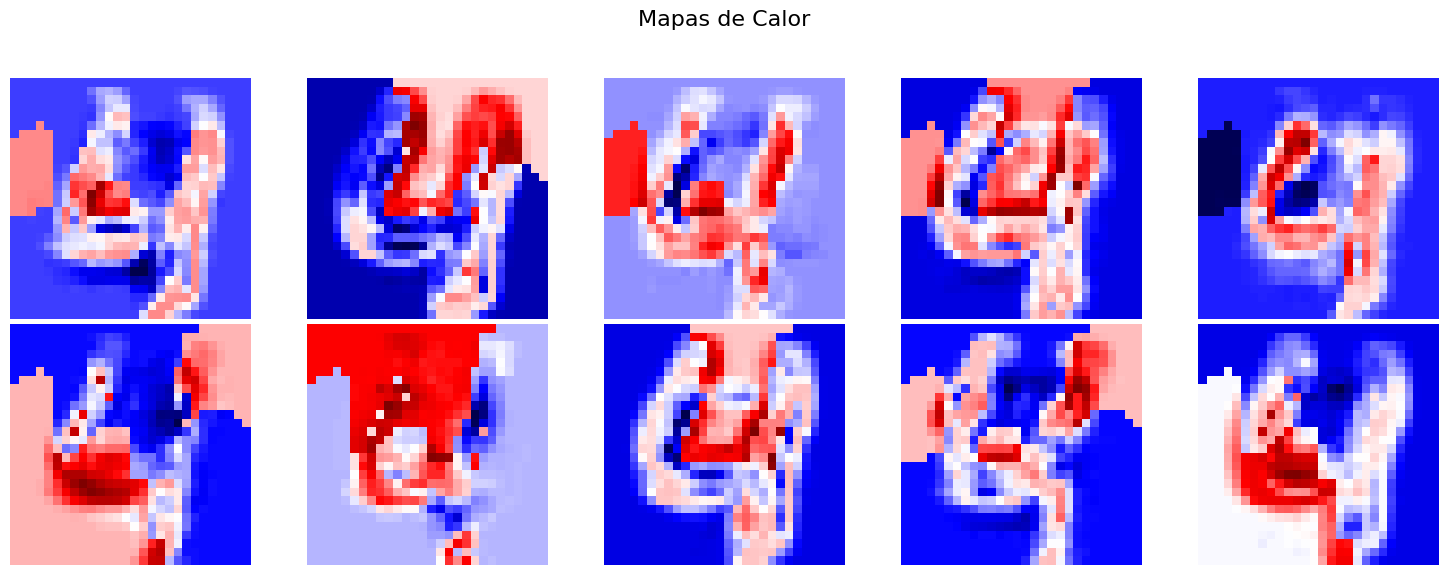

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.9400705860374882, Min: 0.12132350876618048
Mapa 1: Max: 0.897630501637892, Min: 0.2786449521628602
Mapa 2: Max: 0.8329776228167676, Min: 0.06394659691855414
Mapa 3: Max: 0.8787972823981822, Min: 0.249331550802139
Mapa 4: Max: 0.994061788932525, Min: 0.0463350331913226
Mapa 5: Max: 0.9841398731534645, Min: 0.187286862032737
Mapa 6: Max: 0.7868737133302525, Min: 0.012447094544768333
Mapa 7: Max: 0.9596163233389675, Min: 0.2300908246451397
Mapa 8: Max: 0.920424937204362, Min: 0.10800388454999134
Mapa 9: Max: 0.9840936874325322, Min: 0.08373495191335678
Cantidad de rasgos mayores que 0.85: 7
Indices mayores que 0.85: [179 180 206 207 208 234 289]
Suma clase objetivo: 6.313850795958119
Suma de otras clases: 30.948482272802377
IFI calculado: 1.8

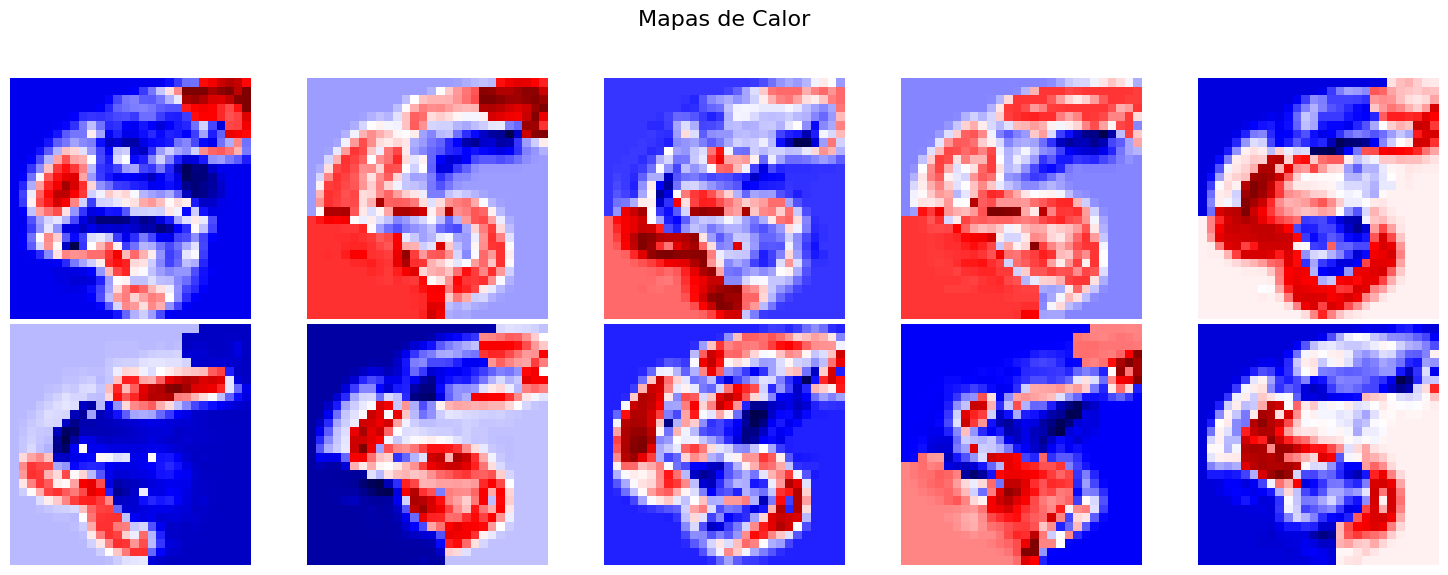

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.798492784078756, Min: 0.1498343549454922
Mapa 1: Max: 0.8992931686304583, Min: 0.06034940108656883
Mapa 2: Max: 0.8900030095120174, Min: 0.17044264082208568
Mapa 3: Max: 0.8629341485887586, Min: 0.07012438029050827
Mapa 4: Max: 0.97379070520401, Min: 0.16911887792226432
Mapa 5: Max: 0.9564668042137023, Min: 0.022592954337596893
Mapa 6: Max: 0.8408719104162705, Min: 0.05149317987706905
Mapa 7: Max: 0.6697948879547727, Min: 0.2648369602397754
Mapa 8: Max: 0.7688954476561346, Min: 0.10301386851823628
Mapa 9: Max: 0.9462554710295592, Min: 0.1590986964616546
Cantidad de rasgos mayores que 0.85: 8
Indices mayores que 0.85: [188 213 214 215 216 240 241 242]
Suma clase objetivo: 7.087170357831047
Suma de otras clases: 26.715447767633737
IFI calcul

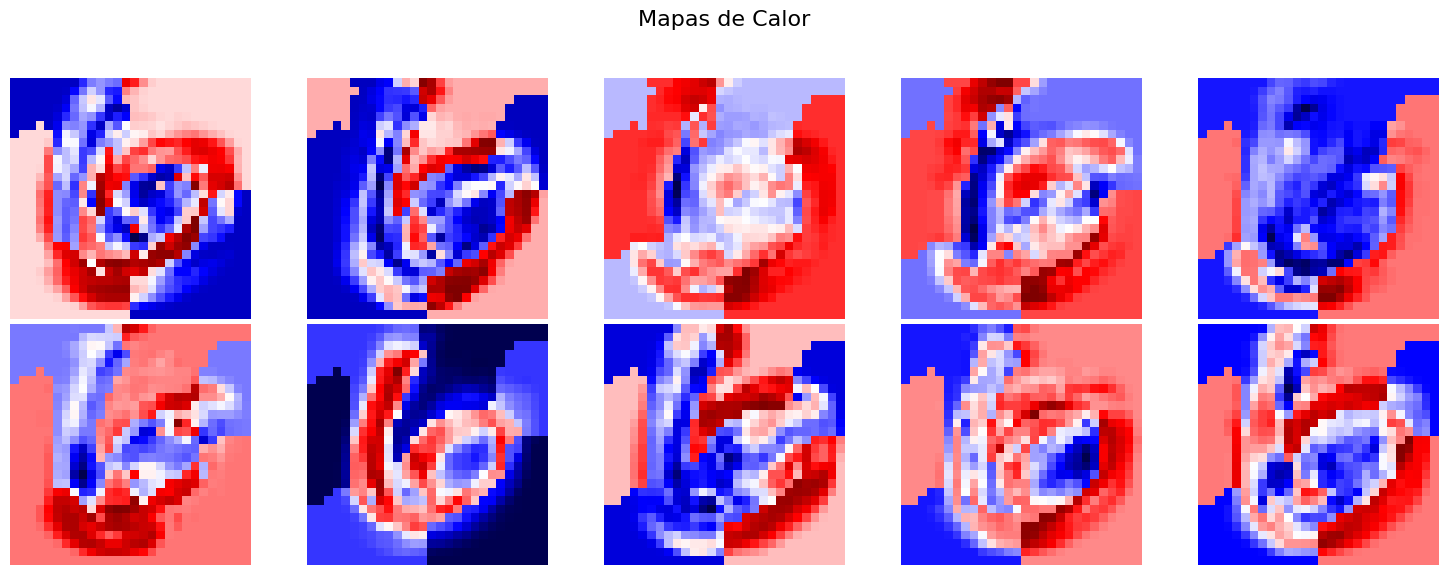

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8736147638972557, Min: 0.1996769252077918
Mapa 1: Max: 0.873837191838672, Min: 0.277431035277766
Mapa 2: Max: 0.9537833922775552, Min: 0.04516114270623355
Mapa 3: Max: 0.8219145540016792, Min: 0.03925042599439621
Mapa 4: Max: 0.8259390094516773, Min: 0.14367127241446925
Mapa 5: Max: 0.9715110484426076, Min: 0.03036335436378252
Mapa 6: Max: 0.9318717612142869, Min: 0.08771529711626254
Mapa 7: Max: 0.8399205251144993, Min: 0.15356498657032572
Mapa 8: Max: 0.8927096065074355, Min: 0.16587688061609768
Mapa 9: Max: 0.842653934817654, Min: 0.18261791373116812
Cantidad de rasgos mayores que 0.85: 7
Indices mayores que 0.85: [150 178 233 316 483 512 540]
Suma clase objetivo: 6.111129613330927
Suma de otras clases: 23.26283831945015
IFI calculado: 

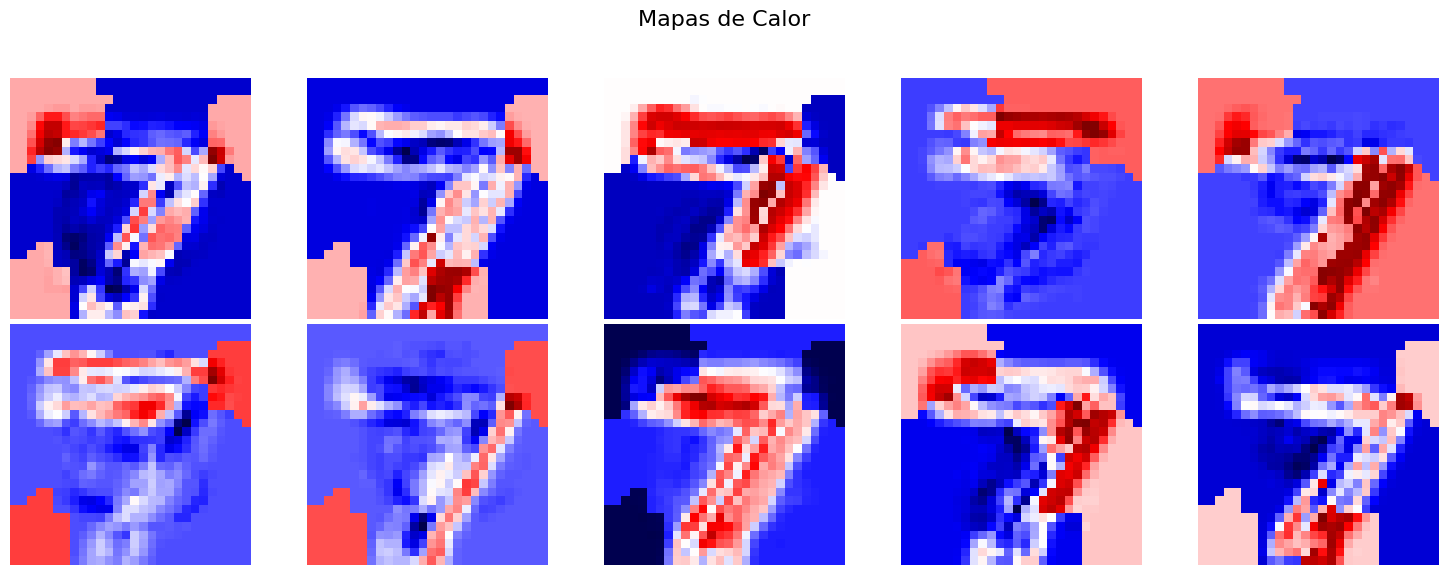

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8676557041746229, Min: 0.2487963753099367
Mapa 1: Max: 0.9584173042643096, Min: 0.2725998479872942
Mapa 2: Max: 0.8979966350186007, Min: 0.16309012573891746
Mapa 3: Max: 0.7860485689056265, Min: 0.06065383553504944
Mapa 4: Max: 0.9678190012867269, Min: 0.18959415184510686
Mapa 5: Max: 0.8187854411039014, Min: 0.12843668241699258
Mapa 6: Max: 0.9368142290716416, Min: 0.19131914107720305
Mapa 7: Max: 0.9647445338533968, Min: 0.03939646007983669
Mapa 8: Max: 0.9279207933701954, Min: 0.1663663047838976
Mapa 9: Max: 0.8763901071758509, Min: 0.17307015323810745
Cantidad de rasgos mayores que 0.85: 7
Indices mayores que 0.85: [233 234 235 263 264 267 268]
Suma clase objetivo: 6.295753840583867
Suma de otras clases: 24.983568201897967
IFI calculad

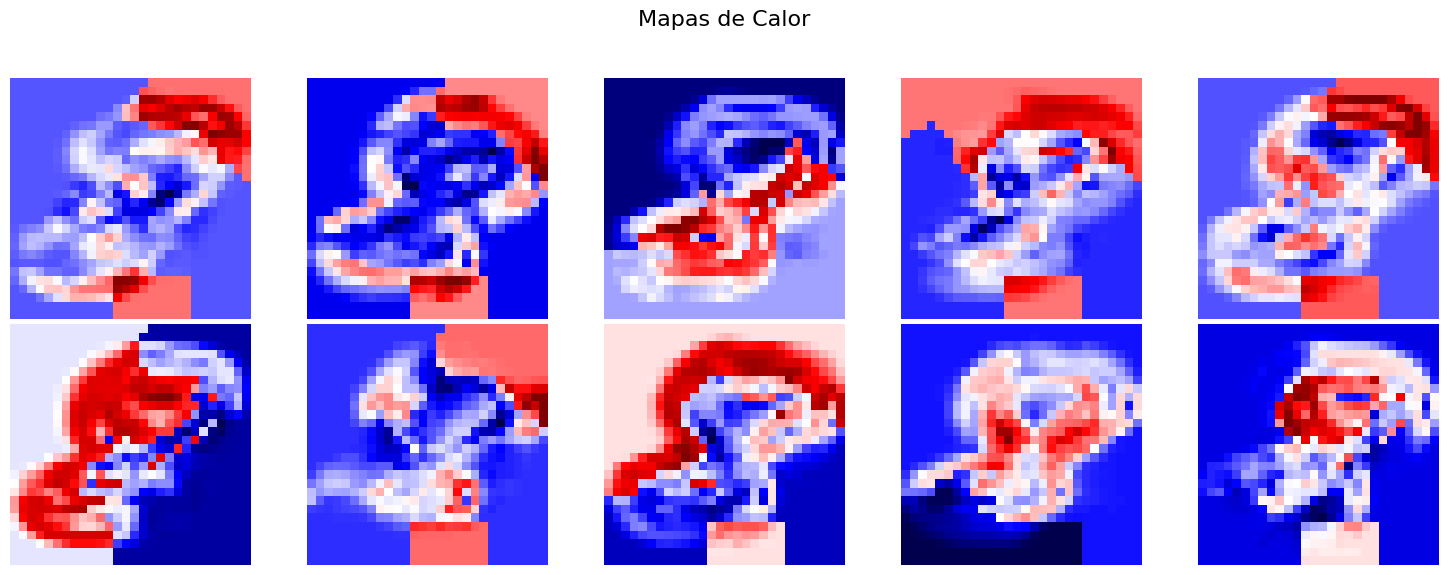

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.9078632921136853, Min: 0.08140243831922346
Mapa 1: Max: 0.8958324865598944, Min: 0.24723626354460965
Mapa 2: Max: 0.958759507035581, Min: 0.21850999948646993
Mapa 3: Max: 0.8804921803770454, Min: 0.16103143822700583
Mapa 4: Max: 0.8529199033707301, Min: 0.10427807486631016
Mapa 5: Max: 0.9467000120317599, Min: 0.24184016688460797
Mapa 6: Max: 0.8563645752146937, Min: 0.14657585837823503
Mapa 7: Max: 0.9418381749741372, Min: 0.26551206409931183
Mapa 8: Max: 0.9966208507670438, Min: 0.06496585966511251
Mapa 9: Max: 0.948973053233017, Min: 0.154605954479121
Cantidad de rasgos mayores que 0.85: 3
Indices mayores que 0.85: [347 348 376]
Suma clase objetivo: 2.8682209565925536
Suma de otras clases: 11.94012193426068
IFI calculado: 2.161953517012

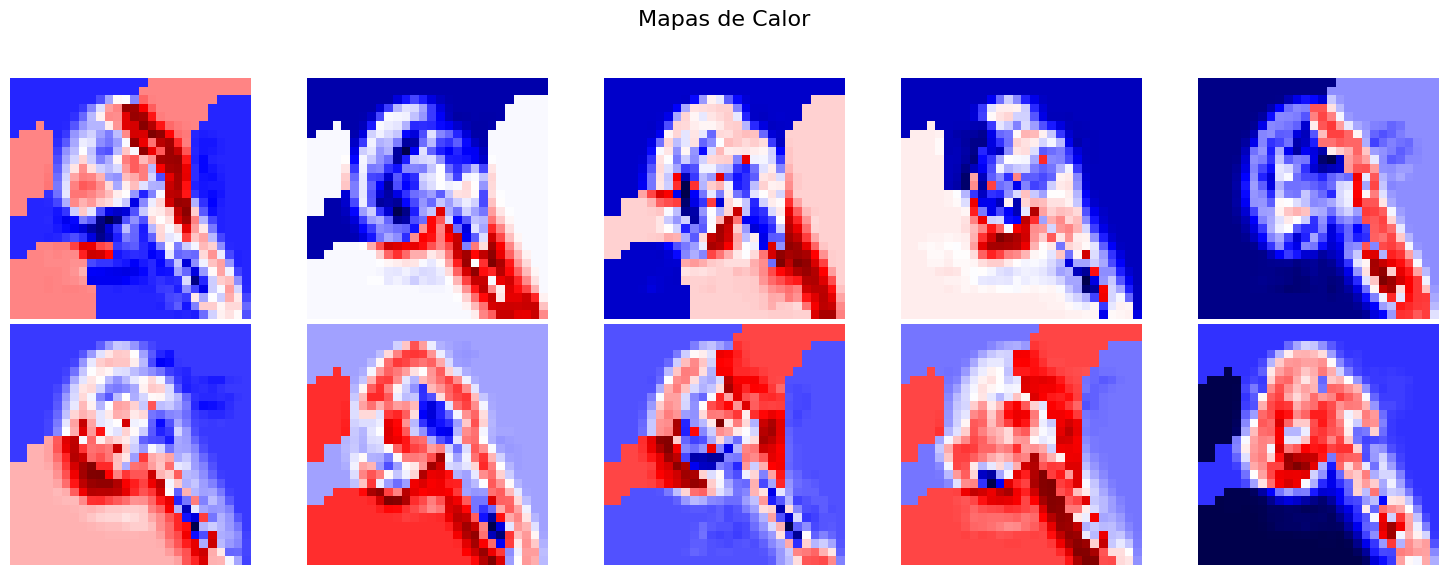

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.9436553404015, Min: 0.19676813951640748
Mapa 1: Max: 0.9524380005906443, Min: 0.25767622829618836
Mapa 2: Max: 0.9417379903621426, Min: 0.26375997082046054
Mapa 3: Max: 0.9694558898738957, Min: 0.2715696079088723
Mapa 4: Max: 0.998531672705129, Min: 0.17245229149117747
Mapa 5: Max: 0.9705922783850708, Min: 0.042780748663101595
Mapa 6: Max: 0.895617256982792, Min: 0.04737777262926102
Mapa 7: Max: 0.9010121365529755, Min: 0.1884837488310553
Mapa 8: Max: 0.8808464340646417, Min: 0.09503655633665024
Mapa 9: Max: 0.8834736484976822, Min: 0.03389413446755789
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [459]
Suma clase objetivo: 0.8834736484976822
Suma de otras clases: 4.230453079246053
IFI calculado: 1.8795298488208751
Image

In [31]:
# Calculate LSE values using the integrated maps
lse_values_avg = calculate_lse_per_image(integrated_explanations=avg_explanations, y_selected=y_selected)

# Representations

In [32]:
# Create a dictionary with the data
data = {
    'LSE_GradCAM': new_explanations_data[0]['lse_value'],
    'LSE_LRP': new_explanations_data[1]['lse_value'],
    'LSE_LIME': new_explanations_data[2]['lse_value'],
    'LSE_SHAP': new_explanations_data[3]['lse_value'],
    'LSE_Integrated_W': lse_integrated_sum,
    # 'LSE_Integrated_W_average': lse_integrated_average,
    # 'LSE_Integrated_S': lse_integrated_simple,
    'LSE_Union_W': lse_integrated_union,
    # 'LSE_Union_Max': union_max_lse,
    'LSE_Intersection_W': lse_integrated_intersection,
    'LSE_MAX': lse_values_max,
    'LSE_MIN': lse_values_min,
    'LSE_AVG': lse_values_avg,
    # 'LSE_Intersection_Max':  intersection_max_lse
}

# Convert the dictionary into a DataFrame
df_lse = pd.DataFrame(data)
# Calculate the average of each column and add it as a new row
df_lse.loc['Average'] = df_lse.mean()

# Save the DataFrame to an Excel file
df_lse.to_excel("Images/Relevance/lse_values_relevance_integration.xlsx", index=False)

# Display the DataFrame
print(df_lse)

         LSE_GradCAM   LSE_LRP  LSE_LIME  LSE_SHAP  LSE_Integrated_W  \
0           1.634669  2.281982  2.122826  3.698999          3.094538   
1           1.820137  2.015300  7.500000  2.066315          6.075291   
2           1.878394  2.229403  5.713043  4.150754          4.407535   
3           1.469424  2.236310  2.863986  1.990256          2.647354   
4           1.418482  2.128847  5.174820  1.771407          2.490375   
5           2.226111  2.218457  4.483019  3.034509          3.280957   
6           1.834446  1.928313  5.741160  2.354627          4.200072   
7           1.465923  2.365598  6.306338  2.413485          4.783422   
8           1.519325  2.370935  3.674179  2.749670          2.956075   
9           1.357500  2.259934  4.092965  3.197360          2.612754   
Average     1.662441  2.203508  4.767234  2.742738          3.654837   

         LSE_Union_W  LSE_Intersection_W   LSE_MAX    LSE_MIN   LSE_AVG  
0           5.041326            9.000000  1.091757   7.996166

In [ ]:
predictions = [(loaded_model.predict(np.expand_dims(image, axis=0))) for image in x_selected]
# predictions

1/1 [==============================] - 0s 22ms/step


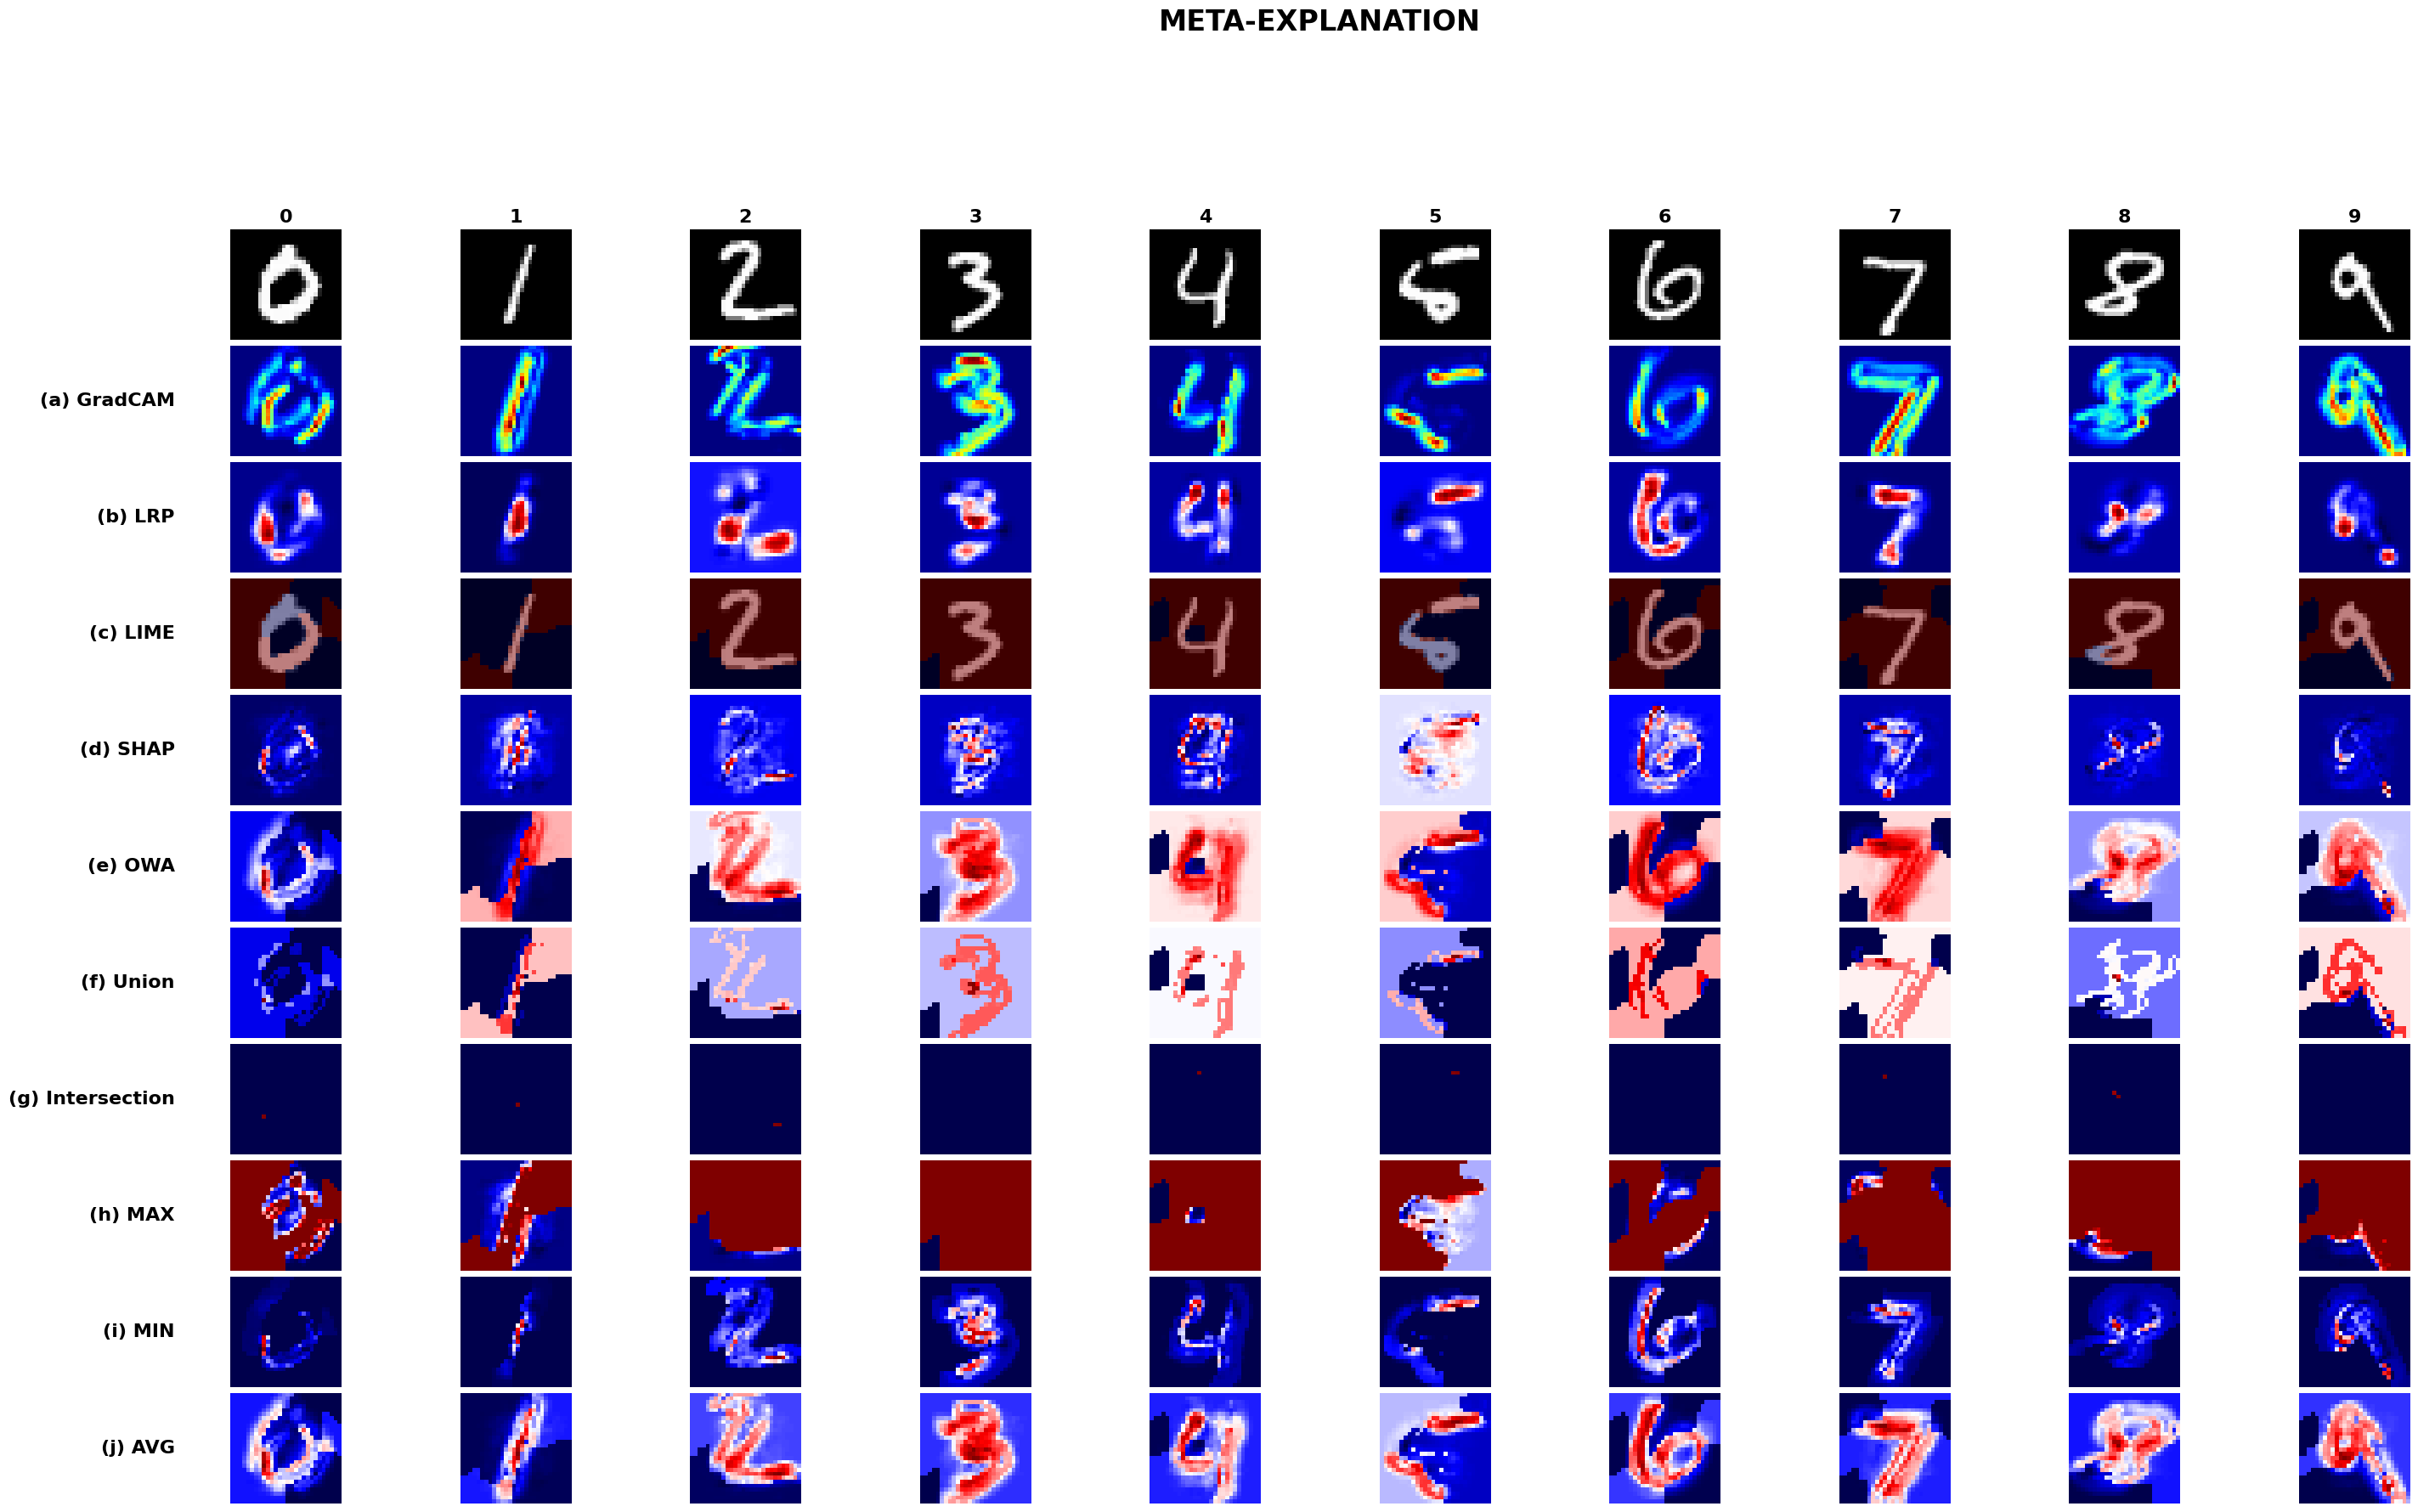

In [ ]:
explanations_dict = {
    'GradCAM': new_explanations_data[0]['explanations'],
    'LRP': new_explanations_data[1]['explanations'],
    'LIME': new_explanations_data[2]['explanations'],
    'SHAP': new_explanations_data[3]['explanations'],
    'OWA': integrated_explanations_sum,
    'Union': integrated_explanations_union,
    'Intersection': integrated_explanations_intersection,
    'MAX': max_explanations,
    'MIN': min_explanations,
    'AVG': avg_explanations
}

visualize_explanations_horizontal_with_original(x_selected, y_selected,predictions, explanations_dict, x_selected, y_selected)